# Standard modules

In [1]:
import tracemalloc
import psutil
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
#sns.set()
import pandas as pd
import numpy as np
from time import time
from scipy.stats import zscore
pd.options.display.max_colwidth = 1000

# Custom modules

In [2]:
# Custom modules: add the 'lib' directory as one where we can import modules
lib_src = '../../machine-learning'
sys.path.insert(1, lib_src)
from size import size
from to_csv_to_zip import to_csv_to_zip
from fit_cache import fit_cache
lib_src = '../../homewise/ds-core/'
sys.path.insert(1, lib_src)
from tools import glimpse, correlation_heatmap, numeric_statistics

# Exploring training data

## Load and view data

In [3]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

### Multi-class multi-label

According to [https://www.drivendata.org/competitions/4/box-plots-for-education/page/15/#labels_list] the labels are handled in alphabetical order.

`Object_Type` describes what the spending "is" while the other 8 categories describe what the spending "does", which groups of students benefit, and where the funds come from.

In [4]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
glimpse(df[LABELS], n=19)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 9 entries, Function to Use
dtypes: object(9)
memory usage: 242.0 MB


field non-null count missing ratio data type unique count  \
0          Function         400277           0.0    object           37   
1       Object_Type         400277           0.0    object           11   
2  Operating_Status         400277           0.0    object            3   
3     Position_Type         400277           0.0    object           25   
4             Pre_K         400277           0.0    object            3   
5         Reporting         400277           0.0    object            3   
6           Sharing         400277           0.0    object            5   
7      Student_Type         400277           0.0    object            9   
8               Use         400277           0.0    object            8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             unique preview  
0  [Aides Compensation, Career & Academic Counseling, Communications, Curriculum Development, Data Processing & Information Services, Development & Fundraising, Enrichment, Extended Time & Tutoring, Facilities & Maintenance, Facilities Planning, Finance, Budget, Purchasing & Distribution, Food Services, Governance, Human Resources, Instructional Materials & Supplies, Insurance, Legal, Library & Media, NO_LABEL, Other Compensation, Other Non-Compensation, Parent & Community Relations, Physical Health & Services, Professional Development, Recruitment, Research & Accountability, School Administration, School Supervision, Security & Safety, Social & Emotional, Special Population Program Management & Support, Student Assignment, Student Transportation, Substitute Compensation, Teacher Compensation, Untracked Budget Set-Aside, Utilities]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [Base Salary/Compensation, Benefits, Contracted Services, Equipment & Equipment Lease, NO_LABEL, Other Compensation/Stipend, Other Non-Compensation, Rent/Utilities, Substitute Compensation, Supplies/Materials, Travel & Conferences]  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

There is a hierarchical relationship for these labels. If a line is marked as `'Non-Operating'` in the `Operating_Status` category, then all of the other labels should be marked as `'NO_LABEL'` since ERS does not analyze and compare non-operating budget items.

In [5]:
other_labels = [l for l in LABELS if l !='Operating_Status']
df[df.Operating_Status=='Non-Operating'].groupby(['Operating_Status'] + other_labels, dropna=False).size()

Operating_Status  Function  Object_Type  Position_Type  Pre_K     Reporting  Sharing   Student_Type  Use     
Non-Operating     NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL    48034
dtype: int64

Checking which `Operating_Status` come along with all other labels marked as `'NO_LABEL'`.

In [6]:
df[(df[other_labels]=='NO_LABEL').all(axis=1)].groupby(['Operating_Status'] + other_labels,).size()

Operating_Status        Function  Object_Type  Position_Type  Pre_K     Reporting  Sharing   Student_Type  Use     
Non-Operating           NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL    48034
Operating, Not PreK-12  NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL     8665
dtype: int64

The same relationship were found when `Operating_Status` is 'Operating, Not PreK-12'

### Features

* `FTE` If an employee, the percentage of full-time that the employee works.
* `Facility_or_Department` - If expenditure is tied to a department/facility, that department/facility.
* `Function_Description` - A description of the function the expenditure was serving.
* `Fund_Description` - A description of the source of the funds.
* `Job_Title_Description` - If this is an employee, a description of that employee's job title.
* `Location_Description` - A description of where the funds were spent.
* `Object_Description` - A description of what the funds were used for.
* `Position_Extra` - Any extra information about the position that we have.
* `Program_Description` - A description of the program that the funds were used for.
* `SubFund_Description` - More detail on Fund_Description
* `Sub_Object_Description` - More detail on Object_Description
* `Text_1` - Any additional text supplied by the district.
* `Text_2` - Any additional text supplied by the district.
* `Text_3` - Any additional text supplied by the district.
* `Text_4` - Any additional text supplied by the district.
* `Total` The total cost of the expenditure.

In [7]:
FEATURES = [feature for feature in df.columns if feature not in LABELS]
FEATURES

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [8]:
glimpse(df[FEATURES])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 16 entries, Object_Description to Text_1
dtypes: float64(2), object(14)
memory usage: 309.5 MB


field non-null count missing ratio data type  \
0                      FTE         126071      0.685041   float64   
1   Facility_or_Department          53886      0.865378    object   
2     Function_Description         342195      0.145105    object   
3         Fund_Description         202877      0.493158    object   
4    Job_Title_Description         292743      0.268649    object   
5     Location_Description         162054      0.595145    object   
6       Object_Description         375493      0.061917    object   
7           Position_Extra         264764      0.338548    object   
8      Program_Description         304660      0.238877    object   
9      SubFund_Description         306855      0.233393    object   
10  Sub_Object_Description          91603      0.771151    object   
11                  Text_1         292285      0.269793    object   
12                  Text_2          88217       0.77961    object   
13                  Text_3         109152      0.727309    object   
14                  Text_4          53746      0.865728    object   
15                   Total         395722       0.01138   float64   

   unique count  \
0         21003   
1           179   
2           687   
3           141   
4          3516   
5           354   
6           602   
7           580   
8           421   
9           274   
10          182   
11         1423   
12          301   
13           34   
14          244   
15       286430   

                                                                                                                                                                                                                                                                                                                                          unique preview  
0                                                                                                                                                                                                         [-0.000255593312793, -0.000313463508459, -0.000964788883325, -0.00106383646319, -0.00120436417783, ..., 8.2, 8.4, 9.0, 9.6, 9.77249628643e-07]  
1                                      ["(Year End Allocation To   , "Human Resources, Administration", "Maintenance, Construction Projects", "Technology Department, Administration", ACCOUNTABILITY, ..., WAREHOUSE & GROUNDS           , WASTE WATER/SEWAGE PLANT      , WEB DESIGN                    , WRITING TEAMS                 , Warehousing]  
2                                                                                                                                     [ CENTURY CLASSROON COLLABO,  CENTURY TOOLKIT GRANT,  CNTRY COMMTY LRNG - ,  COP's CAPITAL FACILITIES,  ELA SUMMER ACADEMY, ..., WIRED WORKFORCE, WORK STUDY, WORK STUDY , Work Study Coordinator, YOUTH SERVICES]  
3   [ Regional Collaboratives,  Virtual School Network Receiver, "Title  Part A ARRA, "Title  Part A Improving Basic Programs", "Title  Part C - Migrant", ..., Trust And Agency Funds, Vocational Basic Ed., Vocational Education Enhancement, Vocational Education-Federal Funded, Vocational Education: Carl D. Perkins Vocational Education Act of ]  
4                                                                                   [               ,                   ,   Hour General ed aide,  Appliance Repair Tech ,  Athletic Field Tech , ..., prog mgr speech lang pathology, program coord family care, program coordinator:child fin, recruitment coordinator, special assistant to exec dir]  
5                                                                                            [ACADEMY, ACCOUNTABILITY, TESTING, RESEARCH & EVAL, ACCOUNTABILITY-RESEARCH-EVAL, ACCOUNTING SERVICE OFFICE, ACCOUNTS PAYABLE, ..., VOCATIONAL/TECHNICAL SCHOOLS, WAREHOUSE AND SUPPORT         , WAREHOUSE OPERATIONS, WELLNESS CENTER, WORK STUDY OFFICE]  
6                                   ["Building Purchase, Construction Or Improvements", ******

### Numeric features

In [9]:
NUMERIC_FEATURES = ['FTE', 'Total']
TEXT_FEATURES = [text_feature for text_feature in FEATURES if text_feature not in NUMERIC_FEATURES]
glimpse(df[NUMERIC_FEATURES])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 2 entries, FTE to Total
dtypes: float64(2)
memory usage: 9.2 MB


field non-null count missing ratio data type unique count  \
0    FTE         126071      0.685041   float64        21003   
1  Total         395722       0.01138   float64       286430   

                                                                                                                                   unique preview  
0  [-0.000255593312793, -0.000313463508459, -0.000964788883325, -0.00106383646319, -0.00120436417783, ..., 8.2, 8.4, 9.0, 9.6, 9.77249628643e-07]  
1                   [-0.004162455553, -0.01, -0.0128689914276, -0.0199999999994599, -0.02, ..., 99999.72, 99999.79, 99999.9, 99999.97, 999999.43]

## Missing values

Overall count and proportion of missing data

In [10]:
missing = df.isnull()
missing.sum().sum(), missing.sum().sum() / (df.shape[0] * df.shape[1])

(2942109, 0.29400729994478825)

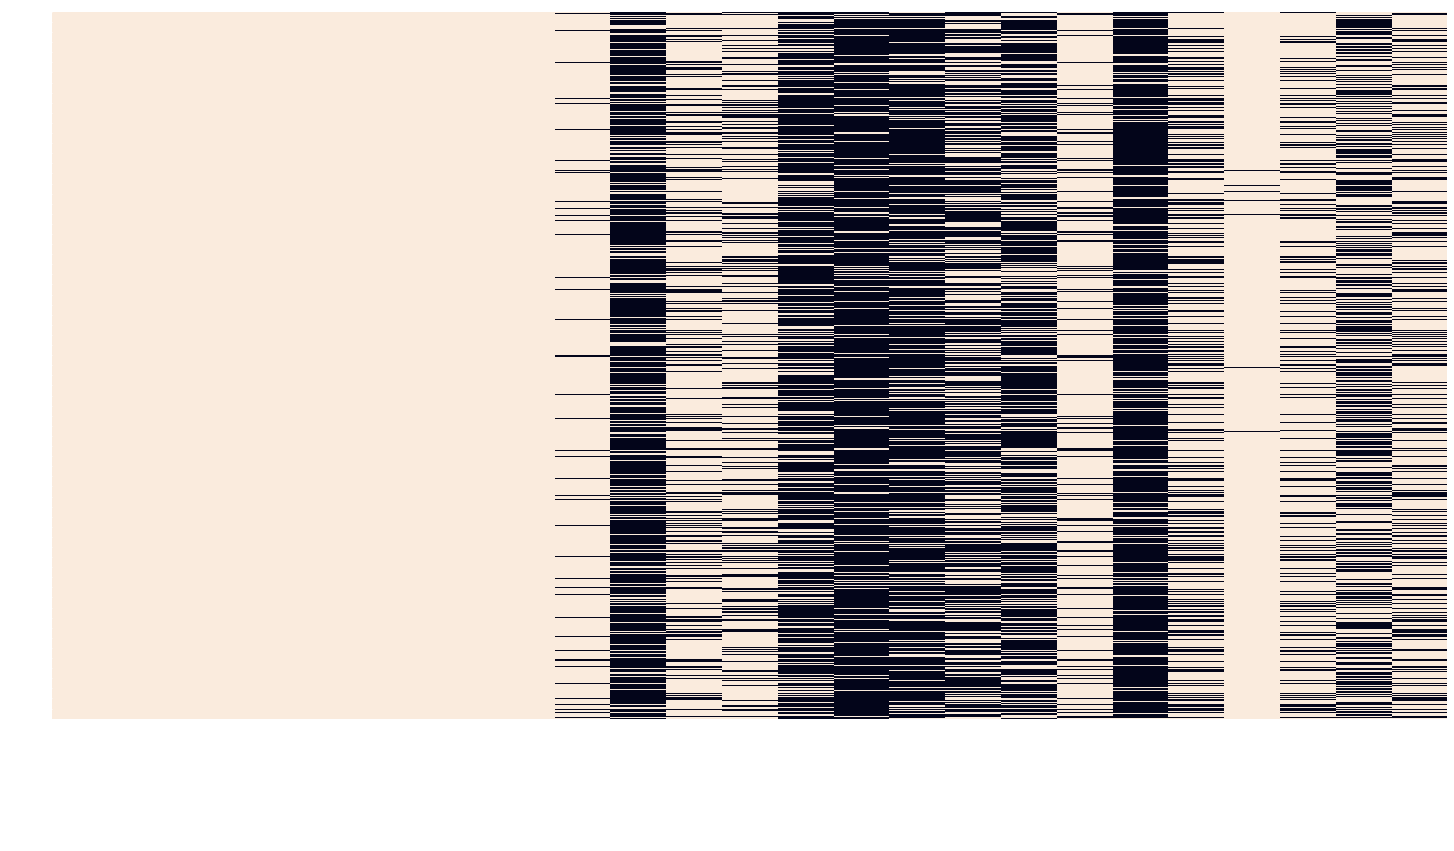

In [11]:
plt.figure(figsize=(25,13))
sns.heatmap(~missing, cbar=False)
plt.show()

### Missing features

Missing report function: Count and proportion of missing data per column

In [12]:
def missing_report(df):
    area = (df.shape[0]*(df.shape[1]))
    proportion = lambda x: x.sum() / area
    missing = df.isnull().agg(['sum', 'mean', proportion]).transpose()
    missing = missing.sort_values('sum', ascending=False)
    missing.columns = ['missing', 'column proportion', 'overall proportion']
    missing['missing'] = missing.missing.astype('int')
    return missing

In [13]:
missing_report(df[FEATURES])

missing  column proportion  overall proportion
Text_4                   346531           0.865728            0.054108
Facility_or_Department   346391           0.865378            0.054086
Text_2                   312060           0.779610            0.048726
Sub_Object_Description   308674           0.771151            0.048197
Text_3                   291125           0.727309            0.045457
FTE                      274206           0.685041            0.042815
Location_Description     238223           0.595145            0.037197
Fund_Description         197400           0.493158            0.030822
Position_Extra           135513           0.338548            0.021159
Text_1                   107992           0.269793            0.016862
Job_Title_Description    107534           0.268649            0.016791
Program_Description       95617           0.238877            0.014930
SubFund_Description       93422           0.233393            0.014587
Function_Description      58082           0.145105            0.009069
Object_Description        24784           0.061917            0.003870
Total                      4555           0.011380            0.000711

The numeric variable `FTE` lacks `68%` and `Total` lacks only `1%`.  The most frequent text column is `Object Description`.

### **Missing `FTE`**

Let's subtotal missing `FTE` by `Object Description`: One can see high ocurrence of 'EMPLOYEE BENEFITS', similar object descriptions and also 'SUPPLIES'.

In [14]:
df.fillna({'Object_Description':'NaN'}).loc[df.FTE.isnull()].groupby('Object_Description').size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                 47495
CONTRA BENEFITS                   19381
ADDITIONAL/EXTRA DUTY PAY/STIP    16841
SUPPLIES                          13117
RETIREMENT CONTRIB.               13073
                                  ...  
RESERVE                               1
RESIDENTIAL FACILITIES                1
Custodial  Supplies                   1
Remaining Other Vendors               1
OTHER MATERIALS AND SUPPLIES          1
Length: 555, dtype: int64

### **Missing `Total`**

Let's subtotal missing `Total` by `Object Description`:  One can see high occurrence in 'EMPLOYEE BENEFITS' and similar object descriptions.

In [15]:
df.fillna({'Object_Description':'NaN'}).loc[df.Total.isnull()].groupby('Object_Description').size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                                     1184
SALARIES OF REGULAR EMPLOYEES                          876
EMPLOYER PD MED CONTRIBUTION                           295
Salaries And Wages For Teachers And Other Professi     288
NaN                                                    261
                                                      ... 
PRINTING, BINDING, DUPLICATING                           1
POSTAGE                                                  1
PART TIME OVERTIME WAGES                                 1
FOOD SRV-NON REFRIGERATION PRT                           1
OTHER PURCHASED SERVICES                                 1
Length: 217, dtype: int64

### Missing Total and FTE relationship

Let's list `Total` related to missing `FTE`: High `Total` values, like 129,7 millions, not related to (missing) `FTE`.

In [16]:
df.loc[df.FTE.isnull(), ['Total', 'Object_Description']].sort_values('Total', ascending=False)

Total               Object_Description
358538  1.297000e+08  Payments to a Community School*
322149  5.323797e+07         Other Purchased Services
390959  4.789057e+07        PAYMENTS TO ESCROW AGENTS
177775  3.956446e+07               INTEREST ON LEASES
331752  3.645094e+07                        BUILDINGS
...              ...                              ...
300250           NaN                EMPLOYEE BENEFITS
289753           NaN    SALARIES OF REGULAR EMPLOYEES
438970           NaN                EMPLOYEE BENEFITS
334668           NaN                EMPLOYEE BENEFITS
29710            NaN                EMPLOYEE BENEFITS

[274206 rows x 2 columns]

Let's list `FTE` related to missing `Total`: Highest `FTE` values, close to 1, whose missing `Total` is not clear.

In [17]:
df.loc[df.Total.isnull(), ['FTE', 'Object_Description']].sort_values('FTE', ascending=False)

FTE             Object_Description
392540  1.127804  SALARIES OF REGULAR EMPLOYEES
147244  1.016335  SALARIES OF REGULAR EMPLOYEES
91088   1.012847  SALARIES OF REGULAR EMPLOYEES
60354   1.012223  SALARIES OF REGULAR EMPLOYEES
203019  1.009218  SALARIES OF REGULAR EMPLOYEES
...          ...                            ...
300250       NaN              EMPLOYEE BENEFITS
289753       NaN  SALARIES OF REGULAR EMPLOYEES
438970       NaN              EMPLOYEE BENEFITS
334668       NaN              EMPLOYEE BENEFITS
29710        NaN              EMPLOYEE BENEFITS

[4555 rows x 2 columns]

### **No missing labels**

No label has missing data

In [18]:
missing[LABELS].all().all()

False

## Continuous variables: FTE and Total

`FTE`: full-time equivalent
If the budget item is associated to an employee, this number tells us the **percentage** of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.

`Total`: total cost of the expenditure.
This number tells us how much the budget item cost.

In [19]:
numeric_statistics(df)

count          mean            std           min        25%  \
FTE    126071      0.426794       0.573576 -8.755064e-02   0.000792   
Total  395722  13105.856828  368225.392358 -8.746631e+07  73.797700   

              50%        75%           max  missing  miss_ratio           sum  \
FTE      0.130927     1.0000  4.680000e+01   274206    0.685041  5.380634e+04   
Total  461.230000  3652.6625  1.297000e+08     4555    0.011380  5.186276e+09   

              range    skewness      kurtosis          iqr  lo_outlier  \
FTE    4.688755e+01   19.273698   1172.951126     0.999208    -1.49802   
Total  2.171663e+08  100.319800  51040.801730  3578.864800 -5294.49950   

        hi_outlier  
FTE       2.498812  
Total  9020.959700

Function to plot a panel with a scatter, density and box plots:

In [20]:
from scipy.stats import zscore
def density_plots(x, label=None, outlying = True, zthreshold = 3, bins=None, figsize=(25,5)):

    if outlying:
        x_mean = x.mean()
        x_std = x.std()
        lower_limit = x_mean - zthreshold * x_std
        upper_limit = x_mean + zthreshold * x_std
        outliers = x[(zscore(x) < -zthreshold) | (zscore(x) > zthreshold)]

    plt.figure(figsize=figsize)

    # scatter plot
    plt.subplot(1,3,1); plt.grid(False)
    plt.plot(x, marker='.', linestyle='none', color='green', label='inlier')
    plt.ylabel(label); plt.xlabel('row')
    if outlying:
        plt.plot(outliers, marker='.', linestyle='none', color='red', label='outlier')
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    # density plot
    plt.subplot(1,3,2); plt.grid(False)
    plt.hist(x, bins=bins)
    plt.xlabel(label); plt.ylabel('PDF')

    if outlying:
        plt.axvline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axvline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    # box plot
    plt.subplot(1,3,3); plt.grid(False)
    # sns.boxplot(y=x, orient='v')
    plt.boxplot(x)
    # plt.ylabel(label)
    # plt.xticks=False

    if outlying:
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

### `FTE` univariate analysis

`FTE` contains skewed data with upper outliers

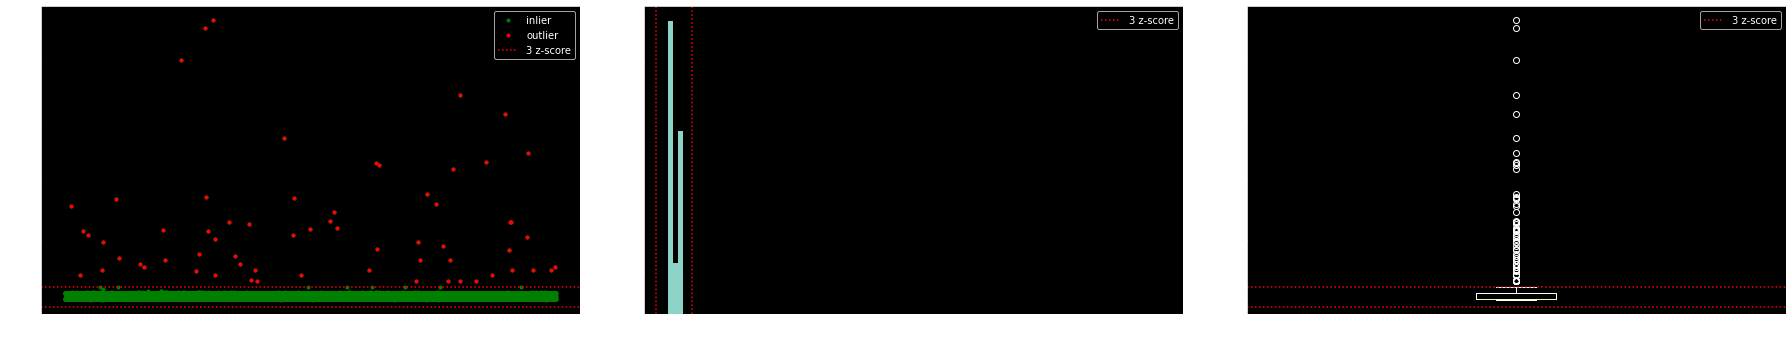

Upper outliers: 64
Lower outliers: 0


In [21]:
fte = df.FTE.dropna()
density_plots(fte, 'FTE', bins=100)
zscores = zscore(fte)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

`FTE` ouliers hold values from `3` o `46.8`, assumed as multiple headcount.  Those values seem reasonable for the `Total` and description columns that follow:

In [22]:
relevant = ['FTE', 'Total', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[fte[(zscores < -3) | (zscores > 3)].index.values, relevant].sort_values('FTE', ascending=False)

FTE          Total   Fund_Description  \
135371  46.8  528191.986943  Central Cafeteria   
128399  45.6  478476.893739  Central Cafeteria   
105857  40.2  580900.061569  Central Cafeteria   
362251  34.2  484744.886261  Central Cafeteria   
404264  31.1  352252.935596  Central Cafeteria   
...      ...            ...                ...   
362443   3.0  280332.905298            General   
377132   3.0  149857.502317            General   
351528   3.0  162472.656884            General   
176122   3.0  130486.445186            General   
322285   3.0  135557.941531            General   

                                   Object_Description Job_Title_Description  
135371  Personal Services - Food Services - Cafeteria                   NaN  
128399  Personal Services - Food Services - Cafeteria                   NaN  
105857  Personal Services - Food Services - Cafeteria                   NaN  
362251  Personal Services - Food Services - Cafeteria                   NaN  
404264  Personal Services - Food Services - Cafeteria                   NaN  
...                                               ...                   ...  
362443                                      Regular *   TCHR, OCC THERAPIST  
377132                                      Regular *    EDUCATIONAL AIDE I  
351528                                      Regular *         MOBILE DEPUTY  
176122                                      Regular *             PARA (MF)  
322285                                      Regular *             PARA (OH)  

[64 rows x 5 columns]

What if to remove upper outliers?

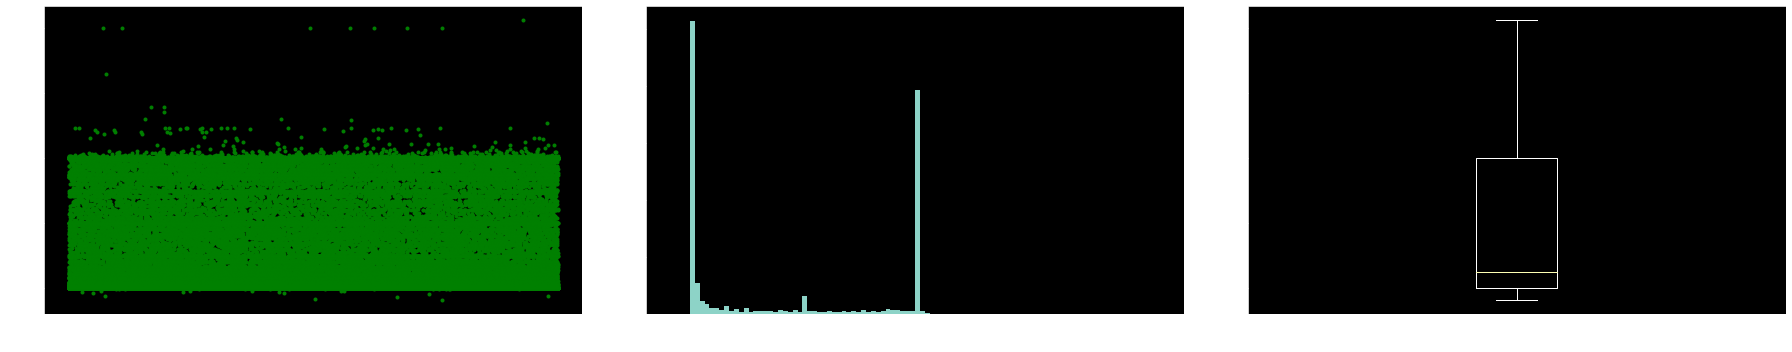

In [23]:
fte_no_outliers = fte[zscores <= 3]
density_plots(fte_no_outliers, 'FTE', outlying=False, bins=100)

### `Total` univariate analysis

`Total` contains upper and lower outliers with magnitude or +/- 100 millions.

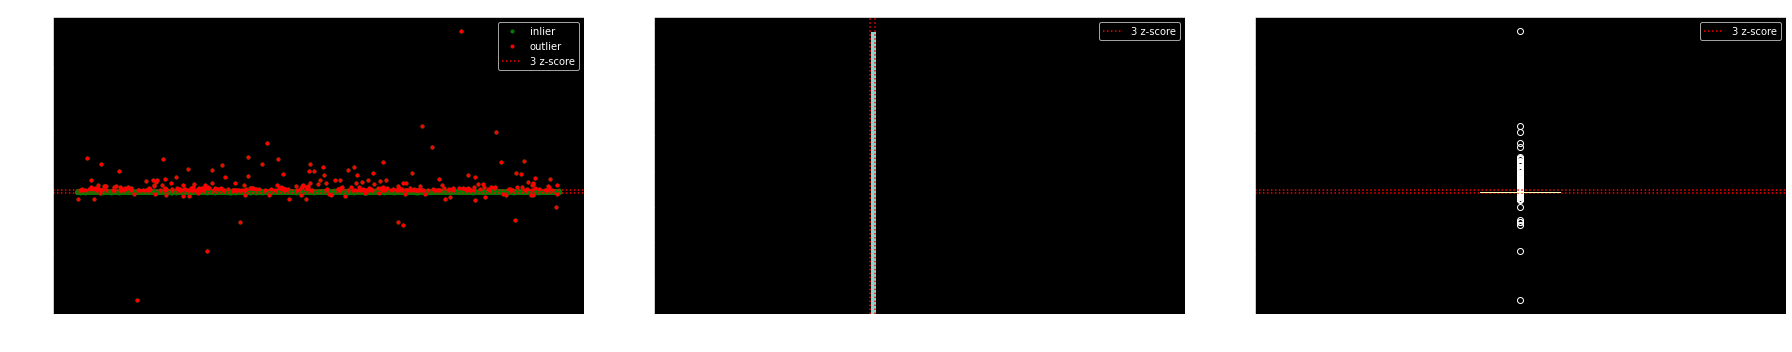

Upper outliers: 317
Lower outliers: 37


In [24]:
total = df.Total.dropna()
density_plots(total, 'Total', bins=100)
zscores = zscore(total)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

Those `Total` outliers are associated with null `FTE`, i.e., they are not related to headcount but to facilities, buildings, insurances, etc.

In [25]:
relevant = ['Total', 'FTE', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[total[(zscores < -3) | (zscores > 3)].index, relevant].sort_values('Total', ascending=False)

Total  FTE                  Fund_Description  \
358538  1.297000e+08  NaN                           General   
322149  5.323797e+07  NaN  Employee Benefits Self-Insurance   
390959  4.789057e+07  NaN                               NaN   
177775  3.956446e+07  NaN                               NaN   
331752  3.645094e+07  NaN                               NaN   
...              ...  ...                               ...   
152005 -2.399966e+07  NaN                      General Fund   
299589 -2.400000e+07  NaN             Capital Projects Fund   
304649 -2.646500e+07  NaN                               NaN   
121092 -4.789057e+07  NaN                               NaN   
56063  -8.746631e+07  NaN                               NaN   

                        Object_Description Job_Title_Description  
358538     Payments to a Community School*                   NaN  
322149            Other Purchased Services                   NaN  
390959           PAYMENTS TO ESCROW AGENTS               (blank)  
177775                  INTEREST ON LEASES               (blank)  
331752                           BUILDINGS               (blank)  
...                                    ...                   ...  
152005  OPERATING TRANSFERS TO OTHER FUNDS                   NaN  
299589  OPERATING TRANSFERS TO OTHER FUNDS                   NaN  
304649             REDEMPTION OF PRINCIPAL               (blank)  
121092           PAYMENTS TO ESCROW AGENTS               (blank)  
56063                            BUILDINGS               (blank)  

[354 rows x 5 columns]

What if to remove all outliers?

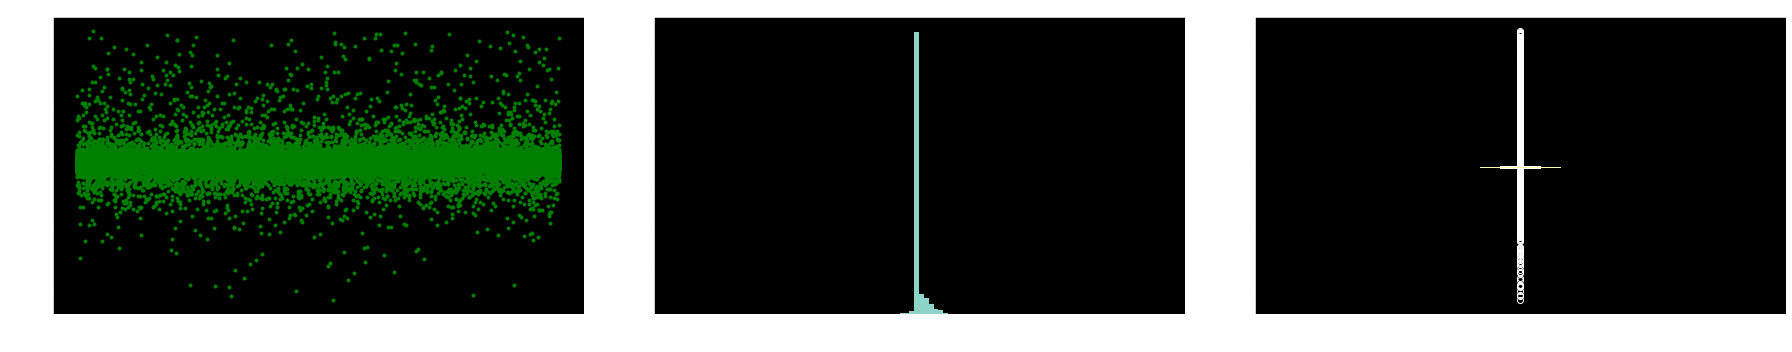

In [26]:
total_no_outliers = total[(zscores >= -3) & (zscores <= 3)]
density_plots(total_no_outliers, 'Total', outlying=False, bins=100)

Under the hyphotesis that negative values are sign mistakes, what if to fix them by flipping their signs? **It would move most of the lower outliers to be upper outliers.**

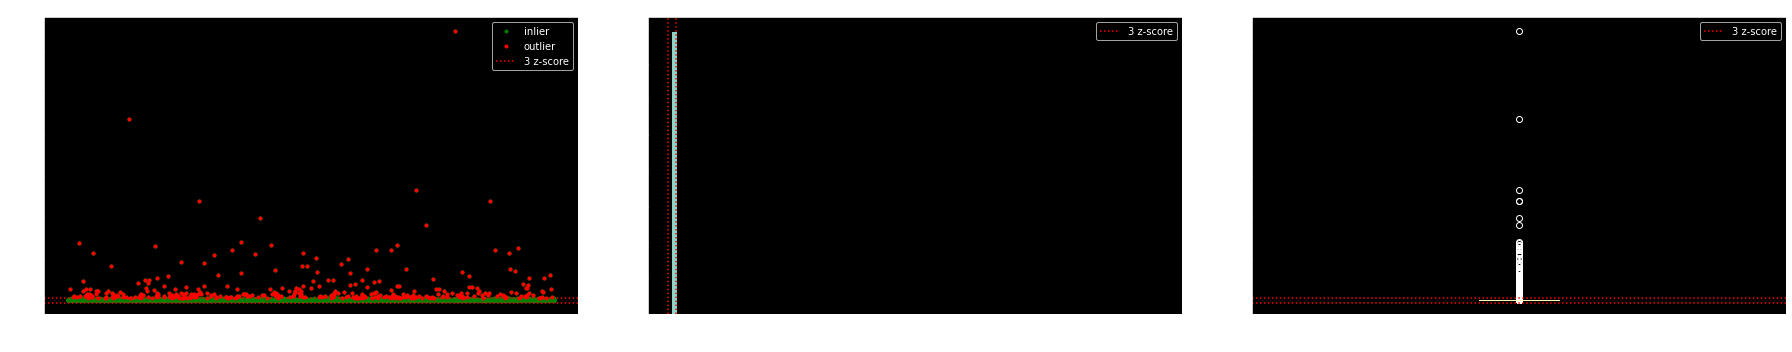

Upper outliers: 352
Lower outliers: 0


In [27]:
total_fixed = total.abs()
density_plots(total_fixed, 'Total', bins=100)
zscores_fixed = zscore(total_fixed)
print('Upper outliers:', sum(zscores_fixed > 3))
print('Lower outliers:', sum(zscores_fixed < -3))

### Bivariate analysis

#### Linear regression/correlation by imputation strategy

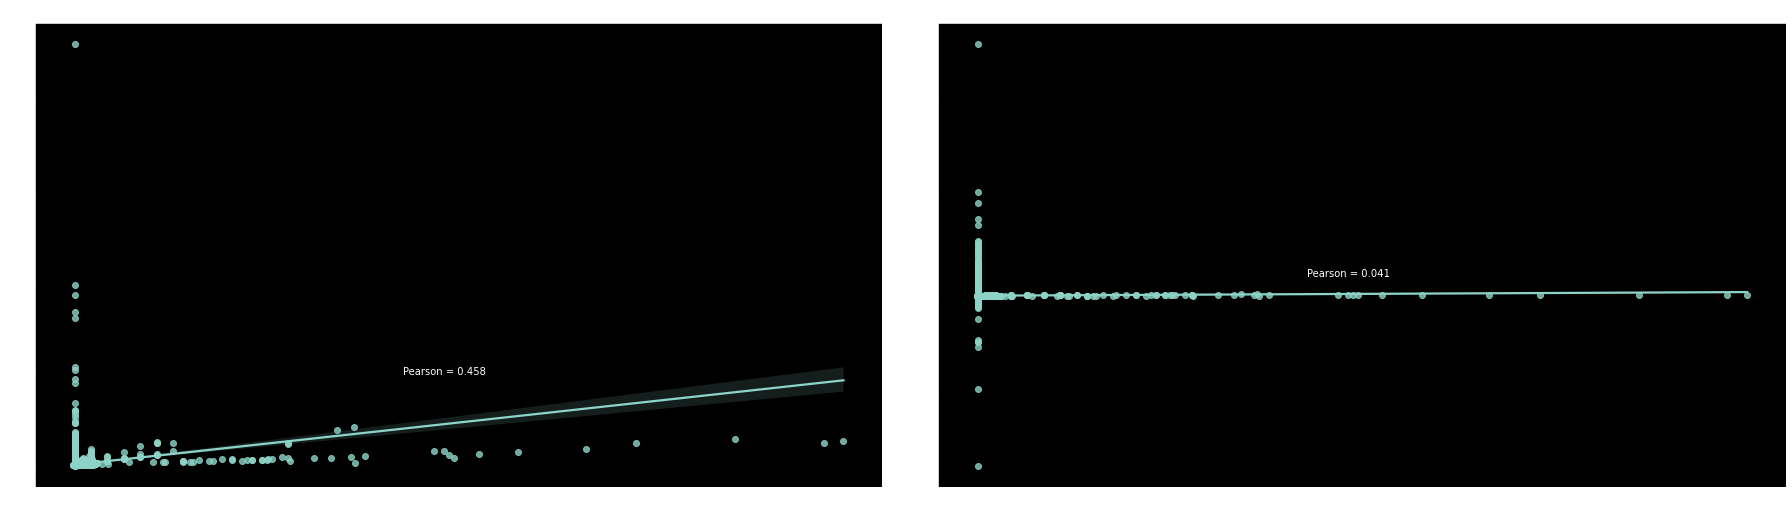

In [28]:
dropna_df = df[NUMERIC_FEATURES].dropna()
zero_imputed_df = df[NUMERIC_FEATURES].fillna(0)
# mean_imputed_df = df[NUMERIC_FEATURES].fillna(df[NUMERIC_FEATURES].mean())
# median_imputed_df = df[NUMERIC_FEATURES].fillna(df[NUMERIC_FEATURES].median())

plt.figure(figsize=(25,14))
plt.subplot(2,2,1)
sns.regplot(x='FTE', y='Total', data=dropna_df)
plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(dropna_df.FTE, dropna_df.Total)[0,1]), (20,2000000))
plt.title('Drop missing')
plt.subplot(2,2,2)
sns.regplot(x='FTE', y='Total', data=zero_imputed_df)
plt.title('Zero imputed')
plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(zero_imputed_df.FTE, zero_imputed_df.Total)[0,1]), (20,10000000))
# plt.subplot(2,2,3)
# sns.regplot(x='FTE', y='Total', data=mean_imputed_df)
# plt.title('Mean imputed')
# plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(mean_imputed_df.FTE, mean_imputed_df.Total)[0,1]), (20,10000000))
# plt.subplot(2,2,4)
# sns.regplot(x='FTE', y='Total', data=mean_imputed_df)
# plt.title('Median imputed')
# plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(median_imputed_df.FTE, median_imputed_df.Total)[0,1]), (20,10000000))
plt.tight_layout()
plt.show()

#### Grouped correlations before and after zero imputation

In [29]:
def grouped_corr_plot(by):
    grouped_corr = df[[by, 'FTE', 'Total']].groupby(by).corr().dropna().unstack().iloc[:,2].to_frame('raw corr')
    grouped_corr['imputed corr'] = df[[by, 'FTE', 'Total']].fillna({'FTE':0, 'Total':0}).groupby(by).corr().dropna().unstack().iloc[:,2].rename('imputed corr')
    grouped_corr.plot(kind='barh', figsize=(15,15))
    plt.title(f'FTE and Total correlation grouped by {by}')
    plt.xlabel('Correlation')
    plt.grid(axis='x')
    plt.show()

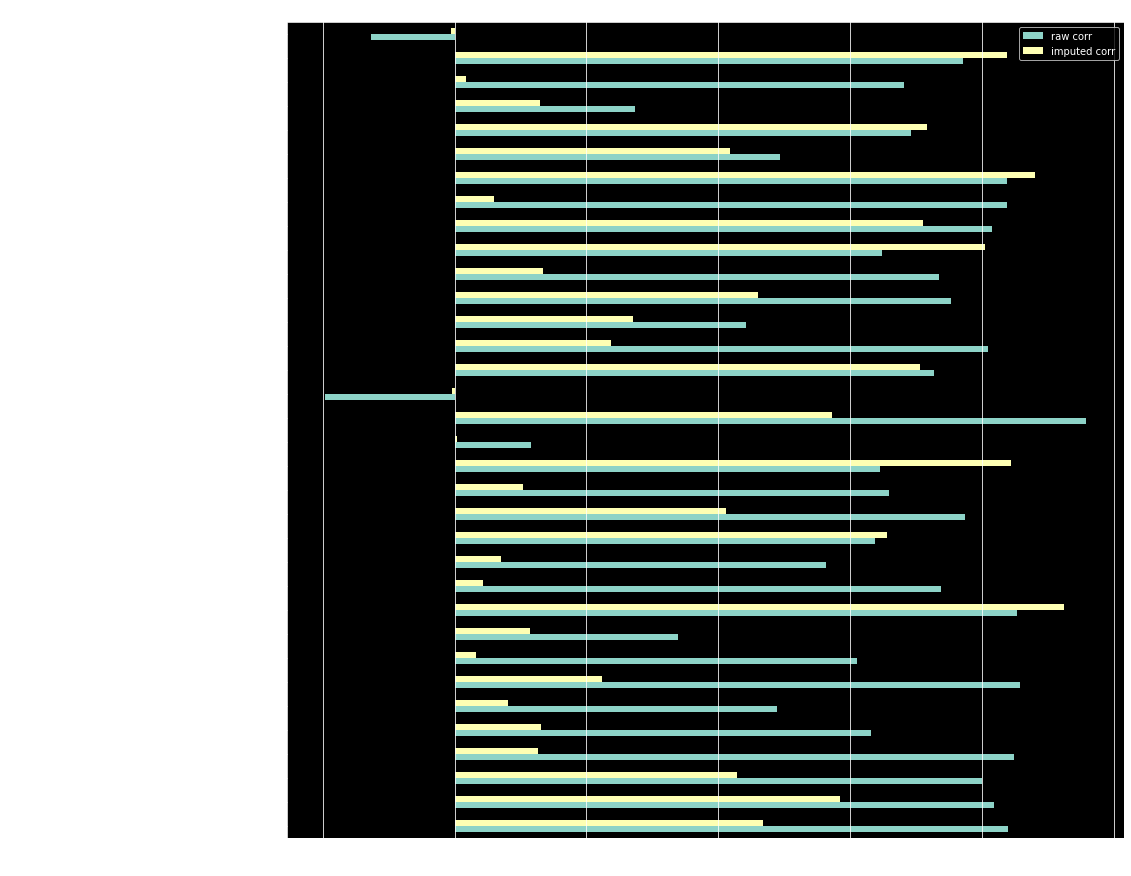

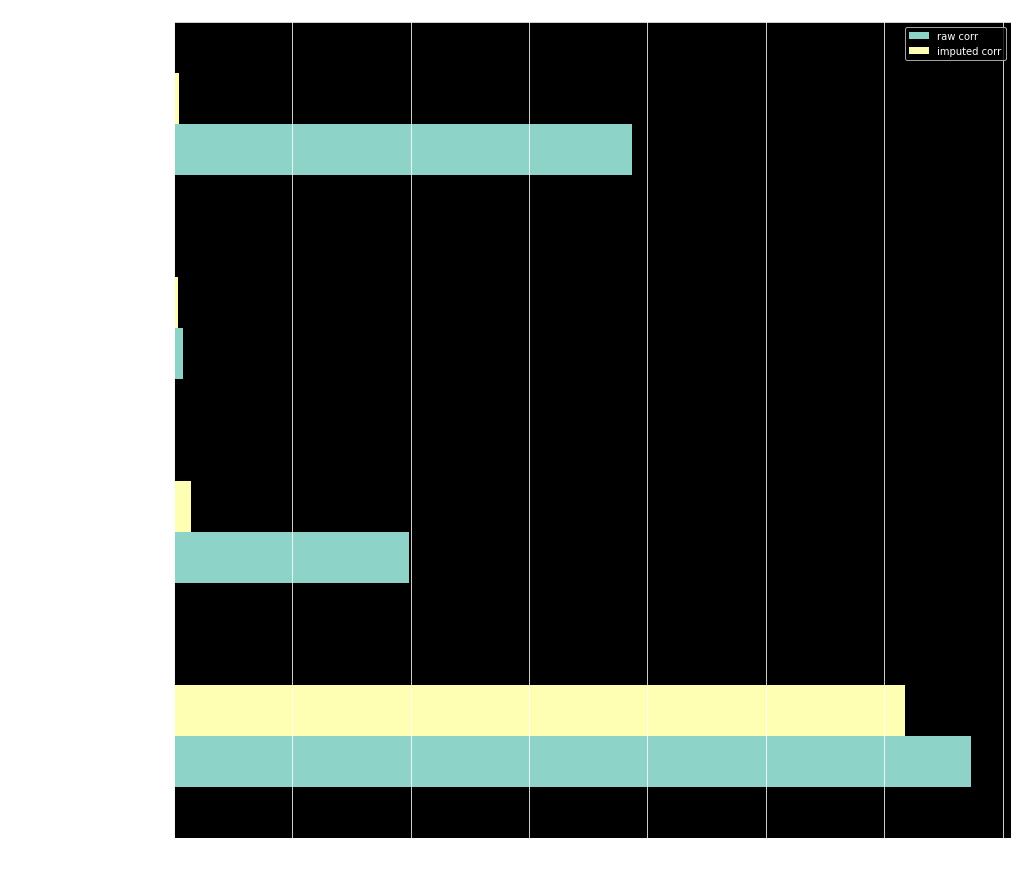

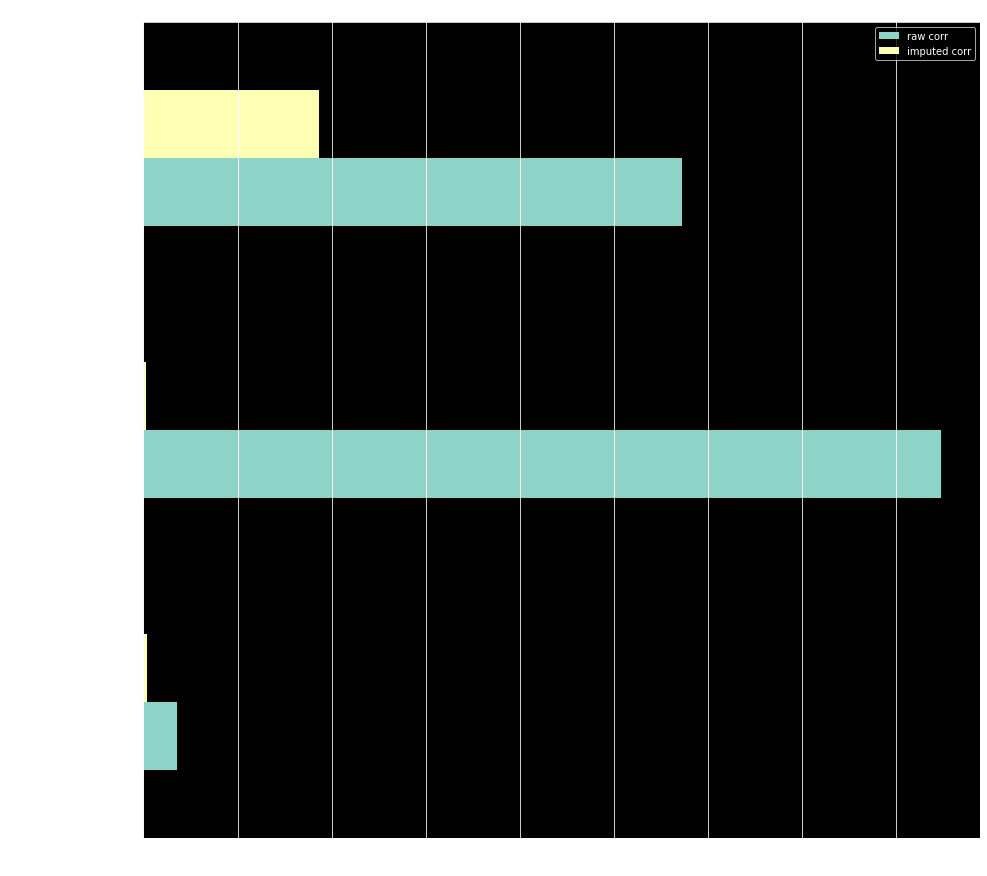

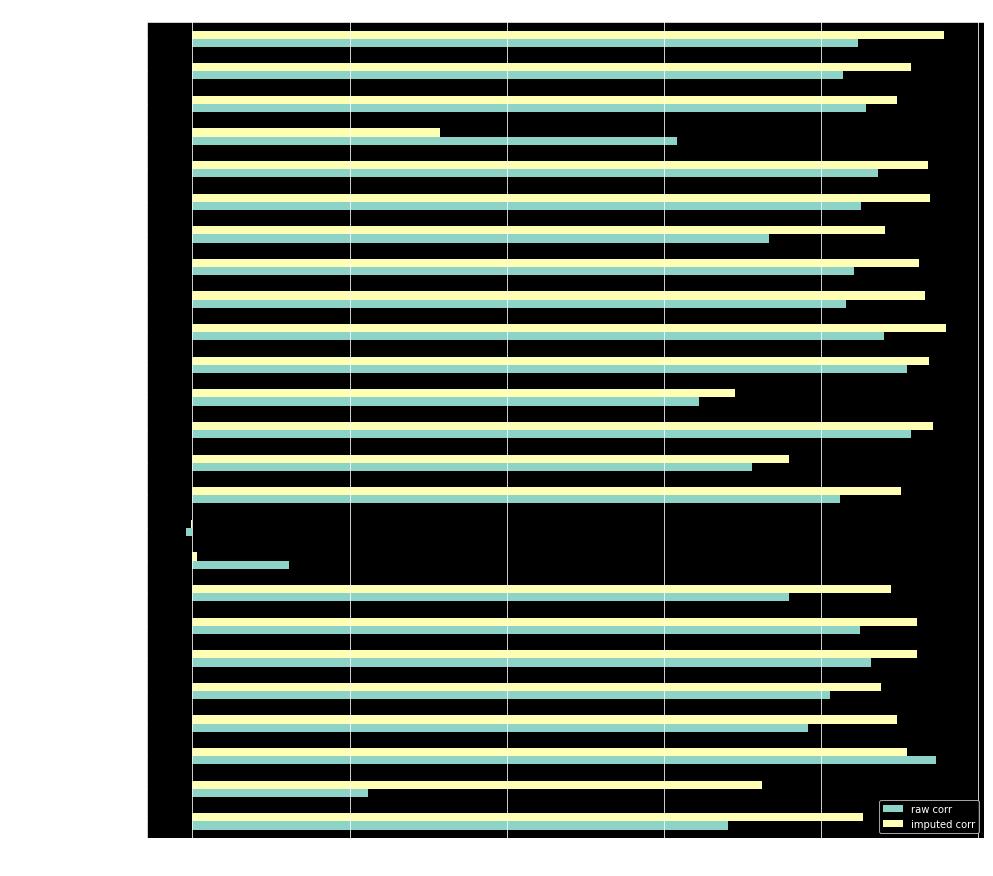

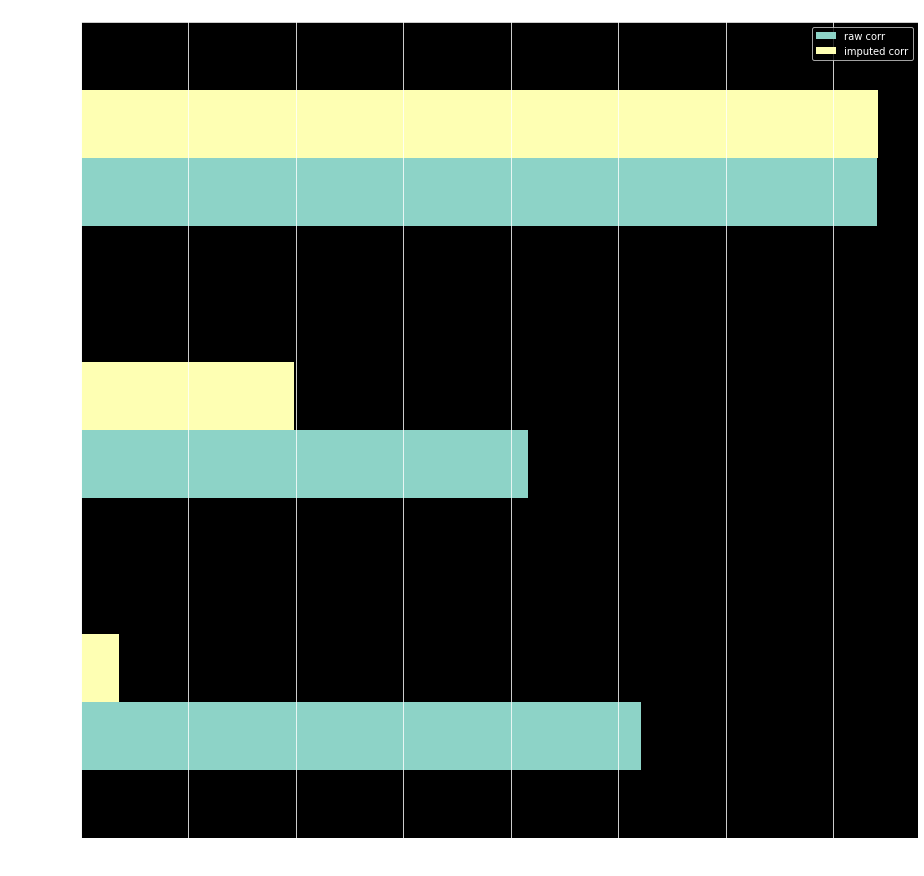

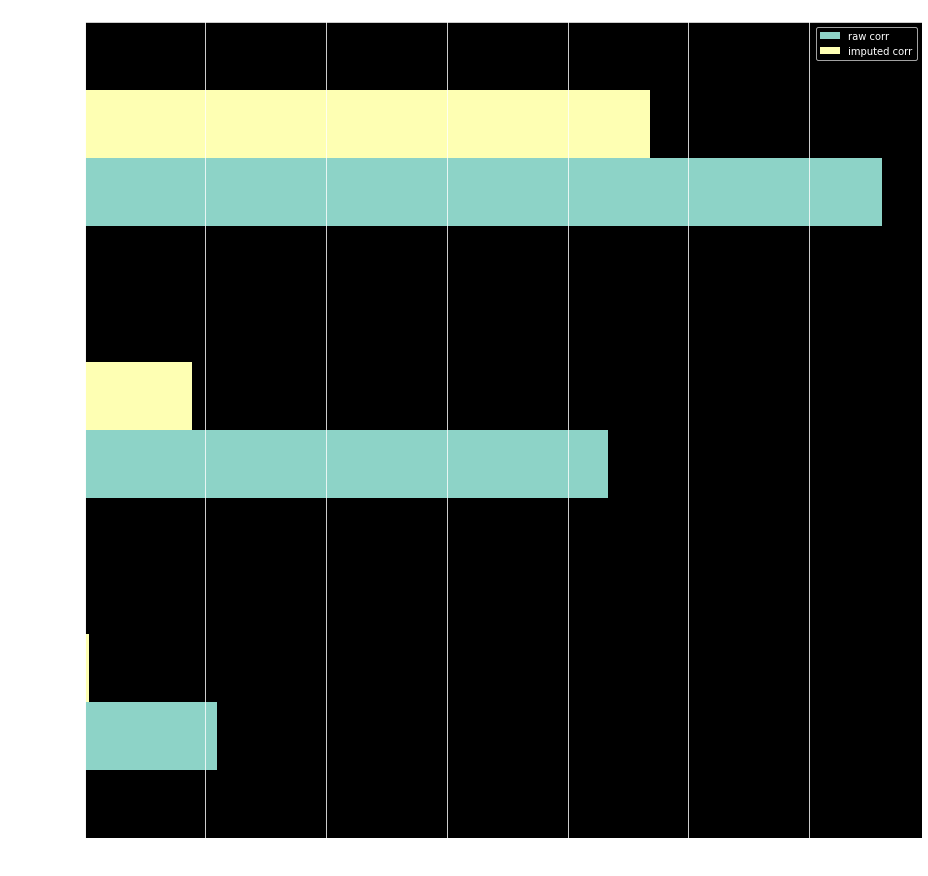

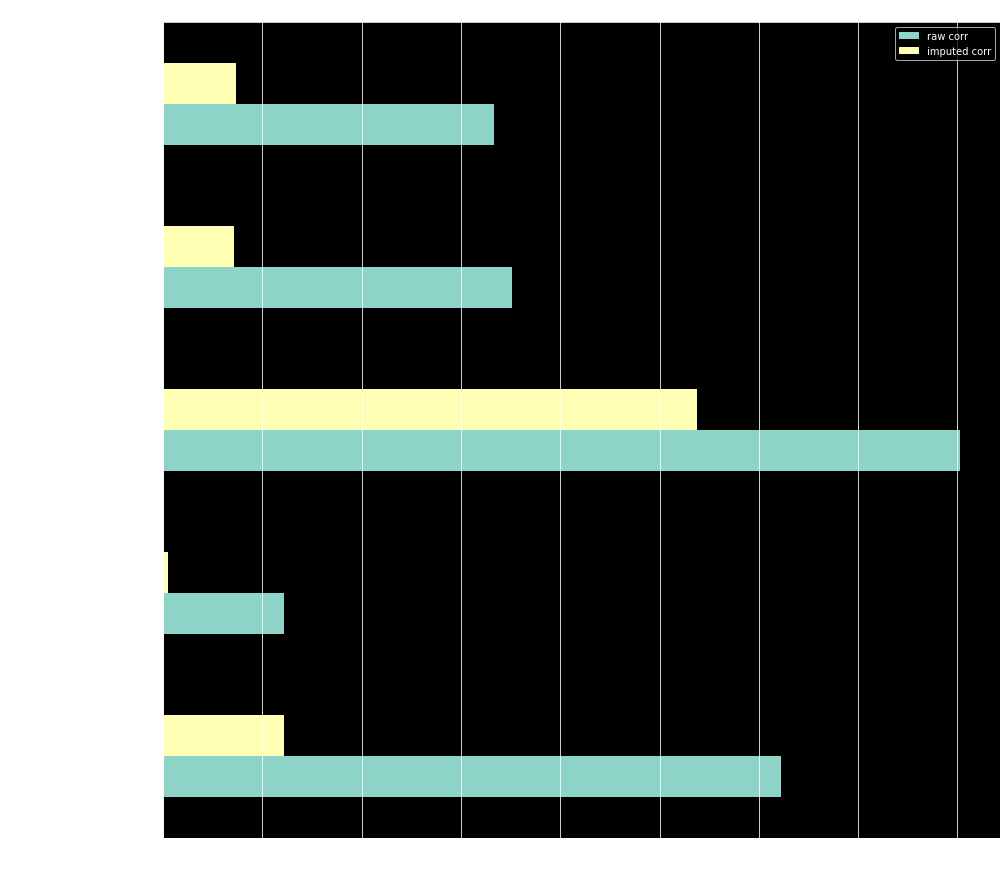

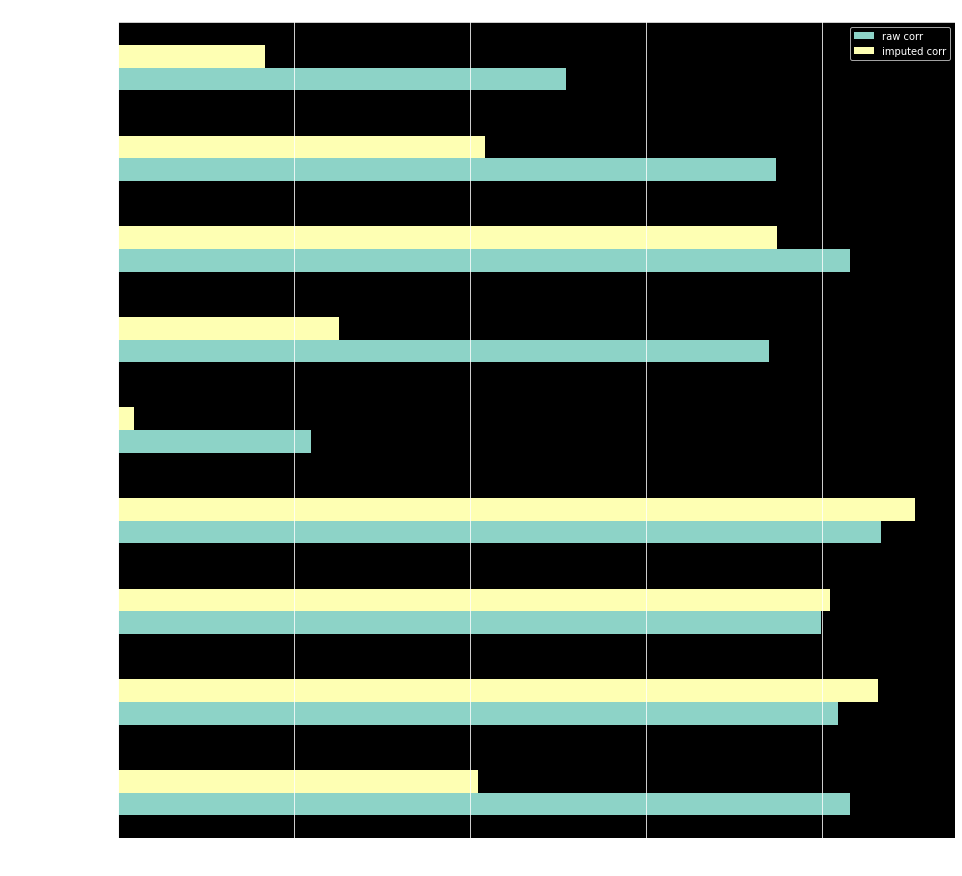

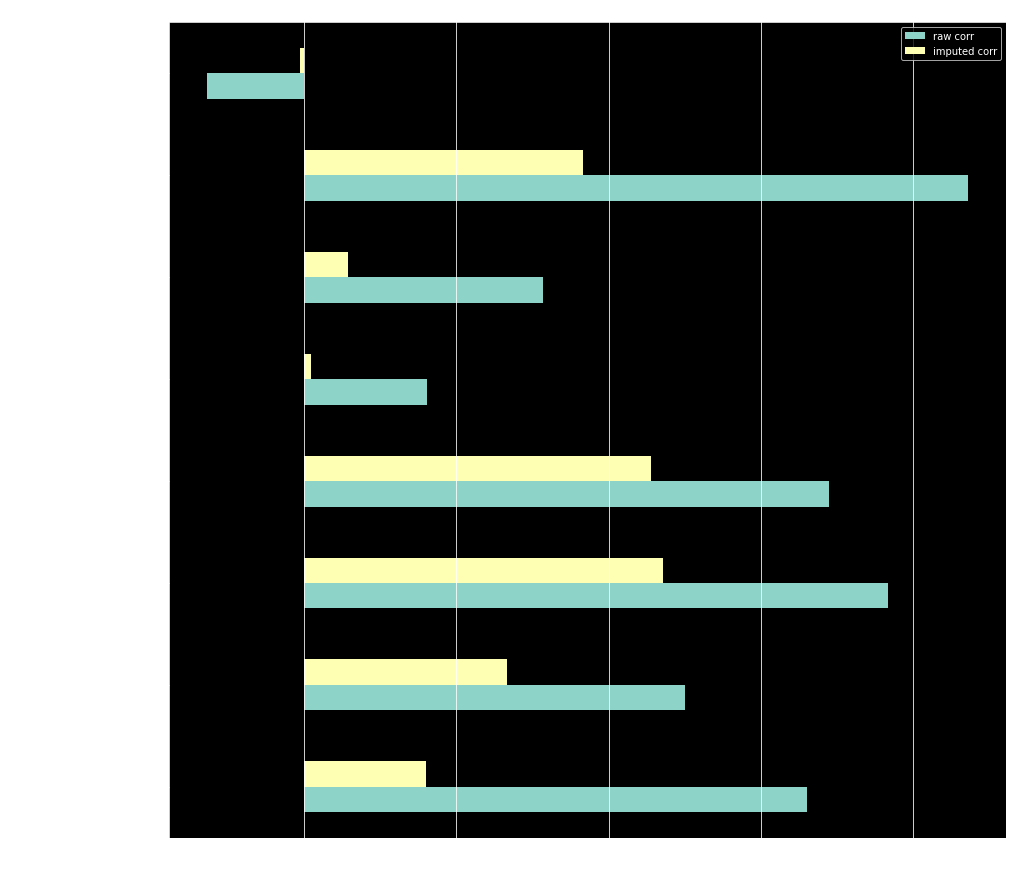

In [30]:
for x in LABELS:
    grouped_corr_plot(x)

#### Plotting numeric totals grouped by every label

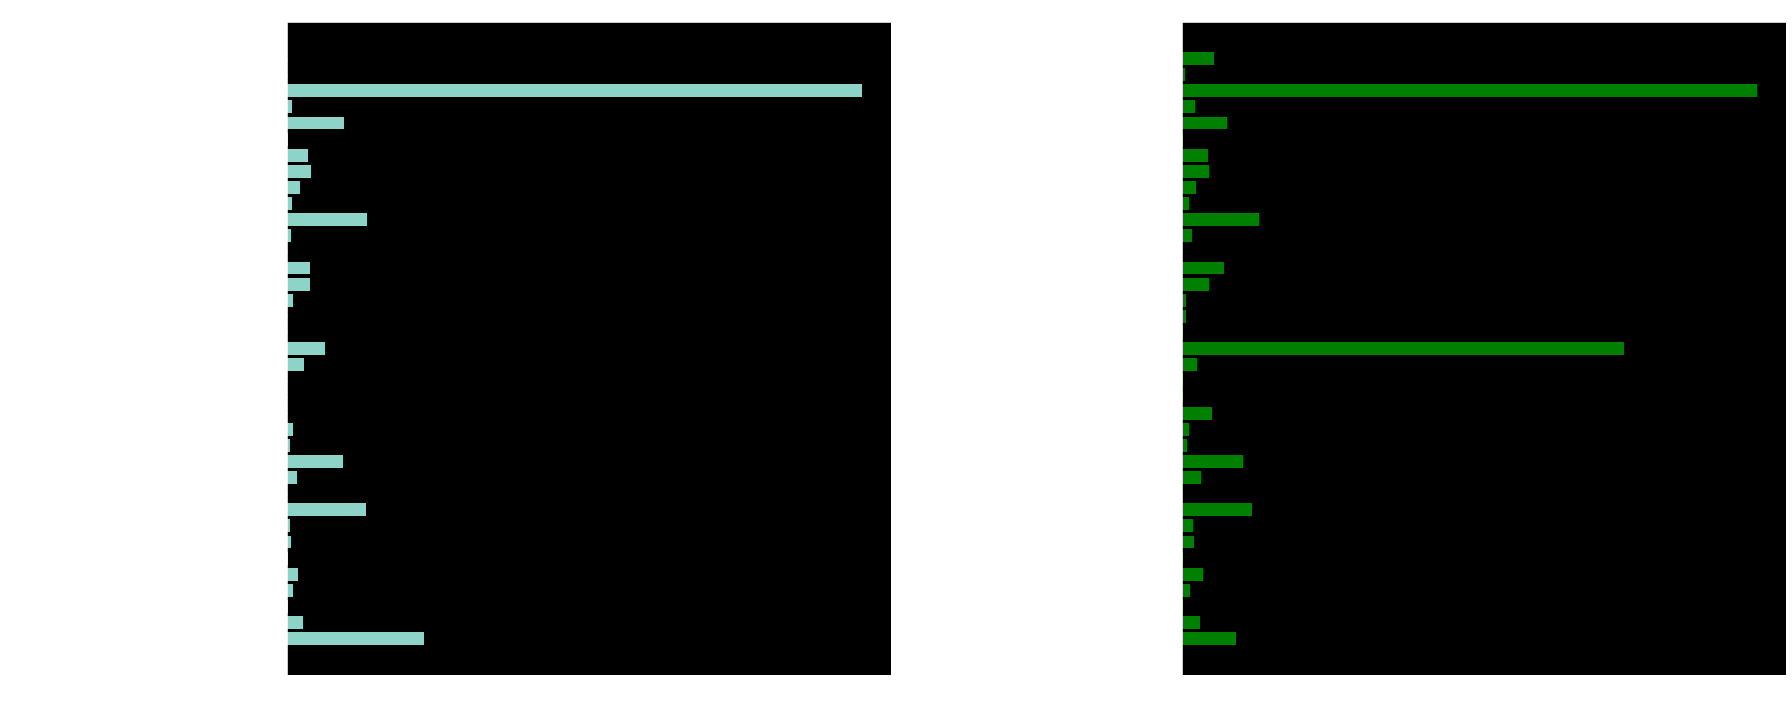

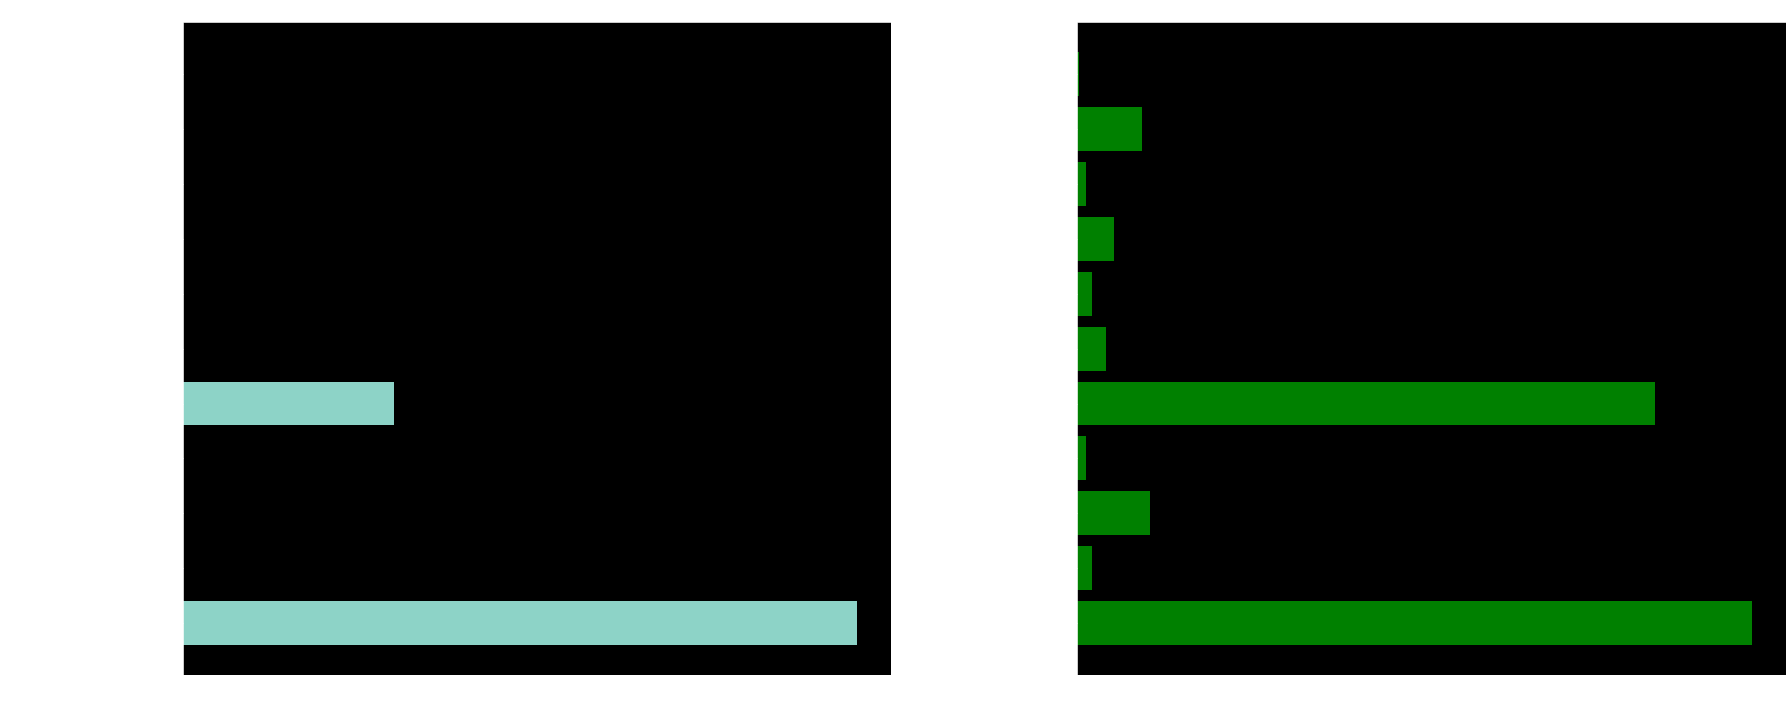

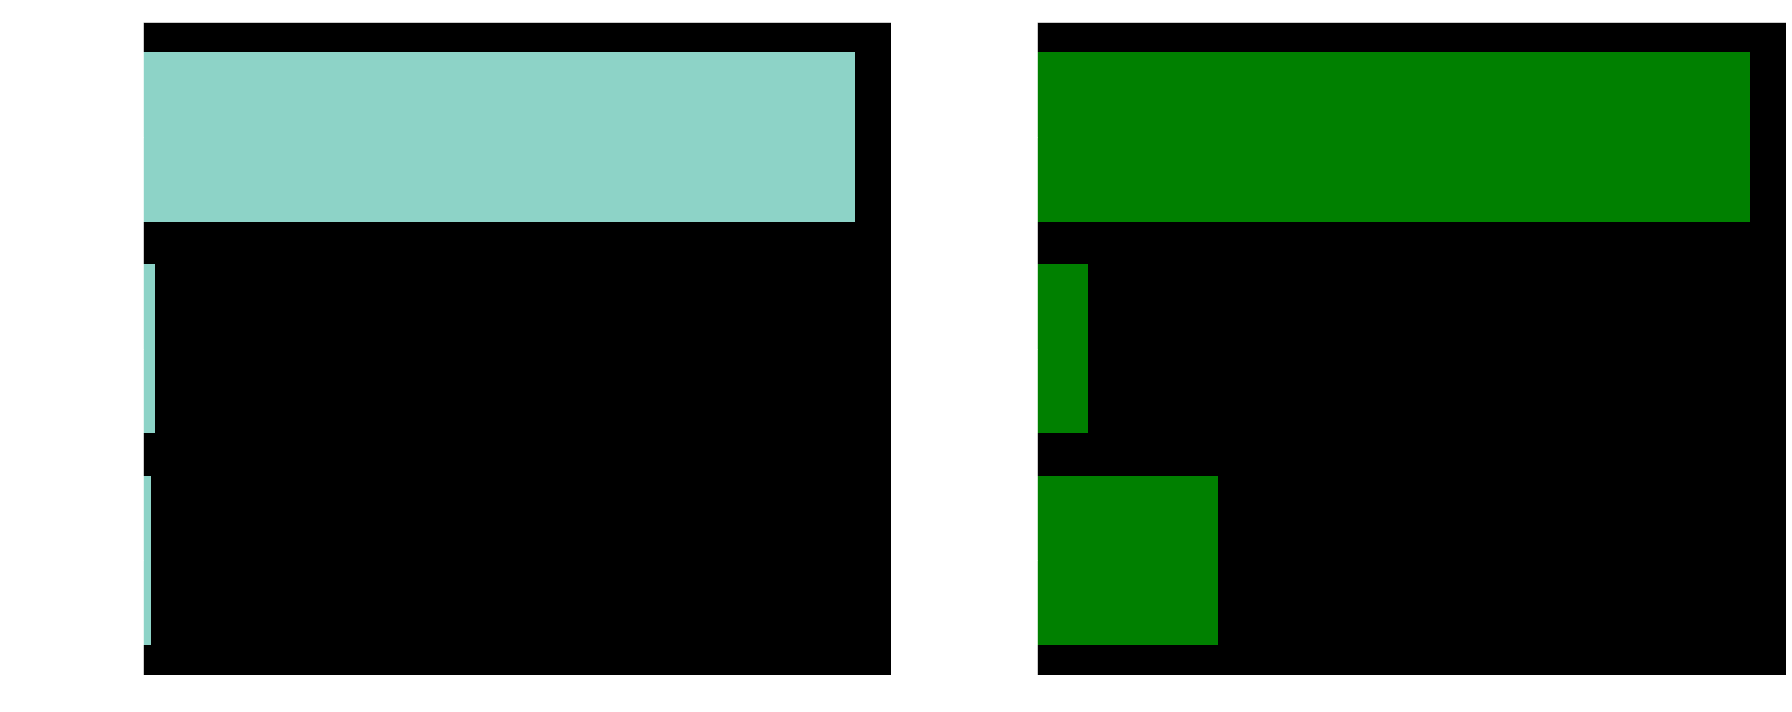

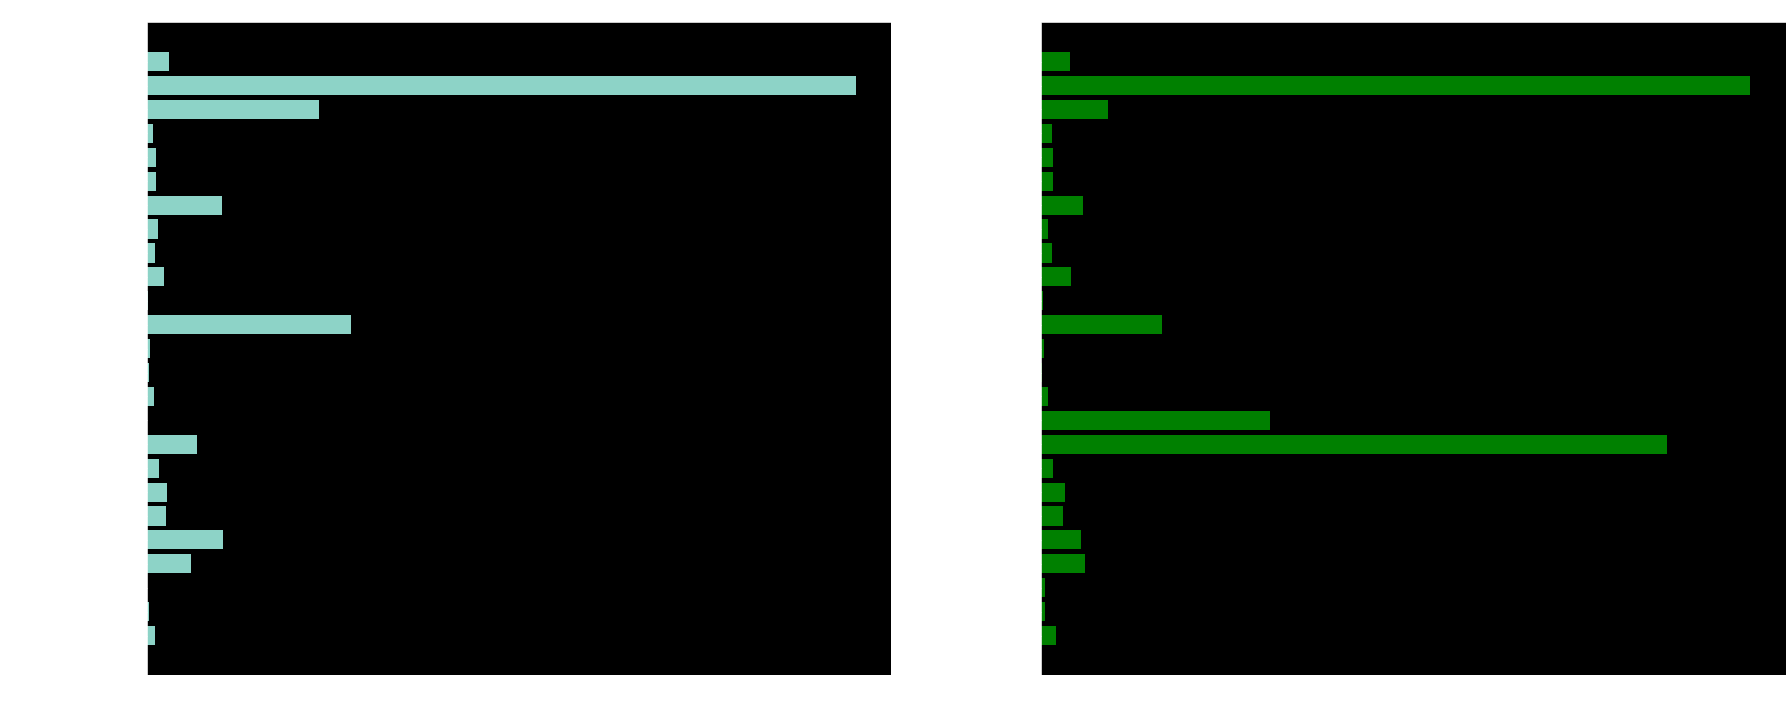

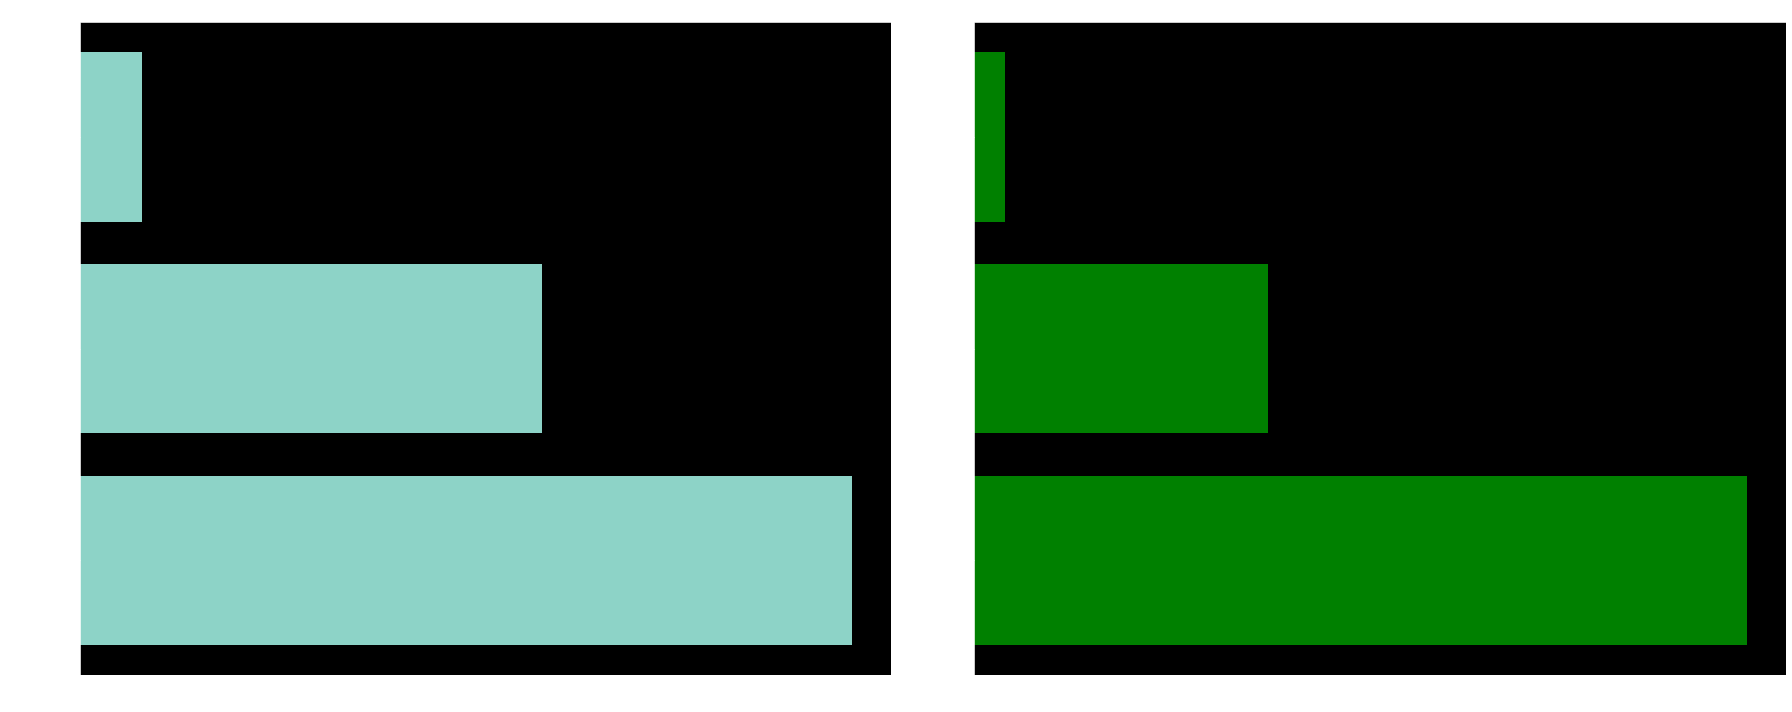

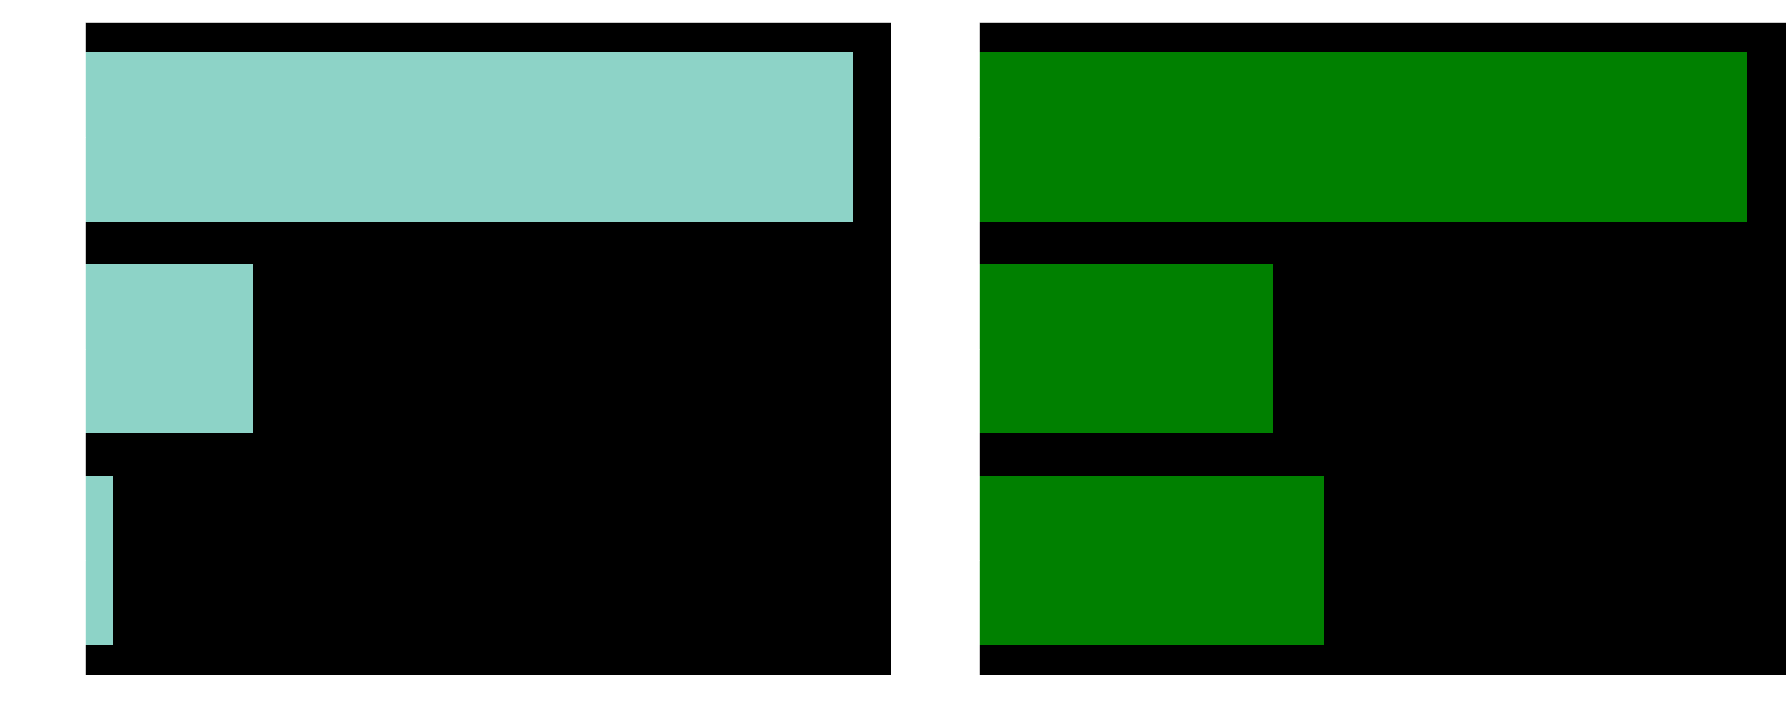

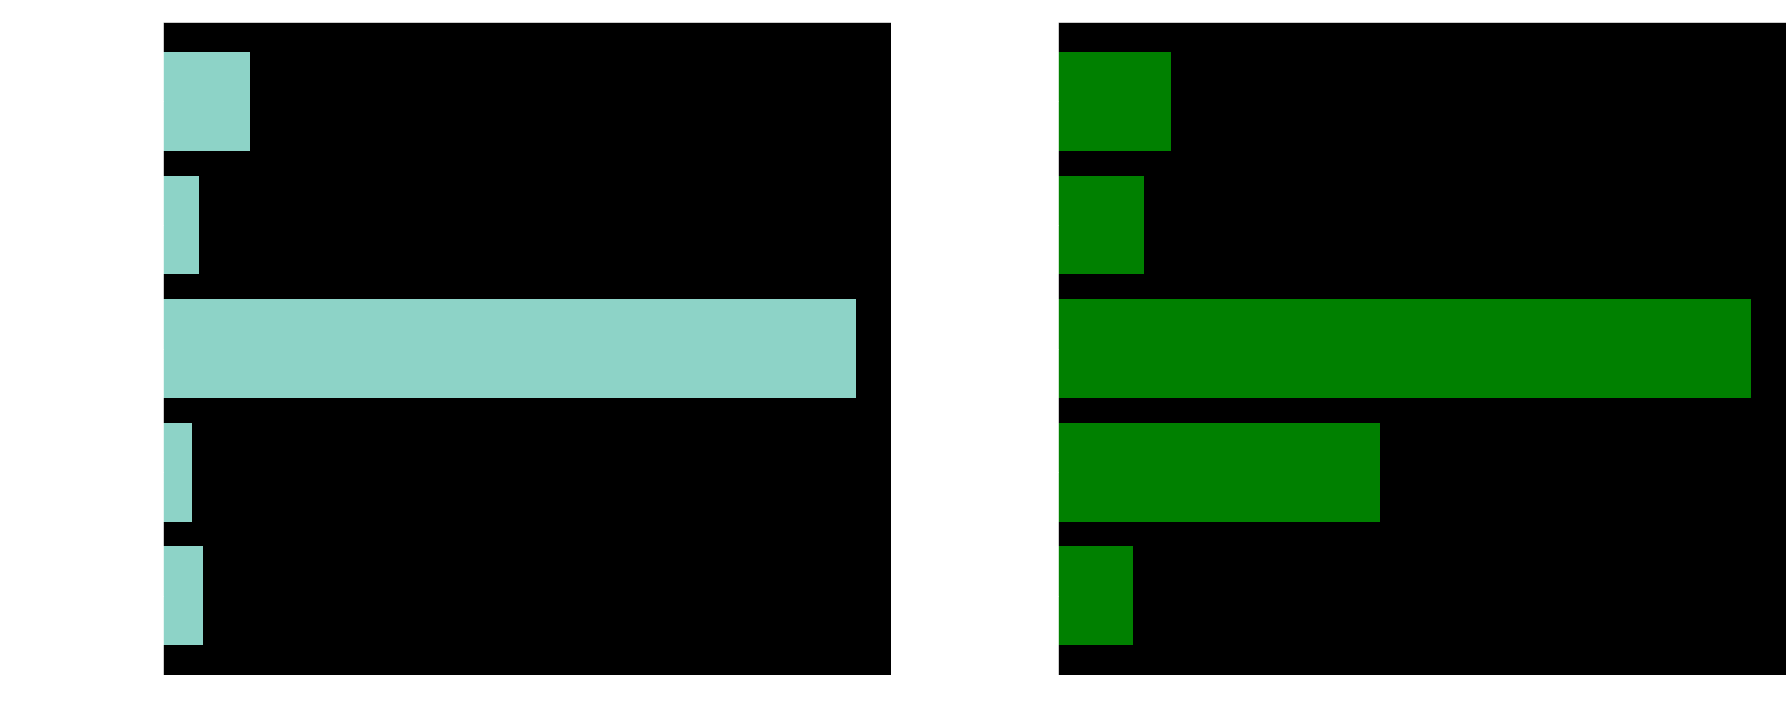

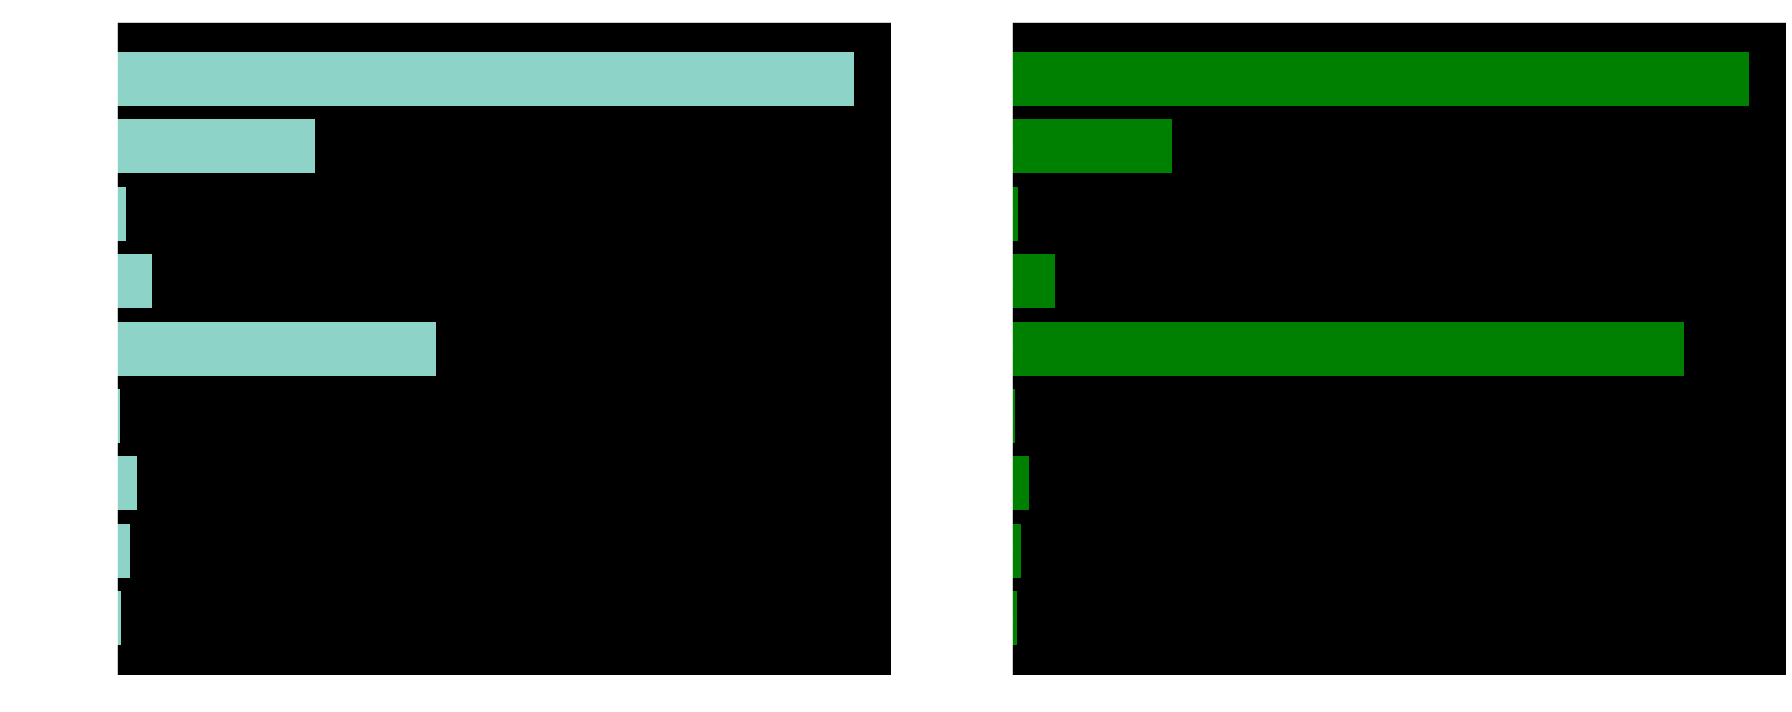

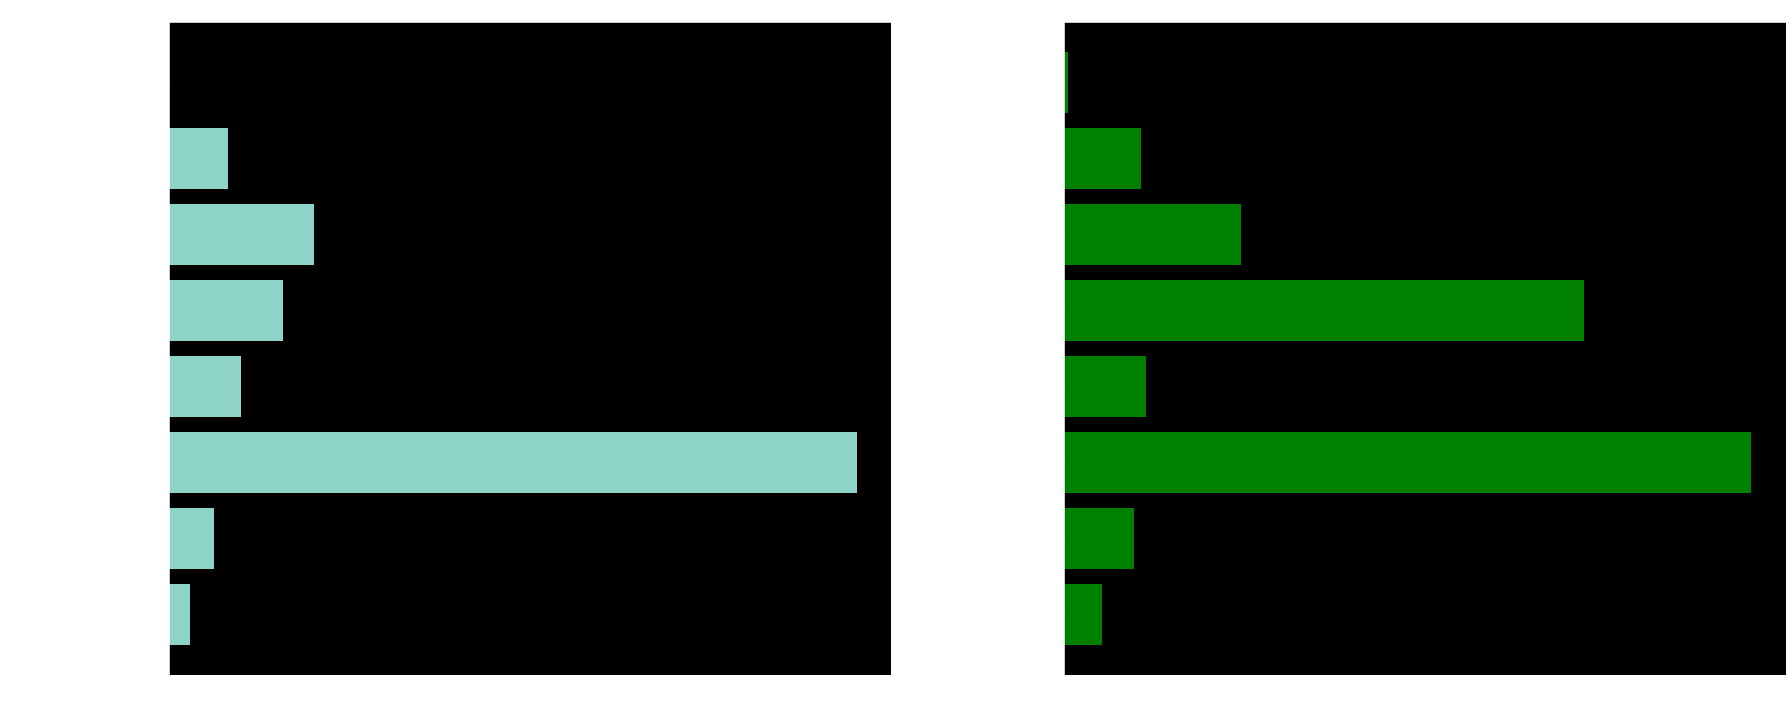

In [31]:
for label in LABELS:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

    fte = df.groupby(label).FTE.sum()
    #fte.plot(kind='bar')
    axes[0].barh(fte.index, fte)
    axes[0].set_title('Full Time Equivalent per ' + label)
    axes[0].set_ylabel('Headcount')
    
    total = df.groupby(label).Total.sum()
    #total.plot(kind='bar', color='green')
    axes[1].barh(total.index, total, color='green')
    axes[1].set_title('Total cost of the expenditure per ' + label)
    axes[1].set_ylabel('Cost')
    # axes[1].set_yticks([])
    plt.tight_layout()
    plt.show()    

## Free text form variables

Cross value counts helper function

In [32]:
def cross_value_counts(df):
    #cvc = df.replace('(\s+|[^\w+])',' ',regex=True)#.apply(lambda x: x.str.strip())
    cvc = df.replace('[^\w]+',' ',regex=True).apply(lambda x: x.str.strip().str.upper())
    cvc = cvc.apply(lambda x: x.value_counts(dropna=False)).fillna(0)
    cvc = cvc.apply(pd.to_numeric, downcast='unsigned')
    cvc.index.name = 'text'
    cvc.columns.name = 'columns'
    cvc.index = cvc.index.fillna('NaN')
    decreasing_row_index = cvc.sum(axis=1).sort_values(ascending=False).index
    decreasing_col_index = cvc.sum(axis=0).sort_values(ascending=False).index
    cvc = cvc.loc[decreasing_row_index, decreasing_col_index]
    return cvc

def cross_value_counts_summary(df):

    percent_with_nan = lambda x: x.sum() / (df.shape[0] * df.shape[1]) * 100
    cvc = cross_value_counts(df).replace(0, np.nan)
    cvcs = cvc.agg(['sum', 'count', percent_with_nan], axis='columns')
    cvcs.index.name = 'text'
    cvcs.columns=['Ocurrences', 'Columns', '% w/NaN']

    saved = cvcs.loc['NaN','Ocurrences']
    cvcs.loc['NaN','Ocurrences'] = np.nan
    cvcs['% wo/NaN'] = (cvcs.Ocurrences / cvcs.Ocurrences.sum() * 100).fillna(0)
    cvcs['Cumulated % wo/NaN'] = cvcs['% wo/NaN'].cumsum()
    cvcs.loc['NaN','Ocurrences'] = saved
    cvcs['words'] = cvcs.index.str.split().map(len).tolist()

    cvcs = cvcs.apply(pd.to_numeric, downcast='float')
    cvcs = cvcs.apply(pd.to_numeric, downcast='unsigned')

    return cvcs

### Text features frequencies

In [33]:
cross_value_counts(df[TEXT_FEATURES])

columns                         Object_Description  Text_2  \
text                                                         
NaN                                          24784  312060   
GENERAL FUND                                     0       0   
EMPLOYEE BENEFITS                            47495      54   
REGULAR                                       9270       0   
PROFESSIONAL INSTRUCTIONAL                       0       0   
...                                            ...     ...   
TEACHER TECHNOLOGY                               0       0   
TUTOR TEMPORARY                                  0       0   
ED PROG SPECIALIST                               0       0   
HAZARDOUS MATERIALS SPECIALIST                   0       0   
BGA GESP SLHS DEMND CVN                          0       0   

columns                         SubFund_Description  Job_Title_Description  \
text                                                                         
NaN                                           93422                 107534   
GENERAL FUND                                 123327                      0   
EMPLOYEE BENEFITS                                 0                      0   
REGULAR                                           0                      0   
PROFESSIONAL INSTRUCTIONAL                        0                      0   
...                                             ...                    ...   
TEACHER TECHNOLOGY                                0                      1   
TUTOR TEMPORARY                                   0                      1   
ED PROG SPECIALIST                                0                      1   
HAZARDOUS MATERIALS SPECIALIST                    0                      1   
BGA GESP SLHS DEMND CVN                           0                      0   

columns                         Text_3  Text_4  Sub_Object_Description  \
text                                                                     
NaN                             291125  346531                  308674   
GENERAL FUND                         0       0                       0   
EMPLOYEE BENEFITS                    0       0                       0   
REGULAR                          94462       0                       0   
PROFESSIONAL INSTRUCTIONAL           0       0                       0   
...                                ...     ...                     ...   
TEACHER TECHNOLOGY                   0       0                       0   
TUTOR TEMPORARY                      0       0                       0   
ED PROG SPECIALIST                   0       0                       0   
HAZARDOUS MATERIALS SPECIALIST       0       0                       0   
BGA GESP SLHS DEMND CVN              0       0                       0   

columns                         Location_Description  Function_Description  \
text                                                                         
NaN                                           238223                 58082   
GENERAL FUND                                       0                     0   
EMPLOYEE BENEFITS                                 83                    54   
REGULAR                                            0                     0   
PROFESSIONAL INSTRUCTIONAL                         0                     0   
...                                              ...                   ...   
TEACHER TECHNOLOGY                                 0                     0   
TUTOR TEMPORARY                                    0                     0   
ED PROG SPECIALIST                                 0                     0   
HAZARDOUS MATERIALS SPECIALIST                     0                     0   
BGA GESP SLHS DEMND CVN                            0                     0   

columns                         Facility_or_Department  Position_Extra  \
text                                                                     
NaN                                             3463

### Text features frequency summary

In [34]:
df_cvcs = cross_value_counts_summary(df[TEXT_FEATURES])
df_cvcs.head(60)

Ocurrences  Columns  \
text                                                                      
NaN                                                    2663348       14   
GENERAL FUND                                            180539        2   
EMPLOYEE BENEFITS                                       113024        6   
REGULAR                                                 103732        2   
PROFESSIONAL INSTRUCTIONAL                               92136        1   
REGULAR INSTRUCTION                                      78783        4   
NON PROJECT                                              76890        1   
SCHOOL                                                   65524        1   
UNDESIGNATED                                             49569        4   
INSTRUCTION                                              39999        1   
TEACHER ELEMENTARY                                       33666        1   
GENERAL OPERATING FUND                                   33467        1   
GENERAL ELEMENTARY EDUCATION                             32829        1   
SALARIES OF PART TIME EMPLOYEE                           31761        1   
UNDISTRIBUTED                                            30962        3   
INSTRUCTIONAL STAFF                                      30592        1   
OPERATIONS                                               28493        5   
SALARIES AND WAGES FOR TEACHERS AND OTHER PROFESSI       25917        2   
SALARIES OF REGULAR EMPLOYEES                            24319        1   
TEACHER SHORT TERM SUB                                   23450        1   
INSTRUCTIONAL STAFF TRAINING                             21521        1   
SPECIAL EDUCATION                                        20868        8   
GENERAL PURPOSE SCHOOL                                   20333        1   
TITLE I DISADVANTAGED CHILDREN TARGETED ASSISTANCE       19967        1   
CONTRA BENEFITS                                          19381        1   
REGULAR PAY                                              18609        1   
EXTRA DUTY PAY OVERTIME FOR SUPPORT PERSONNEL            18318        2   
ALL CAMPUS PAYROLL                                       17697        1   
ADDITIONAL EXTRA DUTY PAY STIP                           16841        1   
SUPPLIES                                                 16749        3   
UNALLOC BUDGETS SCHOOLS                                  16616        1   
TEACHER SUBS                                             16599        1   
BLANK                                                    15298        4   
INSTRUCTION AND CURRICULUM                               14537        1   
GENERAL SUPPLIES                                         14375        3   
INSTRUCTION REGULAR                                      13825        1   
FEDERAL GDPG FUND FY                                     13562        1   
TRANSPORTATION                                           13541        8   
BASIC FEFP K 12                                          13317        1   
MISC                                                     13148        3   
EMPLOYEE RETIREMENT                                      13073        1   
RETIREMENT CONTRIB                                       13073        1   
CRAFTS TRADES AND SERVICES                               13015        1   
PARAPROFESSIONAL                                         12649        2   
TITLE PART A IMPROVING BASIC PROGRAMS                    12145        2   
TEACHER BACHELOR                                         11875        1   
TEACHER                                                  11864        3   
SALARIES OR WAGES FOR SUPPORT PERSONNEL                  10714        2   
GENERAL HIGH SCHOOL EDUCATION                            10625        1   
BASIC EDUCATIONAL SERVICES                               10593        1   
MISCELLANEOUS                                            10329        3   
PRIMARY GRADES PROGRAM                                   10314        2   
SU

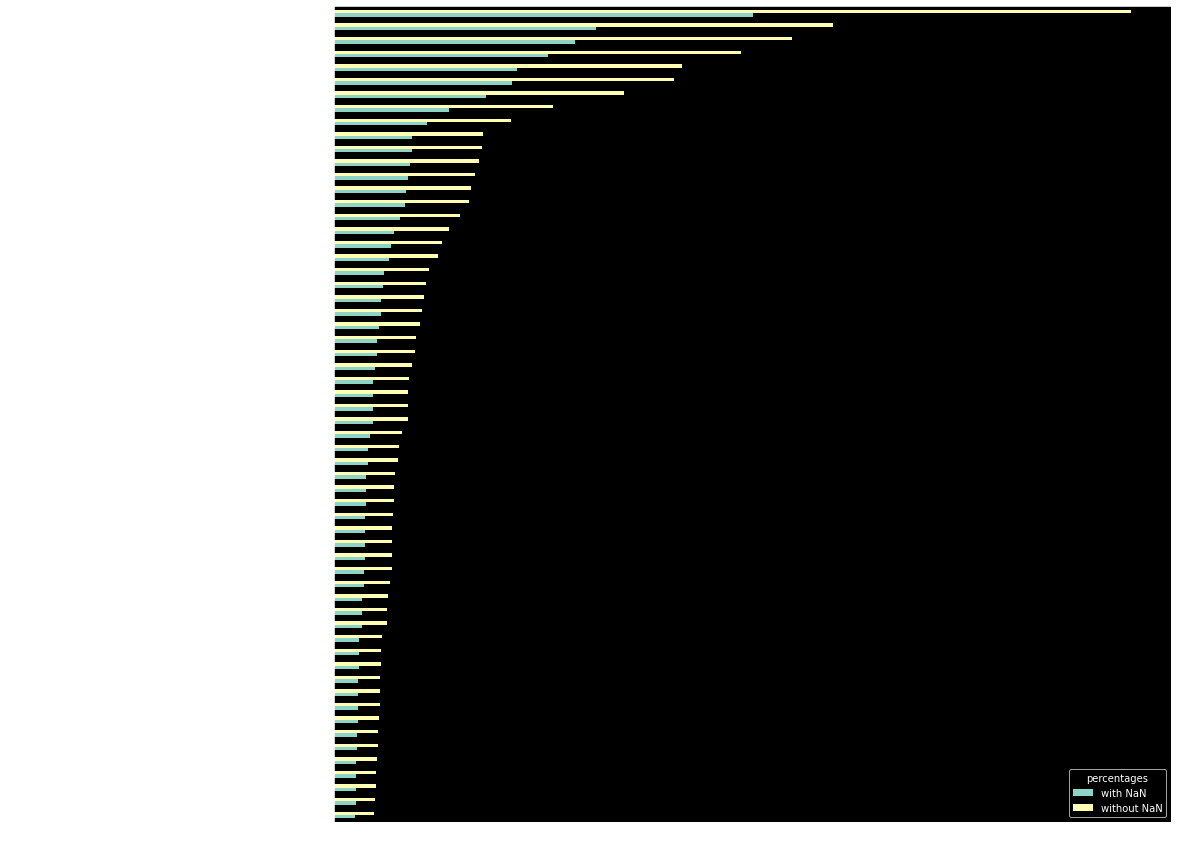

In [35]:
cvcs = pd.concat({'with NaN': df_cvcs['% w/NaN'].drop('NaN'),
                  'without NaN': df_cvcs['% wo/NaN'].drop('NaN')},
                 axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
cvcs.index.name='text'
cvcs.columns.name='percentages'
cvcs.tail(60).plot(kind='barh', stacked=False, figsize=(15, 15))
plt.xlabel('percentages (%)')
plt.show()

## Categorical variables

### Unique classes per label

In [36]:
num_unique_labels = df[LABELS].apply(pd.Series.nunique)
print(num_unique_labels)
print('            Total:',num_unique_labels.sum())

Function            37
Object_Type         11
Operating_Status     3
Position_Type       25
Pre_K                3
Reporting            3
Sharing              5
Student_Type         9
Use                  8
dtype: int64
            Total: 104


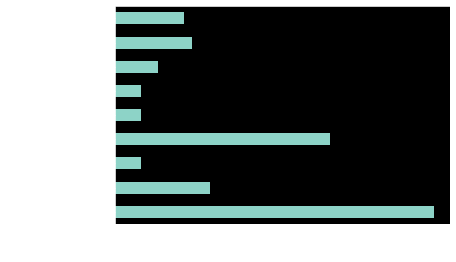

In [37]:
num_unique_labels.plot(kind='barh')
plt.xlabel('Number of unique values')
plt.ylabel('Labels')
plt.show()

### Encoding labels as categories to optimize memory and performance

In [38]:
#Converting label columns to category type
print('Memory before encoding: {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after encoding : {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))

Memory before encoding: 87.5 MB (556.6 MB deep)
Memory after encoding : 63.4 MB (321.0 MB deep)


### Observations per groups of labels

[Grouping by categoricals will show unused categories](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html?highlight=groupby%20sum#operations)

Those can avoided by using `observed=True`

In [39]:
# label_group = df.groupby(LABELS).size()[lambda x: x>0].sort_values().to_frame('observations')
label_group = df.groupby(LABELS, observed=True).size().sort_values().to_frame('observations')
label_group

observations
Function                     Object_Type              Operating_Status  Position_Type Pre_K    Reporting  Sharing                 Student_Type      Use                                      
Career & Academic Counseling Contracted Services      PreK-12 Operating NO_LABEL      Non PreK Non-School Shared Services         At Risk           Pupil Services & Enrichment             1
Student Assignment           Travel & Conferences     PreK-12 Operating NO_LABEL      NO_LABEL Non-School Leadership & Management Special Education Leadership                              1
Library & Media              Benefits                 PreK-12 Operating Other         Non PreK School     School Reported         Special Education Instruction                             1
Professional Development     Travel & Conferences     PreK-12 Operating Non-Position  NO_LABEL Non-School Shared Services         Poverty           ISPD                                    1
Curriculum Development       Base Salary/Compensation PreK-12 Operating TA            NO_LABEL Non-School Leadership & Management ELL               ISPD                                    1
...                                                                                                                                                                                       ...
Teacher Compensation         Base Salary/Compensation PreK-12 Operating Teacher       NO_LABEL School     School Reported         Unspecified       Instruction                         13551
Substitute Compensation      Benefits                 PreK-12 Operating Substitute    NO_LABEL School     School Reported         Unspecified       Instruction                         14110
                             Base Salary/Compensation PreK-12 Operating Substitute    NO_LABEL School     School Reported         Unspecified       Instruction                         16130
Teacher Compensation         Benefits                 PreK-12 Operating Teacher       NO_LABEL School     School Reported         Unspecified       Instruction                         22169
NO_LABEL                     NO_LABEL                 Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL                NO_LABEL          NO_LABEL                            48034

[5489 rows x 1 columns]

### Groups of labels with less than 2 samples (unsplittable)

In [40]:
label_group.loc[label_group.observations < 2,:]

observations
Function                               Object_Type                 Operating_Status  Position_Type       Pre_K    Reporting  Sharing                   Student_Type      Use                                      
Career & Academic Counseling           Contracted Services         PreK-12 Operating NO_LABEL            Non PreK Non-School Shared Services           At Risk           Pupil Services & Enrichment             1
Student Assignment                     Travel & Conferences        PreK-12 Operating NO_LABEL            NO_LABEL Non-School Leadership & Management   Special Education Leadership                              1
Library & Media                        Benefits                    PreK-12 Operating Other               Non PreK School     School Reported           Special Education Instruction                             1
Professional Development               Travel & Conferences        PreK-12 Operating Non-Position        NO_LABEL Non-School Shared Services           Poverty           ISPD                                    1
Curriculum Development                 Base Salary/Compensation    PreK-12 Operating TA                  NO_LABEL Non-School Leadership & Management   ELL               ISPD                                    1
...                                                                                                                                                                                                            ...
Data Processing & Information Services Other Compensation/Stipend  PreK-12 Operating Instructional Coach NO_LABEL School     School Reported           Poverty           Business Services                       1
Research & Accountability              Contracted Services         PreK-12 Operating NO_LABEL            Non PreK Non-School Shared Services           Unspecified       Leadership                              1
Other Non-Compensation                 Equipment & Equipment Lease PreK-12 Operating Non-Position        NO_LABEL Non-School Shared Services           Special Education Instruction                             1
Facilities & Maintenance               Supplies/Materials          PreK-12 Operating Non-Position        PreK     Non-School School on Central Budgets PreK              O&M                                     1
Career & Academic Counseling           Base Salary/Compensation    PreK-12 Operating Teacher             NO_LABEL Non-School Leadership & Management   Unspecified       Pupil Services & Enrichment             1

[1414 rows x 1 columns]

### Converting labels in dummy variables

Double underscore conventioned by the competition

In [41]:
# Converting labels in dummy variables
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
dummy_labels

Function__Aides Compensation  Function__Career & Academic Counseling  \
134338                             0                                       0   
206341                             0                                       0   
326408                             0                                       0   
364634                             0                                       0   
47683                              0                                       0   
...                              ...                                     ...   
109283                             0                                       0   
102430                             0                                       0   
413949                             0                                       0   
433672                             0                                       0   
415831                             0                                       0   

        Function__Communications  Function__Curriculum Development  \
134338                         0                                 0   
206341                         0                                 0   
326408                         0                                 0   
364634                         0                                 0   
47683                          0                                 0   
...                          ...                               ...   
109283                         0                                 0   
102430                         0                                 0   
413949                         0                                 0   
433672                         0                                 0   
415831                         0                                 0   

        Function__Data Processing & Information Services  \
134338                                                 0   
206341                                                 0   
326408                                                 0   
364634                                                 0   
47683                                                  0   
...                                                  ...   
109283                                                 0   
102430                                                 0   
413949                                                 0   
433672                                                 0   
415831                                                 0   

        Function__Development & Fundraising  Function__Enrichment  \
134338                                    0                     0   
206341                                    0                     0   
326408                                    0                     0   
364634                                    0                     0   
47683                                     0                     0   
...                                     ...                   ...   
109283                                    0                     0   
102430                                    0                     0   
413949                                    0                     0   
433672                                    0                     0   
415831                                    0                     0   

        Function__Extended Time & Tutoring  \
134338                                   0   
206341                                   0   
326408                                   0   
364634                                   0   
47683                                    0   
...                                    ...   
109283                                   0   
102430                                   0   
413949                                   0   
433672                                   0   
415831                                   0   

        Function__Facilities & Maintenance  Function__Facilities Planning  \
134338                    

### Class count

In [42]:
dummy_labels.sum().sort_values()

Function__Facilities Planning              29
Function__Insurance                        57
Function__Development & Fundraising        93
Position_Type__Nurse Aide                  95
Function__Legal                           117
                                        ...  
Student_Type__Unspecified              223026
Sharing__School Reported               254433
Reporting__School                      257258
Pre_K__NO_LABEL                        306425
Operating_Status__PreK-12 Operating    343578
Length: 104, dtype: int64

### Class proportions

In [43]:
dummy_labels.mean().sort_values()

Function__Facilities Planning          0.000072
Function__Insurance                    0.000142
Function__Development & Fundraising    0.000232
Position_Type__Nurse Aide              0.000237
Function__Legal                        0.000292
                                         ...   
Student_Type__Unspecified              0.557179
Sharing__School Reported               0.635642
Reporting__School                      0.642700
Pre_K__NO_LABEL                        0.765532
Operating_Status__PreK-12 Operating    0.858351
Length: 104, dtype: float64

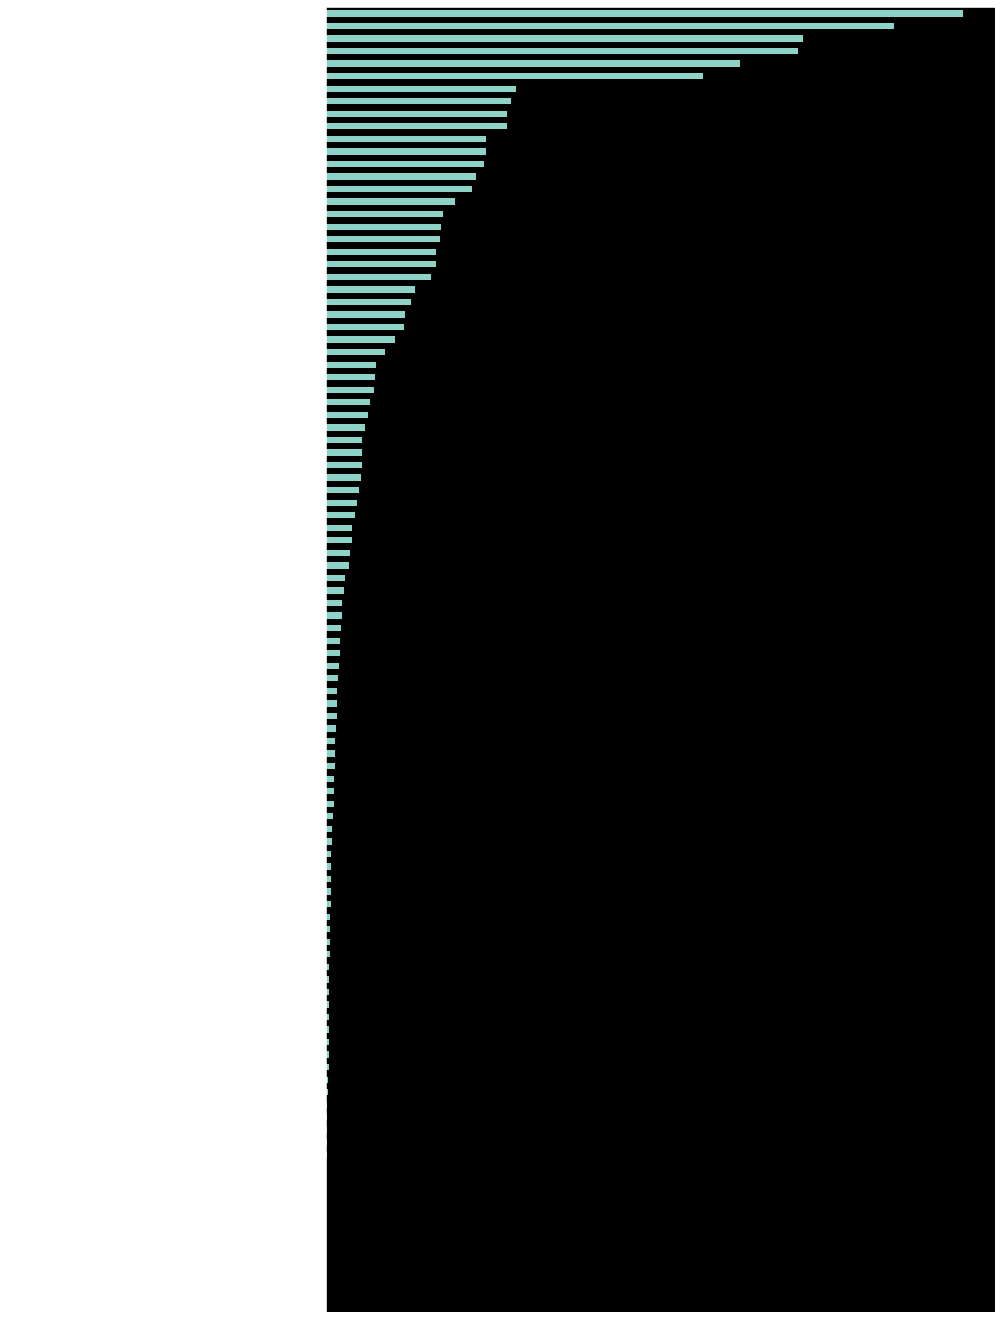

In [44]:
dummy_labels.mean().sort_values().plot(kind='barh', figsize=(12,24)); plt.show()

# Exploring holdout data

In [45]:
holdout=pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)
holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50064 entries, 180042 to 249087
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Object_Description      48330 non-null  object 
 1   Program_Description     44811 non-null  object 
 2   SubFund_Description     16111 non-null  object 
 3   Job_Title_Description   32317 non-null  object 
 4   Facility_or_Department  2839 non-null   object 
 5   Sub_Object_Description  33612 non-null  object 
 6   Location_Description    37316 non-null  object 
 7   FTE                     19605 non-null  float64
 8   Function_Description    46866 non-null  object 
 9   Position_Extra          13813 non-null  object 
 10  Text_4                  2814 non-null   object 
 11  Total                   49404 non-null  float64
 12  Text_2                  4641 non-null   object 
 13  Text_3                  5784 non-null   object 
 14  Fund_Description        39586 no

This holdout dataset has no labels due to the secrecy of the competition, but let's compare de column alignments:

In [46]:
FEATURES

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [47]:
display(list(zip(FEATURES, holdout.columns.values)))
all(FEATURES == holdout.columns.values)

[('Object_Description', 'Object_Description'),
 ('Text_2', 'Program_Description'),
 ('SubFund_Description', 'SubFund_Description'),
 ('Job_Title_Description', 'Job_Title_Description'),
 ('Text_3', 'Facility_or_Department'),
 ('Text_4', 'Sub_Object_Description'),
 ('Sub_Object_Description', 'Location_Description'),
 ('Location_Description', 'FTE'),
 ('FTE', 'Function_Description'),
 ('Function_Description', 'Position_Extra'),
 ('Facility_or_Department', 'Text_4'),
 ('Position_Extra', 'Total'),
 ('Total', 'Text_2'),
 ('Program_Description', 'Text_3'),
 ('Fund_Description', 'Fund_Description'),
 ('Text_1', 'Text_1')]

False

**Columns between these datasets were not aligned until here:**

In [48]:
holdout = holdout[FEATURES]
all(FEATURES == holdout.columns.values)

True

## Missing data **(TODO: replicate df stats)**

Overall count and proportion of missing data compared to training data:

In [49]:
missing_holdout = holdout.isnull()
pd.DataFrame({'dataset':  ['training', 'holdout'],
              'missing':    [missing.sum().sum(), missing_holdout.sum().sum()],
              'proportion': [missing.sum().sum() / (missing.shape[0] * missing.shape[1]),
                             missing_holdout.sum().sum() / (holdout.shape[0] * holdout.shape[1])]}).set_index('dataset')

missing  proportion
dataset                      
training  2942109    0.294007
holdout    387797    0.484127

**The proportion of missing data in the holdout set is much bigger.**

Comparing missing heatmaps between datasets

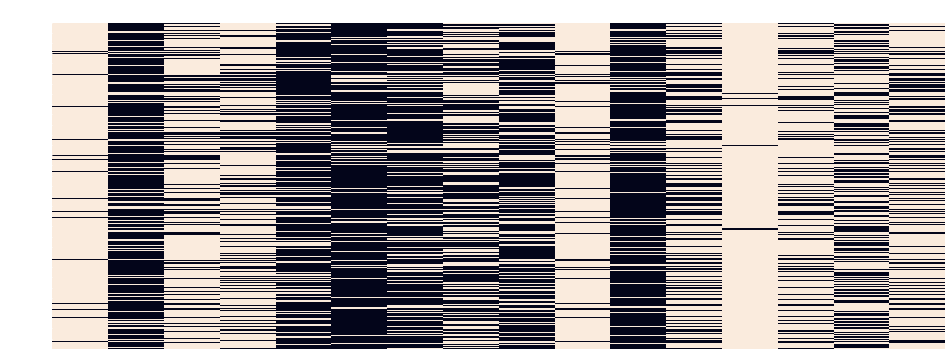

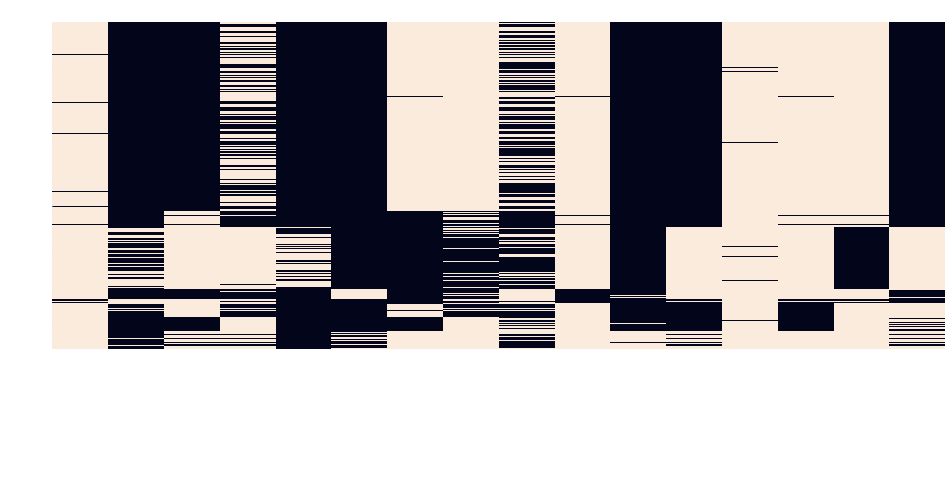

In [50]:
plt.figure(figsize=(16,6))
sns.heatmap(~missing[FEATURES], cbar=False, xticklabels=False)
plt.title('Training set')
plt.figure(figsize=(16,6))
sns.heatmap(~missing_holdout, cbar=False)
plt.title('Holdout set')
plt.show()

Comparing the heatmaps became suspect that the holdout dataset is not just a fair random sample because it's missing data pattern differs a lot from the training dataset.

Next, the columns of both datasets are ordered by the columns of training set with less missing data first. The idea is to compare some sort of missing proportion clusters.

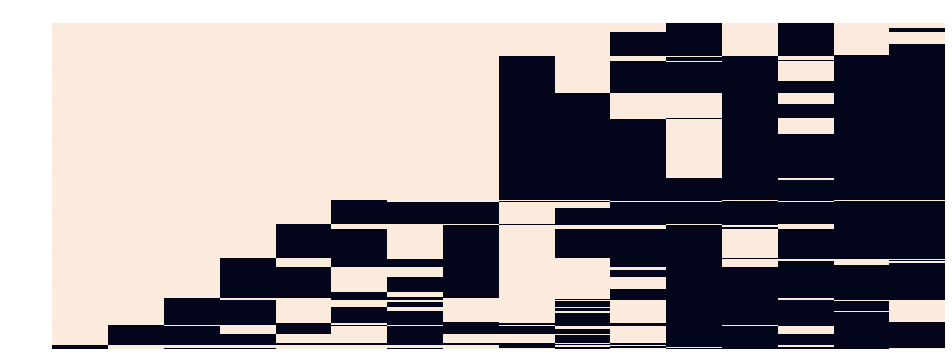

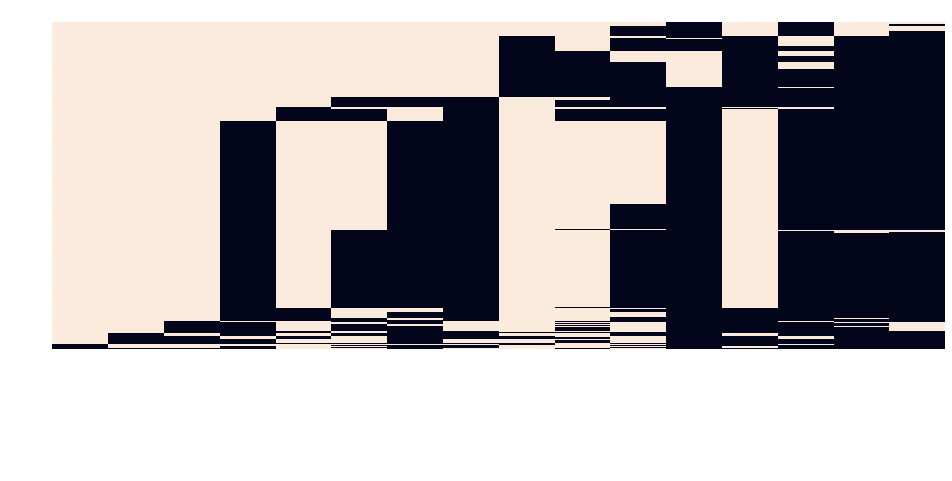

In [51]:
freq_col_order = missing[FEATURES].sum().sort_values().index.to_list()
plt.figure(figsize=(16,6))
sns.heatmap(~missing[freq_col_order].sort_values(freq_col_order), cbar=False, xticklabels=False)
plt.title('Training set')
plt.figure(figsize=(16,6))
sns.heatmap(~missing_holdout[freq_col_order].sort_values(freq_col_order), cbar=False)
plt.title('Holdout set')
plt.show()

Some missing value areas are proportionally bigger in the holdout set, which is confirmed by the missing ratio which differs a lot.

In [52]:
(missing_report(holdout)['column proportion'] / missing_report(df[FEATURES])['column proportion']).sort_values(ascending=False)

SubFund_Description       2.905789
Text_1                    2.568016
Position_Extra            2.138819
Job_Title_Description     1.319515
Text_3                    1.216083
Text_2                    1.163785
Total                     1.158486
Text_4                    1.090171
Facility_or_Department    1.090035
FTE                       0.888124
Object_Description        0.559388
Function_Description      0.440222
Program_Description       0.439246
Location_Description      0.427852
Sub_Object_Description    0.426141
Fund_Description          0.424391
Name: column proportion, dtype: float64

## FTE

In [53]:
holdout.FTE.describe()

count    1.960500e+04
mean     1.349004e+00
std      8.468634e+01
min     -1.917398e-07
25%      5.000000e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.185724e+04
Name: FTE, dtype: float64

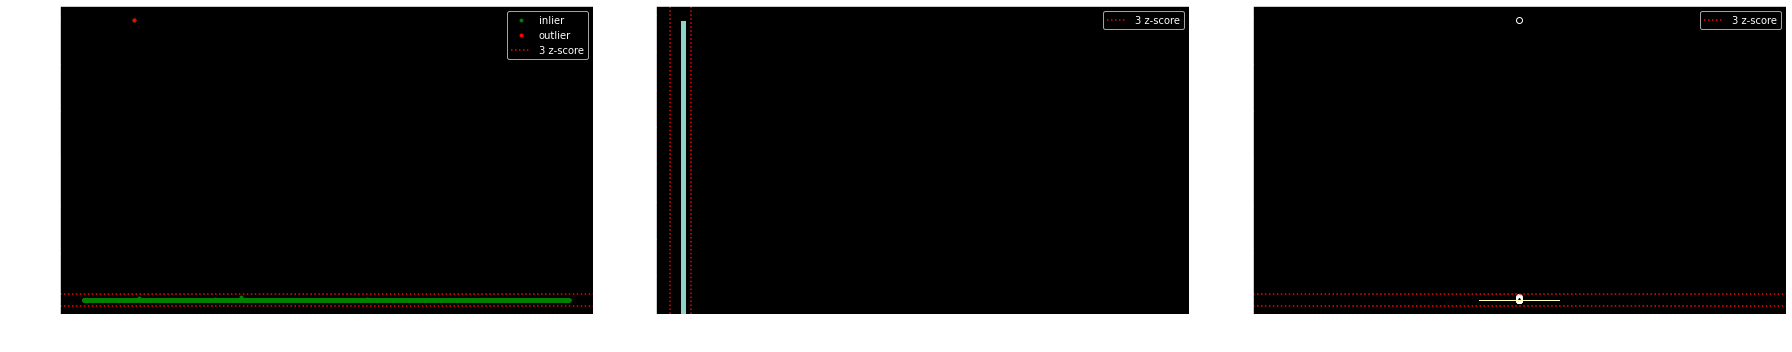

Upper outliers: 1
Lower outliers: 0


In [54]:
fte = holdout.FTE.dropna()
density_plots(fte, 'FTE', bins=100)
zscores = zscore(fte)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has only one `FTE` outlier with a value never seen so high in the whole training set: near `11857.24`, while the max `FTE` in training set is `46.8`.

This specific outlier has not textual data.

In [55]:
holdout[holdout.FTE == holdout.FTE.max()].transpose()

46063
Object_Description                NaN
Text_2                            NaN
SubFund_Description               NaN
Job_Title_Description             NaN
Text_3                            NaN
Text_4                            NaN
Sub_Object_Description            NaN
Location_Description              NaN
FTE                       11857.24475
Function_Description              NaN
Facility_or_Department            NaN
Position_Extra                    NaN
Total                   1153578234.84
Program_Description               NaN
Fund_Description                  NaN
Text_1                            NaN

Searching for other observations with no textual data:

In [56]:
holdout[holdout[TEXT_FEATURES].isnull().all(axis=1)]

Object_Description Text_2 SubFund_Description Job_Title_Description  \
46063                 NaN    NaN                 NaN                   NaN   
71261                 NaN    NaN                 NaN                   NaN   
230738                NaN    NaN                 NaN                   NaN   
222040                NaN    NaN                 NaN                   NaN   
42179                 NaN    NaN                 NaN                   NaN   
...                   ...    ...                 ...                   ...   
209320                NaN    NaN                 NaN                   NaN   
90738                 NaN    NaN                 NaN                   NaN   
143636                NaN    NaN                 NaN                   NaN   
433295                NaN    NaN                 NaN                   NaN   
380424                NaN    NaN                 NaN                   NaN   

       Text_3 Text_4 Sub_Object_Description Location_Description          FTE  \
46063     NaN    NaN                    NaN                  NaN  11857.24475   
71261     NaN    NaN                    NaN                  NaN          NaN   
230738    NaN    NaN                    NaN                  NaN          NaN   
222040    NaN    NaN                    NaN                  NaN          NaN   
42179     NaN    NaN                    NaN                  NaN          NaN   
...       ...    ...                    ...                  ...          ...   
209320    NaN    NaN                    NaN                  NaN          NaN   
90738     NaN    NaN                    NaN                  NaN          NaN   
143636    NaN    NaN                    NaN                  NaN          NaN   
433295    NaN    NaN                    NaN                  NaN          NaN   
380424    NaN    NaN                    NaN                  NaN          NaN   

       Function_Description Facility_or_Department Position_Extra  \
46063                   NaN                    NaN            NaN   
71261                   NaN                    NaN            NaN   
230738                  NaN                    NaN            NaN   
222040                  NaN                    NaN            NaN   
42179                   NaN                    NaN            NaN   
...                     ...                    ...            ...   
209320                  NaN                    NaN            NaN   
90738                   NaN                    NaN            NaN   
143636                  NaN                    NaN            NaN   
433295                  NaN                    NaN            NaN   
380424                  NaN                    NaN            NaN   

               Total Program_Description Fund_Description Text_1  
46063   1.153578e+09                 NaN              NaN    NaN  
71261            NaN                 NaN              NaN    NaN  
230738           NaN                 NaN              NaN    NaN  
222040  8.398000e+01                 NaN              NaN    NaN  
42179   6.182400e+03                 NaN              NaN    NaN  
...              ...                 ...              ...    ...  
209320  5.861900e+03                 NaN              NaN    NaN  
90738   2.738370e+03                 NaN              NaN    NaN  
143636  1.427740e+03                 NaN              NaN    NaN  
433295  4.452000e+01                 NaN              NaN    NaN  
380424  6.099440e+03                 NaN              NaN    NaN  

[116 rows x 16 columns]

There are 116 other observations without textual data.

## Total

In [57]:
holdout.Total.describe()

count    4.940400e+04
mean     5.115880e+04
std      5.228060e+06
min     -2.370180e+06
25%      2.992925e+02
50%      2.743975e+03
75%      3.341465e+04
max      1.153578e+09
Name: Total, dtype: float64

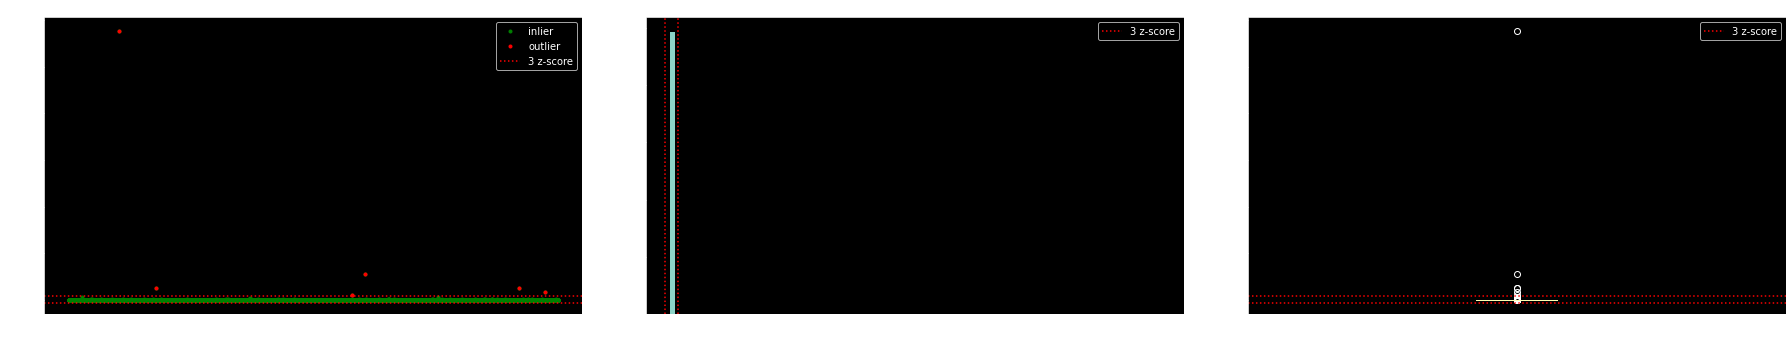

Upper outliers: 6
Lower outliers: 0


In [58]:
total = holdout.Total.dropna()
density_plots(total, 'Total', bins=100)
zscores = zscore(total)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has a huge Total outlier close to 1.2 billion while the max in training is 129 million and in fact, this `Total` outlier is the same as the `FTE` outlier.

In [59]:
holdout[holdout.Total == holdout.Total.max()].transpose()

46063
Object_Description                NaN
Text_2                            NaN
SubFund_Description               NaN
Job_Title_Description             NaN
Text_3                            NaN
Text_4                            NaN
Sub_Object_Description            NaN
Location_Description              NaN
FTE                       11857.24475
Function_Description              NaN
Facility_or_Department            NaN
Position_Extra                    NaN
Total                   1153578234.84
Program_Description               NaN
Fund_Description                  NaN
Text_1                            NaN

## Free text form variables

### Text features frequencies

In [60]:
cross_value_counts(holdout[TEXT_FEATURES])

columns                         Object_Description  Text_2  \
text                                                         
NaN                                           1734   45423   
GENERAL FUND                                     0       0   
SCHOOL                                           0       0   
GENERAL                                          1       0   
INSTRUCTION                                      0       0   
...                                            ...     ...   
TCHER BEHAVIOR MODIF MIDDLE                      0       0   
MEDIA SVCS SPEC                                  0       0   
TCHER SPEC ED MID SATELLITE                      0       0   
STIM FUND GRADUATION COACH                       0       0   
FOOD SERVICE MANAGER INCENTIVE                   0       0   

columns                         SubFund_Description  Job_Title_Description  \
text                                                                         
NaN                                           33953                  17747   
GENERAL FUND                                   6525                      0   
SCHOOL                                            0                      0   
GENERAL                                           0                      0   
INSTRUCTION                                       0                      0   
...                                             ...                    ...   
TCHER BEHAVIOR MODIF MIDDLE                       0                      1   
MEDIA SVCS SPEC                                   0                      1   
TCHER SPEC ED MID SATELLITE                       0                      1   
STIM FUND GRADUATION COACH                        0                      1   
FOOD SERVICE MANAGER INCENTIVE                    0                      0   

columns                         Text_3  Text_4  Sub_Object_Description  \
text                                                                     
NaN                              44280   47250                   16452   
GENERAL FUND                         0       0                       0   
SCHOOL                               0       0                       0   
GENERAL                              0       0                   19704   
INSTRUCTION                          0       0                       0   
...                                ...     ...                     ...   
TCHER BEHAVIOR MODIF MIDDLE          0       0                       0   
MEDIA SVCS SPEC                      0       0                       0   
TCHER SPEC ED MID SATELLITE          0       0                       0   
STIM FUND GRADUATION COACH           0       0                       0   
FOOD SERVICE MANAGER INCENTIVE       0       0                       0   

columns                         Location_Description  Function_Description  \
text                                                                         
NaN                                            12748                  3198   
GENERAL FUND                                       0                     0   
SCHOOL                                         25531                     0   
GENERAL                                            0                     0   
INSTRUCTION                                        0                 15655   
...                                              ...                   ...   
TCHER BEHAVIOR MODIF MIDDLE                        0                     0   
MEDIA SVCS SPEC                                    0                     0   
TCHER SPEC ED MID SATELLITE                        0                     0   
STIM FUND GRADUATION COACH                         0                     0   
FOOD SERVICE MANAGER INCENTIVE                     0                     0   

columns                         Facility_or_Department  Position_Extra  \
text                                                                     
NaN                                              472

### Text features frequency summary

In [61]:
holdout_cvcs = cross_value_counts_summary(holdout[TEXT_FEATURES])
holdout_cvcs

Ocurrences  Columns    % w/NaN  % wo/NaN  \
text                                                                       
NaN                                 356678       14  50.888863  0.000000   
GENERAL FUND                         31676        2   4.519358  9.202308   
SCHOOL                               25531        1   3.642623  7.417102   
GENERAL                              20118        3   2.870326  5.844552   
INSTRUCTION                          15655        1   2.233570  4.547990   
...                                    ...      ...        ...       ...   
TCHER BEHAVIOR MODIF MIDDLE              1        1   0.000143  0.000291   
MEDIA SVCS SPEC                          1        1   0.000143  0.000291   
TCHER SPEC ED MID SATELLITE              1        1   0.000143  0.000291   
STIM FUND GRADUATION COACH               1        1   0.000143  0.000291   
FOOD SERVICE MANAGER INCENTIVE           1        1   0.000143  0.000291   

                                Cumulated % wo/NaN  words  
text                                                       
NaN                                       0.000000      1  
GENERAL FUND                              9.202308      2  
SCHOOL                                   16.619410      1  
GENERAL                                  22.463963      1  
INSTRUCTION                              27.011951      1  
...                                            ...    ...  
TCHER BEHAVIOR MODIF MIDDLE              99.998840      4  
MEDIA SVCS SPEC                          99.999130      3  
TCHER SPEC ED MID SATELLITE              99.999420      5  
STIM FUND GRADUATION COACH               99.999710      4  
FOOD SERVICE MANAGER INCENTIVE          100.000000      4  

[5042 rows x 6 columns]

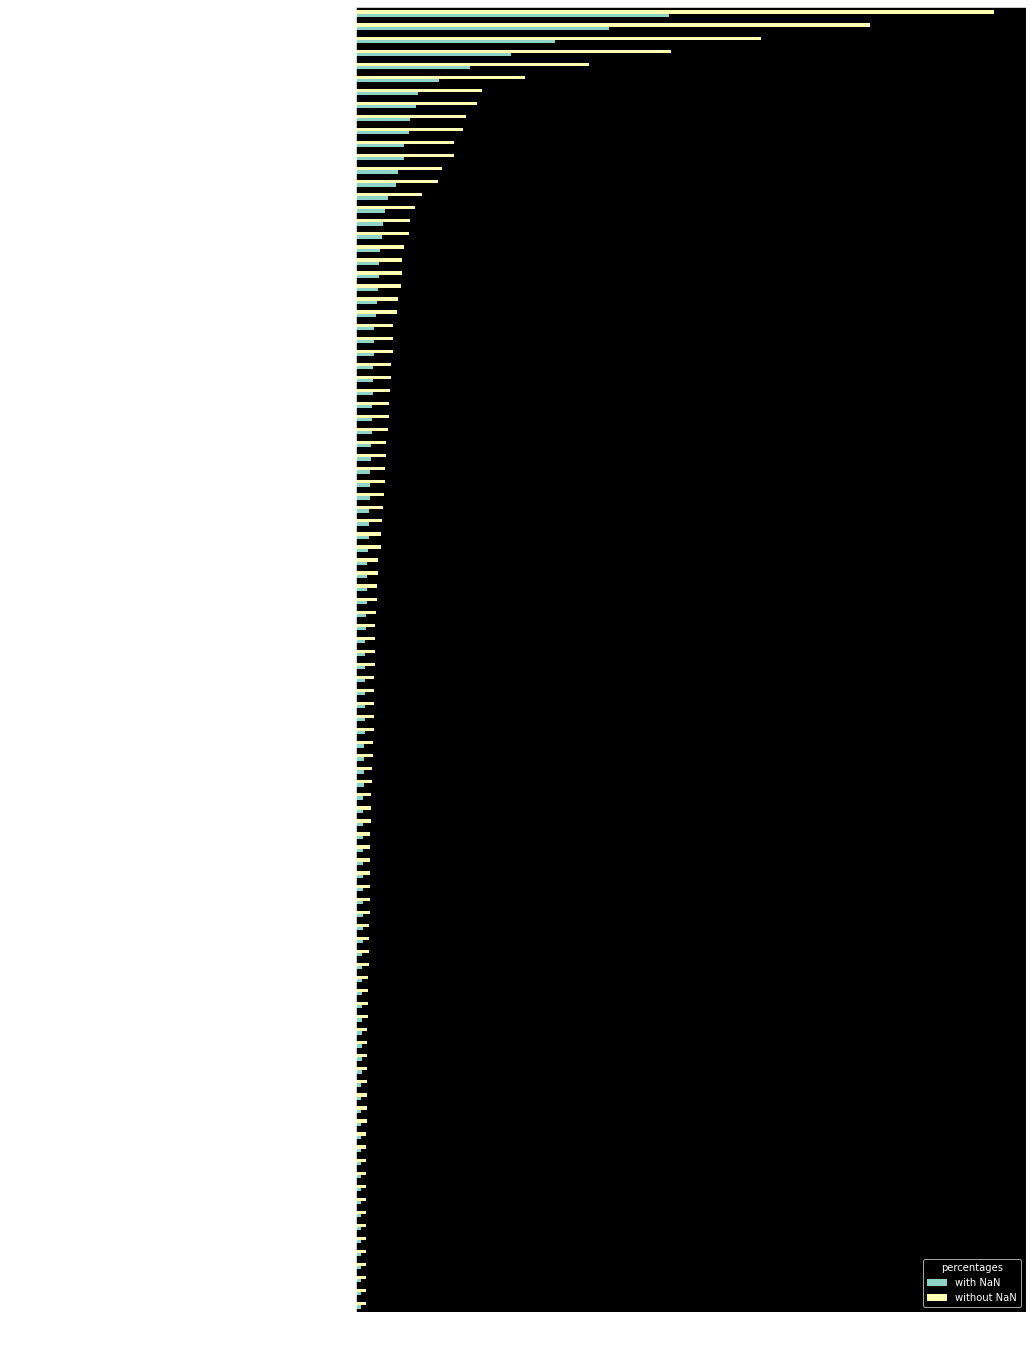

In [62]:
cvcs = pd.concat({'with NaN': holdout_cvcs['% w/NaN'].drop('NaN'),
                  'without NaN': holdout_cvcs['% wo/NaN'].drop('NaN')},
                 axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
cvcs.index.name='text'
cvcs.columns.name='percentages'

cvcs.tail(100).plot(kind='barh', stacked=False, figsize=(12, 24))
plt.xlabel('percentages (%)')
plt.show()

### Comparing training-holdout text frequency summaries

percentages                    train   holdout
text                                          
GENERAL FUND                6.139676  9.202308
EMPLOYEE BENEFITS           3.843661  1.747439
REGULAR                     3.527663  1.592595
PROFESSIONAL INSTRUCTIONAL  3.133313  1.413349
REGULAR INSTRUCTION         2.679211  1.236135
...                              ...       ...
WAN MANAGER                 0.000000  0.000291
WEB MANAGER                 0.000000  0.000291
WELDER                      0.000000  0.000291
YOUTH COMMISSION            0.000000  0.000291
NaN                         0.000000  0.000000

[8955 rows x 2 columns]

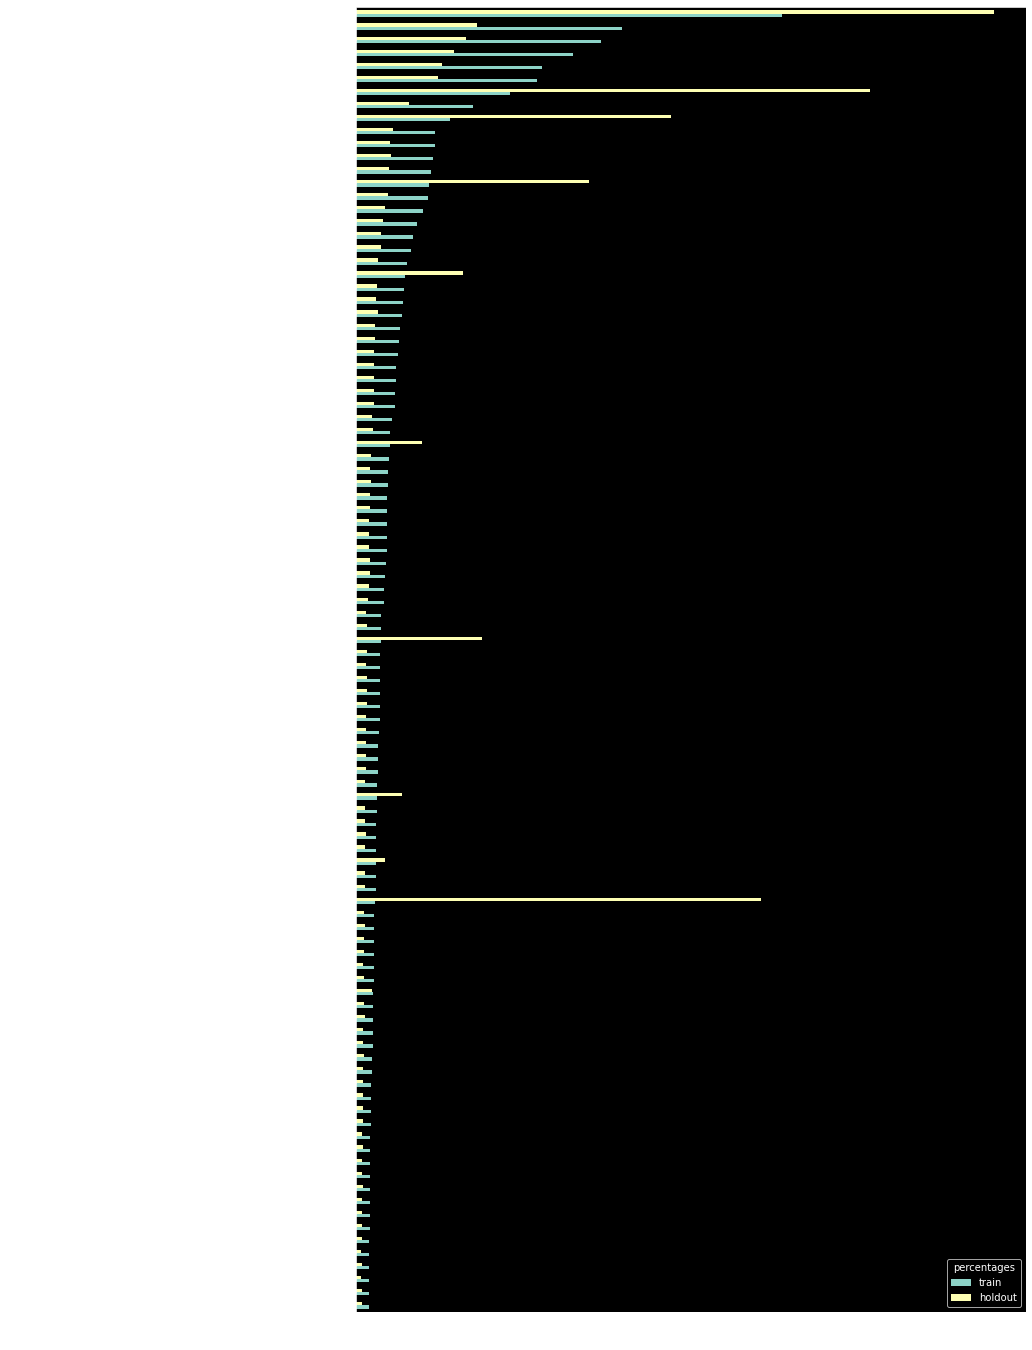

In [63]:
cvcs = pd.concat({'train': df_cvcs['% wo/NaN'],
                  'holdout': holdout_cvcs['% wo/NaN']},
                 axis=1, sort=True).fillna(0).sort_values(['train', 'holdout'], ascending=False)
cvcs.index.name='text'
cvcs.columns.name='percentages'
display(cvcs)
cvcs.sort_values(['train', 'holdout']).tail(100).plot(kind='barh', stacked=False, figsize=(12, 24))
plt.xlabel('percentages (%)')
plt.show()

# Imputation strategy

Text features will be combined, tokenized and counted in different n-gram ranges.

For numeric features:
* Generate a binary indicator for missing `FTE`
* Generate a binary indicator for missing `Total`
* Create a new numeric variable `Total_FTE` with default value `NaN`
* If `FTE` is not null and not zero, then `Total_FTE` = `Total` and `Total` = `NaN`
* TODO: Impute zero in remaining missing `FTE`, `Total`, and `Total_FTE`?

In [64]:
from preprocessing.get_normalized_total import get_normalized_total

In [65]:
df[NUMERIC_FEATURES].info()
df[NUMERIC_FEATURES].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     126071 non-null  float64
 1   Total   395722 non-null  float64
dtypes: float64(2)
memory usage: 17.2 MB


FTE      Total
134338  1.0  50471.810
206341  NaN   3477.860
326408  1.0  62237.130
364634  NaN     22.300
47683   NaN     54.166

In [66]:
get_normalized_total(df, 'FTE', 'Total').info()
get_normalized_total(df, 'FTE', 'Total').head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FTE            126071 non-null  float32
 1   Total          302248 non-null  float32
 2   FTE_missing    400277 non-null  uint8  
 3   Total_missing  400277 non-null  uint8  
 4   Total_FTE      93474 non-null   float32
dtypes: float32(3), uint8(2)
memory usage: 16.5 MB


FTE        Total  FTE_missing  Total_missing     Total_FTE
134338  1.0          NaN            0              0  50471.808594
206341  NaN  3477.860107            1              0           NaN
326408  1.0          NaN            0              0  62237.128906
364634  NaN    22.299999            1              0           NaN
47683   NaN    54.166000            1              0           NaN

# The log loss

Log loss for binary classification
$$logloss = - \frac{1}{N}\sum^N_{i=1}{(y_i log(p_i) + (1-y_i)log(1-p_i))}$$

>Better to be less confident than confident and wrong

In [67]:
from metrics.log_loss import log_loss

Wrong and confident       : 34.538776394910684
Wrong and not confident   : 0.916290731874155
Correct and not confident : 0.5108256237659907
Correct and confident     : 9.992007221626415e-16


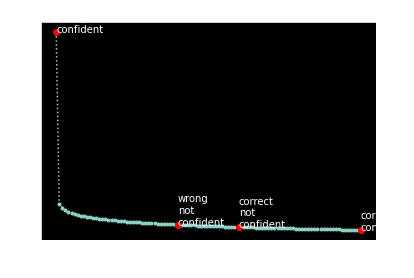

In [68]:
print('Wrong and confident       :', log_loss(actual =1, predicted=0))
print('Wrong and not confident   :', log_loss(actual=1, predicted=0.4))
print('Correct and not confident :', log_loss(actual=1, predicted=0.6))
print('Correct and confident     :', log_loss(actual=1, predicted=1))
predicts = np.linspace(0,1,100)
lloss = [log_loss(1,x) for x in predicts]
plt.plot(predicts, lloss, marker='.', linestyle='dotted')
points = [0, 0.4, 0.6, 1]
classes = ['wrong\nconfident', 'wrong\nnot\nconfident', 'correct\nnot\nconfident', 'correct\nconfident']
for i, x in enumerate(points):
    y=log_loss(actual=1, predicted=x)
    plt.plot(x, y, 'ro')
    plt.text(x, y, s=classes[i])
plt.title('Range: {0:} to {1:.2f}'.format(lloss[-1], lloss[0]))
plt.xlabel('predicted')
plt.ylabel('logloss')
plt.show()

 Log loss penalizes highly confident wrong answers much more than any other type. This is a good metric to use in this model and required by the competition.

# The multi-class multi-label log loss

In [69]:
from metrics.log_loss import multi_multi_log_loss
from dummies import get_dummies_indices
cci = get_dummies_indices(df[LABELS])

# Simple model: only numeric features

In [70]:
from model_selection.multilabel import multilabel_train_test_split

## Setting up a train-test split

* Selecting just numeric features: `df[NUMERIC_FEATURES]`

* Selecting labels as binary variables for multi-label targets: `dummy_labels`

In [71]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NUMERIC_FEATURES], dummy_labels,
                                                               size=0.2, min_count=0, seed=1)

print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     100992 non-null  float64
 1   Total   316574 non-null  float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 364634 to 375092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     25079 non-null  float64
 1   Total   79148 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 364634 to 375092
Columns: 104 entries, Funct

## Allways pre-process after splitting

In [72]:
from sklearn.preprocessing import maxabs_scale

X_train = get_normalized_total(X_train, 'FTE', 'Total')
X_train = X_train.fillna(0)
X_train[:] = maxabs_scale(X_train)

X_test = get_normalized_total(X_test, 'FTE', 'Total')
X_test = X_test.fillna(0)
X_test[:] = maxabs_scale(X_test)

## Training a model

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [74]:
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

In [75]:
clf.fit(X_train.values, y_train)  # fit without feature names to avoid warning on predict of features that maxabs_scale removes names from

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

## Model metrics

In [76]:
# print("Training Accuracy:", clf.score(X_train, y_train))
print("Training Accuracy:", clf.score(X_train.values, y_train))  # score without feature names to avoid as train doesn't have them too

Training Accuracy: 0.04463153687129554


In [77]:
# y_pred = clf.predict_proba(X_train)
y_pred = clf.predict_proba(X_train.values)  # predict_proba without feature names to avoid as train doesn't have them too
print("Training Logloss:", multi_multi_log_loss(y_train, y_pred, class_column_indices=cci))

Training Logloss: 1.2916546628862906


In [78]:
# print("Testing Accuracy:", clf.score(X_test, y_test))
print("Testing Accuracy:", clf.score(X_test.values, y_test))  # score without feature names to avoid as train doesn't have them too

Testing Accuracy: 0.04204609331084879


In [79]:
# y_pred = clf.predict_proba(X_test)
y_pred = clf.predict_proba(X_test.values)  # predict_proba without feature names to avoid as train doesn't have them too
print("Testing Logloss:", multi_multi_log_loss(y_test, y_pred, class_column_indices=cci))

Testing Logloss: 1.2976415720423216


In [80]:
# y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test.values) # predict without feature names to avoid as train doesn't have them too
print("Testing Classification Report:\n", classification_report(y_test, y_pred))

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3892
           1       0.00      0.00      0.00       604
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00      1472
           4       0.00      0.00      0.00       678
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00      2152
           7       0.00      0.00      0.00      1652
           8       0.00      0.00      0.00      3969
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00       470
          11       1.00      0.00      0.00      2831
          12       0.00      0.00      0.00       141
          13       0.00      0.00      0.00       240
          14       0.00      0.00      0.00      3845
          15       0.00      0.00      0.00        12
          16       0.00      0.00      0.00      

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Use your model to predict values on holdout data

In [81]:
# Realigning features according to train features
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)[FEATURES]
predictions = clf.predict_proba(maxabs_scale(get_normalized_total(holdout, 'FTE', 'Total').fillna(0)))

## Writing out your results to a csv for submission
At last, you're ready to submit some predictions for scoring. In this exercise, you'll write your predictions to a .csv using the .to_csv() method on a pandas DataFrame. Then you'll evaluate your performance according to the LogLoss metric discussed earlier!

You'll need to make sure your submission obeys the correct format.

To do this, you'll use your predictions values to create a new DataFrame, prediction_df.

Interpreting LogLoss & Beating the Benchmark:

When interpreting your log loss score, keep in mind that the score will change based on the number of samples tested. To get a sense of how this very basic model performs, compare your score to the DrivenData benchmark model performance: 2.0455, which merely submitted uniform probabilities for each class.

Remember, the lower the log loss the better. Is your model's log loss lower than 2.0455?

In [82]:
prediction_df = pd.DataFrame(columns=dummy_labels.columns,
                             index=holdout.index,
                             data=predictions)#.apply(lambda x: x.astype('category'), axis=0)
prediction_df.head()

Function__Aides Compensation  Function__Career & Academic Counseling  \
180042                      0.036536                                0.006513   
28872                       0.036536                                0.006513   
186915                      0.088494                                0.006064   
412396                      0.088481                                0.006064   
427740                      0.088513                                0.006063   

        Function__Communications  Function__Curriculum Development  \
180042                  0.000880                          0.024430   
28872                   0.000880                          0.024430   
186915                  0.000581                          0.008633   
412396                  0.000581                          0.008633   
427740                  0.000581                          0.008634   

        Function__Data Processing & Information Services  \
180042                                          0.008810   
28872                                           0.008810   
186915                                          0.004986   
412396                                          0.004986   
427740                                          0.004985   

        Function__Development & Fundraising  Function__Enrichment  \
180042                             0.000189              0.032018   
28872                              0.000189              0.032018   
186915                             0.000431              0.021121   
412396                             0.000431              0.021117   
427740                             0.000431              0.021125   

        Function__Extended Time & Tutoring  \
180042                            0.024375   
28872                             0.024375   
186915                            0.019747   
412396                            0.019743   
427740                            0.019752   

        Function__Facilities & Maintenance  Function__Facilities Planning  \
180042                            0.052467                       0.000102   
28872                             0.052467                       0.000102   
186915                            0.038258                       0.000135   
412396                            0.038258                       0.000135   
427740                            0.038258                       0.000135   

        ...  Student_Type__Special Education  Student_Type__Unspecified  \
180042  ...                         0.086929                   0.519427   
28872   ...                         0.086930                   0.519430   
186915  ...                         0.146230                   0.703230   
412396  ...                         0.146229                   0.703220   
427740  ...                         0.146231                   0.703242   

        Use__Business Services  Use__ISPD  Use__Instruction  Use__Leadership  \
180042                0.016240   0.073558          0.441159         0.038992   
28872                 0.016240   0.073559          0.441163         0.038992   
186915                0.010684   0.047727          0.691183         0.026220   
412396                0.010685   0.047728          0.691187         0.026223   
427740                0.010683   0.047726          0.691178         0.026216   

        Use__NO_LABEL  Use__O&M  Use__Pupil Services & Enrichment  \
180042       0.250572  0.115059                          0.062636   
28872        0.250568  0.115059                          0.062636   
186915       0.059500  0.134092                          0.048413   
412396       0.059501  0.134072                          0.048415   
427740       0.059498  0.134118                          0.048411   

        Use__Untracked Budget Set-Aside  
180042                         0.001153  
28872                          0.001153  
186915                         0.000320  
412396                         0.000320  
427740                         0.

In [83]:
prediction_df.to_csv('/data/drivendata/predictions/2022/0.8-numeric-features-logistic-regression-C1.csv')

Your score for this submission is 1.3252 (30-6-2020)

# Improving your model: NLP

## Combining text features for tokenization

Here all text features are concatenated in each row.

Each row becomes a single document.

In [84]:
from preprocessing.combine_text_columns import combine_text_columns

In [85]:
t=time()
text_vector = combine_text_columns(df, to_drop=NUMERIC_FEATURES + LABELS)
print('Elapsed', time()-t)
text_vector

Elapsed 1.6734898090362549


134338                                                                                                                                                                                                                                                                                    Teacher-Elementary        KINDERGARTEN  KINDERGARTEN General Fund 
206341                                                                                                                                                                                            CONTRACTOR SERVICES BOND EXPENDITURES BUILDING FUND (blank) Regular    RGN  GOB  UNDESIGNATED BUILDING IMPROVEMENT SERVICES  BUILDING IMPROVEMENT SERVICES
326408                                                                                                                                                                                                                         Personal Services - Teachers   TCHER 2ND GRADE  Regular Instruction     TEACHER

In [86]:
print('Memory size {}:', size(sys.getsizeof(text_vector)))

Memory size {}: 97.1 MiB


## Bag-of-Words

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

Unigram (word) statistics:

<400277x3728 sparse matrix of type '<class 'numpy.int64'>'
	with 6290672 stored elements in Compressed Sparse Row format>

00a  12  1st  2nd  3rd  4th  56  5th  60  60hrs  ...  yr  yrbs  yrs  \
0         0   0    0    0    0    0   0    0   0      0  ...   0     0    0   
1         0   0    0    0    0    0   0    0   0      0  ...   0     0    0   
2         0   0    0    1    0    0   0    0   0      0  ...   0     0    0   
3         0   0    0    0    0    0   0    0   0      0  ...   0     0    0   
4         0   0    0    0    0    0   0    0   0      0  ...   0     0    0   
...     ...  ..  ...  ...  ...  ...  ..  ...  ..    ...  ...  ..   ...  ...   
400272    0   0    0    0    0    0   0    0   0      0  ...   0     0    0   
400273    0   0    0    0    0    0   0    0   0      0  ...   0     0    0   
400274    0   0    0    0    0    0   0    0   0      0  ...   0     0    0   
400275    0   0    0    0    0    0   0    0   0      0  ...   0     0    0   
400276    0   0    0    0    0    0   0    0   0      0  ...   0     0    0   

        yth  zero  zeta  zone  zoo  zuni  zz  
0         0     0     0     0    0     0   0  
1         0     0     0     0    0     0   0  
2         0     0     0     0    0     0   0  
3         0     0     0     0    0     0   0  
4         0     0     0     0    0     0   0  
...     ...   ...   ...   ...  ...   ...  ..  
400272    0     0     0     0    0     0   0  
400273    0     0     0     0    0     0   0  
400274    0     0     0     0    0     0   0  
400275    0     0     0     0    0     0   0  
400276    0     0     0     0    0     0   0  

[400277 rows x 3728 columns]

Sparsity                           : 0.9957843892675138
Max term frequency in a document   : 6
Max term frequency in all documents: 331001
Max words in a document            : 49
Mean words per document            : 19.3
Median words per document          : 18.0
Sparse matrix memory usage         : 73.5 MiB
Dense matrix memory equivalence    : 11.1 GiB
Non-zero probabilities:

bin    count  proportion
0    1  5111160    0.812498
1    2   964685    0.153352
2    3   170352    0.027080
3    4    35572    0.005655
4    5     7678    0.001221
5    6     1225    0.000195

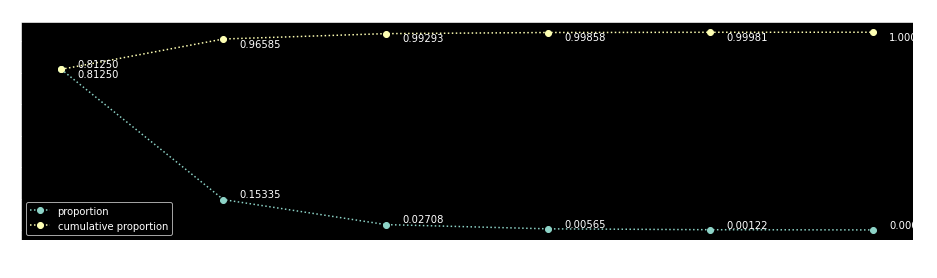

In [88]:
vec = CountVectorizer()
tdm = vec.fit_transform(text_vector)
display(tdm)
display(pd.DataFrame(tdm.toarray(), columns=vec.get_feature_names_out()))

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max term frequency in a document   : {}'.format(tdm.max()))
print('Max term frequency in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max words in a document            : {}'.format(tdm.sum(axis=1).max()))
print('Mean words per document            : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median words per document          : {}'.format(np.median(np.array(tdm.sum(axis=1)))))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, tdm.max() + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

* **`81%` of the words appear only `1`  time in the rows of the `text_vector`**
* **`99%` of the words appear from `1` to `3` times in the rows of the `text_vector`**

## Tokenizing n-gram ranges

The `CountVectorizer` default `dtype` is `int64`.

As the maximum frequency of any token in a single observation is 6, the 8-bits unsigned integer `uint8` (0 to 255) could be enough to store counts of any ngram range.

Iterating over all possible n-gram ranges: `tdm.sum(axis=1).max()`

In [89]:
# tracemalloc.start()
# msg = 'ngram:{},{} cols:{} maxtf:{} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
# for ngram_range in [(1,x) for x in range(1, 50)]: # 49 is the max number of words per document
#     t=time()
#     vec = CountVectorizer(ngram_range = ngram_range, dtype='uint8')
#     tdm = vec.fit_transform(text_vector)
#     t=time()-t
#     current, peak = tracemalloc.get_traced_memory()
#     #tracemalloc.reset_peak()
#     tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#     print(msg.format(ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(),
#                      tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes),
#                      size(current), size(peak), t))
# tracemalloc.stop()

**Saved results:**
```
Last executed at 2022-07-20 21:46:18 in 57m 12.64s
ngram:1,1 cols:3728 maxtf:6 nnz:6290672 sparse:99.58% size:31.5 MiB cur:32.1 MiB peak:116.4 MiB 6s
ngram:1,2 cols:32572 maxtf:6 nnz:13167763 sparse:99.90% size:64.3 MiB cur:68.5 MiB peak:265.2 MiB 11s
ngram:1,3 cols:91308 maxtf:6 nnz:19888976 sparse:99.95% size:96.4 MiB cur:109.9 MiB peak:417.7 MiB 16s
ngram:1,4 cols:181493 maxtf:6 nnz:26296018 sparse:99.96% size:126.9 MiB cur:154.7 MiB peak:574.1 MiB 20s
ngram:1,5 cols:304059 maxtf:6 nnz:32351187 sparse:99.97% size:155.8 MiB cur:197.1 MiB peak:721.1 MiB 25s
ngram:1,6 cols:457658 maxtf:6 nnz:38050953 sparse:99.98% size:183.0 MiB cur:252.4 MiB peak:884.1 MiB 30s
ngram:1,7 cols:639083 maxtf:6 nnz:43383271 sparse:99.98% size:208.4 MiB cur:300.5 MiB peak:1.0 GiB 35s
ngram:1,8 cols:843382 maxtf:6 nnz:48343036 sparse:99.99% size:232.0 MiB cur:371.2 MiB peak:1.2 GiB 40s
ngram:1,9 cols:1065609 maxtf:6 nnz:52924082 sparse:99.99% size:253.9 MiB cur:424.1 MiB peak:1.3 GiB 44s
ngram:1,10 cols:1299651 maxtf:6 nnz:57123587 sparse:99.99% size:273.9 MiB cur:478.6 MiB peak:1.5 GiB 48s
ngram:1,11 cols:1538143 maxtf:6 nnz:60946572 sparse:99.99% size:292.1 MiB cur:573.7 MiB peak:1.6 GiB 52s
ngram:1,12 cols:1774565 maxtf:6 nnz:64407007 sparse:99.99% size:308.6 MiB cur:628.6 MiB peak:1.8 GiB 56s
ngram:1,13 cols:2003991 maxtf:6 nnz:67516090 sparse:99.99% size:323.5 MiB cur:682.4 MiB peak:1.9 GiB 59s
ngram:1,14 cols:2222412 maxtf:6 nnz:70289409 sparse:99.99% size:336.7 MiB cur:734.3 MiB peak:2.0 GiB 63s
ngram:1,15 cols:2426477 maxtf:6 nnz:72749237 sparse:99.99% size:348.4 MiB cur:783.7 MiB peak:2.1 GiB 65s
ngram:1,16 cols:2614225 maxtf:6 nnz:74920467 sparse:99.99% size:358.8 MiB cur:830.2 MiB peak:2.2 GiB 67s
ngram:1,17 cols:2784291 maxtf:6 nnz:76826841 sparse:99.99% size:367.9 MiB cur:873.2 MiB peak:2.3 GiB 70s
ngram:1,18 cols:2936736 maxtf:6 nnz:78490890 sparse:99.99% size:375.8 MiB cur:992.7 MiB peak:2.5 GiB 72s
ngram:1,19 cols:3071856 maxtf:6 nnz:79935242 sparse:99.99% size:382.7 MiB cur:1.0 GiB peak:2.5 GiB 74s
ngram:1,20 cols:3190500 maxtf:6 nnz:81185242 sparse:99.99% size:388.6 MiB cur:1.0 GiB peak:2.6 GiB 75s
ngram:1,21 cols:3294155 maxtf:6 nnz:82262544 sparse:99.99% size:393.8 MiB cur:1.1 GiB peak:2.6 GiB 77s
ngram:1,22 cols:3384554 maxtf:6 nnz:83193456 sparse:99.99% size:398.2 MiB cur:1.1 GiB peak:2.7 GiB 78s
ngram:1,23 cols:3463644 maxtf:6 nnz:84002266 sparse:99.99% size:402.1 MiB cur:1.1 GiB peak:2.7 GiB 79s
ngram:1,24 cols:3533189 maxtf:6 nnz:84705916 sparse:99.99% size:405.4 MiB cur:1.1 GiB peak:2.8 GiB 79s
ngram:1,25 cols:3594644 maxtf:6 nnz:85320470 sparse:99.99% size:408.4 MiB cur:1.2 GiB peak:2.8 GiB 80s
ngram:1,26 cols:3649208 maxtf:6 nnz:85859777 sparse:99.99% size:410.9 MiB cur:1.2 GiB peak:2.8 GiB 81s
ngram:1,27 cols:3697724 maxtf:6 nnz:86334041 sparse:99.99% size:413.2 MiB cur:1.2 GiB peak:2.9 GiB 81s
ngram:1,28 cols:3740841 maxtf:6 nnz:86751560 sparse:99.99% size:415.2 MiB cur:1.2 GiB peak:2.9 GiB 82s
ngram:1,29 cols:3779050 maxtf:6 nnz:87119104 sparse:99.99% size:416.9 MiB cur:1.2 GiB peak:2.9 GiB 82s
ngram:1,30 cols:3812781 maxtf:6 nnz:87440566 sparse:99.99% size:418.5 MiB cur:1.2 GiB peak:2.9 GiB 83s
ngram:1,31 cols:3842324 maxtf:6 nnz:87719094 sparse:99.99% size:419.8 MiB cur:1.2 GiB peak:3.0 GiB 83s
ngram:1,32 cols:3867878 maxtf:6 nnz:87956711 sparse:99.99% size:420.9 MiB cur:1.2 GiB peak:3.0 GiB 84s
ngram:1,33 cols:3889679 maxtf:6 nnz:88156009 sparse:99.99% size:421.9 MiB cur:1.2 GiB peak:3.0 GiB 84s
ngram:1,34 cols:3908002 maxtf:6 nnz:88319906 sparse:99.99% size:422.7 MiB cur:1.3 GiB peak:3.0 GiB 83s
ngram:1,35 cols:3923166 maxtf:6 nnz:88451032 sparse:99.99% size:423.3 MiB cur:1.3 GiB peak:3.0 GiB 83s
ngram:1,36 cols:3935535 maxtf:6 nnz:88554074 sparse:99.99% size:423.8 MiB cur:1.3 GiB peak:3.0 GiB 84s
ngram:1,37 cols:3945420 maxtf:6 nnz:88632711 sparse:99.99% size:424.2 MiB cur:1.3 GiB peak:3.0 GiB 84s
ngram:1,38 cols:3953125 maxtf:6 nnz:88691248 sparse:99.99% size:424.4 MiB cur:1.3 GiB peak:3.0 GiB 84s
ngram:1,39 cols:3958926 maxtf:6 nnz:88732265 sparse:99.99% size:424.6 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,40 cols:3963114 maxtf:6 nnz:88759772 sparse:99.99% size:424.8 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,41 cols:3966091 maxtf:6 nnz:88779173 sparse:99.99% size:424.9 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,42 cols:3968183 maxtf:6 nnz:88792680 sparse:99.99% size:424.9 MiB cur:1.3 GiB peak:3.0 GiB 84s
ngram:1,43 cols:3969642 maxtf:6 nnz:88802396 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,44 cols:3970618 maxtf:6 nnz:88808964 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,45 cols:3971226 maxtf:6 nnz:88812826 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,46 cols:3971537 maxtf:6 nnz:88814674 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,47 cols:3971662 maxtf:6 nnz:88815148 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,48 cols:3971702 maxtf:6 nnz:88815248 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,49 cols:3971712 maxtf:6 nnz:88815268 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 84s
```

## n-gram range frequency plot

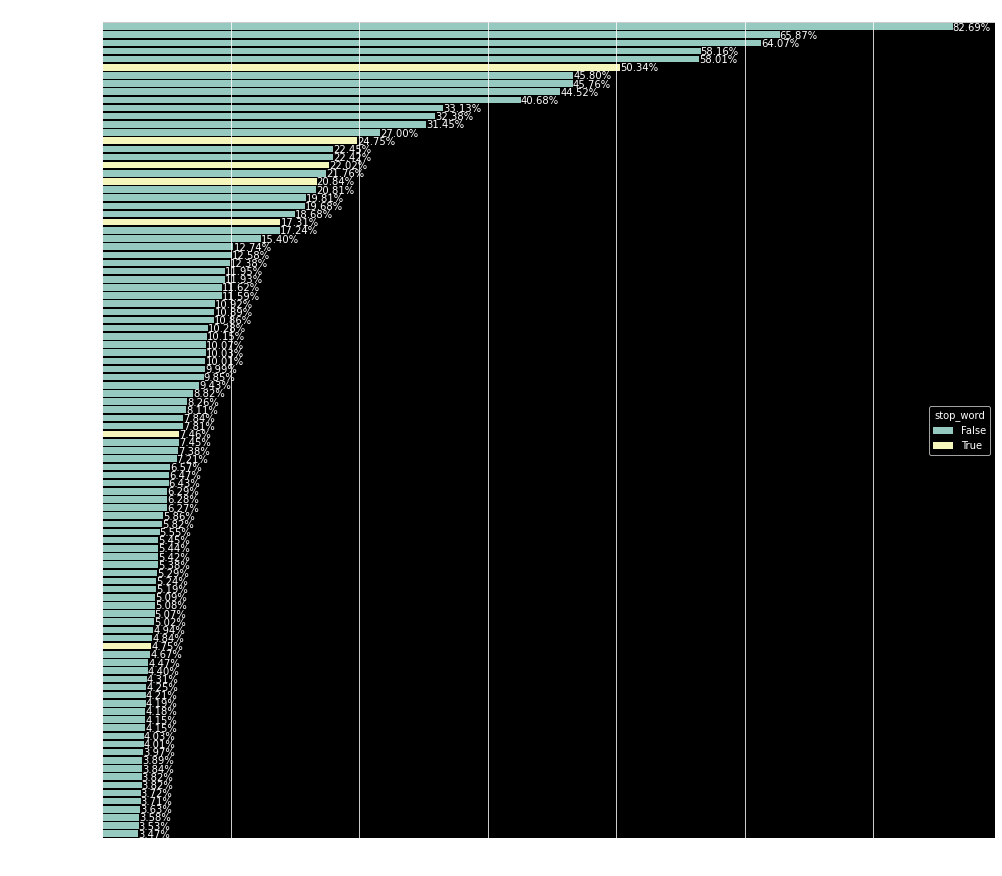

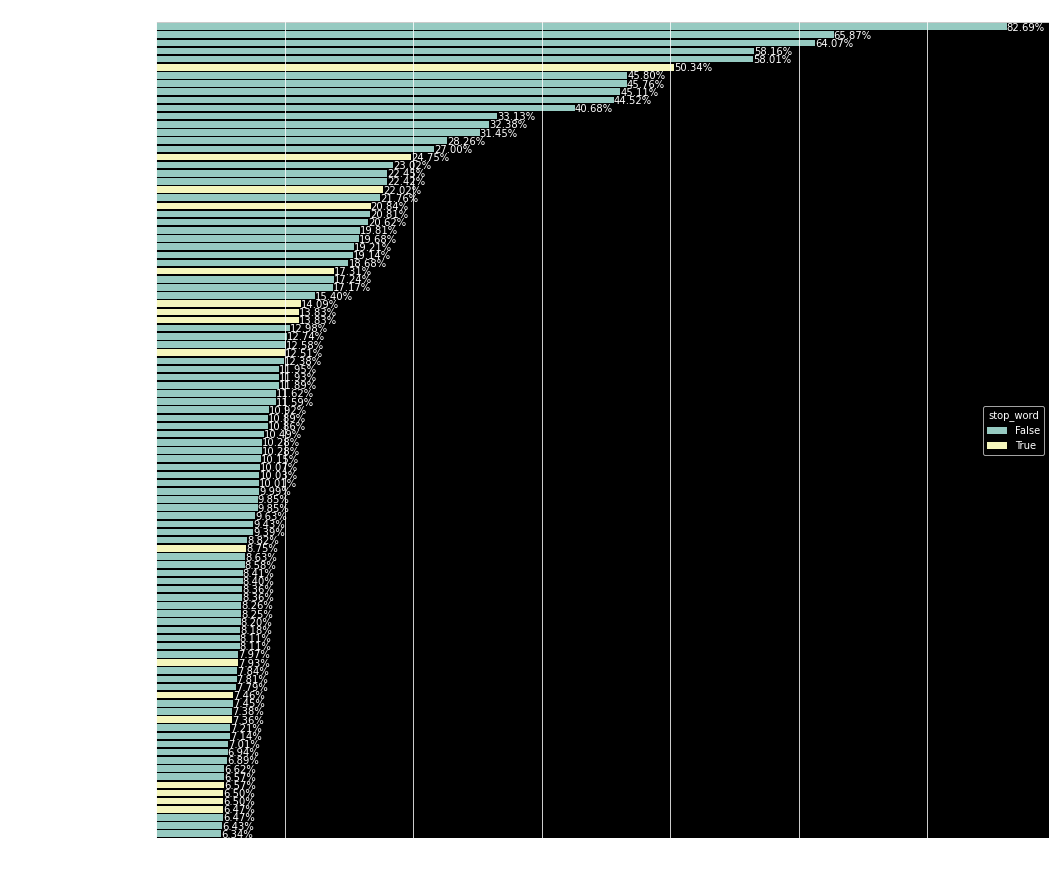

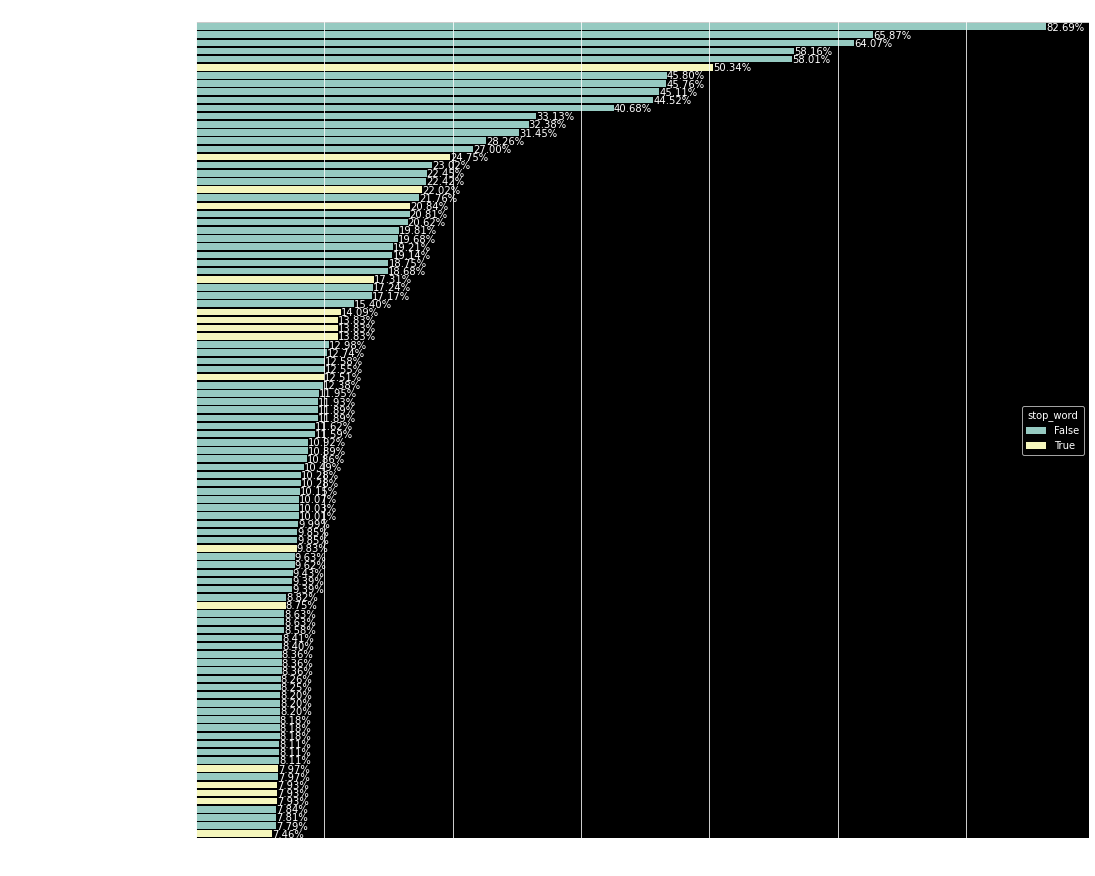

In [90]:
stop_words = CountVectorizer(stop_words='english').get_stop_words()
top = 100
for ngram_range in [(1,x) for x in range(1,4)]:
    vec = CountVectorizer(ngram_range=ngram_range, dtype='uint8')
    tdm = vec.fit_transform(text_vector)
    term_freq = pd.DataFrame({'term': vec.get_feature_names_out(),
                              'proportion': tdm.mean(axis=0).tolist()[0],
                              'frequency': tdm.sum(axis=0).tolist()[0],
                              #'stop_word': [True if fn in stop_words else False for fn in vec.get_feature_names()]
                              'stop_word': [True if any([True if word in stop_words else False for word in str.split(words)]) else False for words in vec.get_feature_names_out()]
                             }).sort_values(['frequency','term'], ascending=(False, True)).head(top)
    plt.figure(figsize=(16,15))
    plt.grid()
    ax = sns.barplot(x='frequency', y='term', data=term_freq, hue='stop_word', dodge=False)
    patches = ax.patches
    for i in range(len(patches)):
        # x = patches[i].get_x() + patches[i].get_width()/2
        # y = patches[i].get_height()+.05
        y = patches[i].get_y() + patches[i].get_height()
        x = patches[i].get_x() + patches[i].get_width()
        ax.annotate('{:.2f}%'.format(term_freq['proportion'].iloc[i%top]*100), (x, y))#, ha='center')
    plt.title('n-gram range {} frequency'.format(ngram_range))
    plt.show()

## Hashing Trick

* Adding new features (e.g. 3-grams, 4-grams) may cause enormous increase in array size
* Hashing is a way of increasing memory efficiency
* Want to make array of features as small as possible: dimensionality Reduction
* Hash functions limits possible outputs, fixing array size
* Particularly useful on large datasets: e.g. lots of text data!

In [91]:
from sklearn.feature_extraction.text import HashingVectorizer

The parameters `norm=None`, `alternate_sign=False` and `binary=False` let us drop in the `HashingVectorizer()` as a replacement for `CounterVectorizer()`

[From sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-hashing):
> Since the hash function might cause collisions between (unrelated) features, a signed hash function is used and the sign of the hash value determines the sign of the value stored in the output matrix for a feature. This way, collisions are likely to cancel out rather than accumulate error, and the expected mean of any output feature’s value is zero. This mechanism is enabled by default with `alternate_sign=True` and is particularly useful for small hash table sizes (`n_features < 10000`). For large hash table sizes, it can be disabled, to allow the output to be passed to estimators like `sklearn.naive_bayes.MultinomialNB` or `sklearn.feature_selection.chi2` feature selectors that expect non-negative inputs.

Why is hashing a useful trick?

A hash function takes an input, in your case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.

A familiar python datatype, a dictionary, makes this mapping concept a bit more explicit. In fact, python dictionaries ARE hash tables!

`{'petro': 354, 'vend': 785, 'fuel': 895, 'and': 780, 'fluids': 354}`

By explicitly stating how many possible outputs the hashing function may have, we limit the size of the objects that need to be processed. With these limits known, computation can be made more efficient and we can get results faster, even on large datasets.

The default limit is `n_features=1048576` $(2^{20})$.  The number of features (columns) in the output matrices. Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

Some problems are memory-bound and not easily parallelizable, and hashing enforces a fixed length computation instead of using a mutable datatype (like a dictionary).  Enforcing a fixed length can speed up calculations drastically, especially on large datasets!

Tokenizing unigram (words)

<400277x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparsity                                    : 0.9985012248219768
Max count of a hashed token in a document   : 6.0
Max count of a hashed token in all documents: 331001.0
Max unique hashed tokens per document       : 49.0
Mean unique hashed tokens per document      : 19.3
Median unique tokens per document           : 18.0
Sparse matrix memory usage                  : 73.5 MiB
Dense matrix memory equivalence             : 3.1 TiB
Non-zero probabilities:

bin    count  proportion
0    1  5111160    0.812498
1    2   964685    0.153352
2    3   170352    0.027080
3    4    35572    0.005655
4    5     7678    0.001221
5    6     1225    0.000195

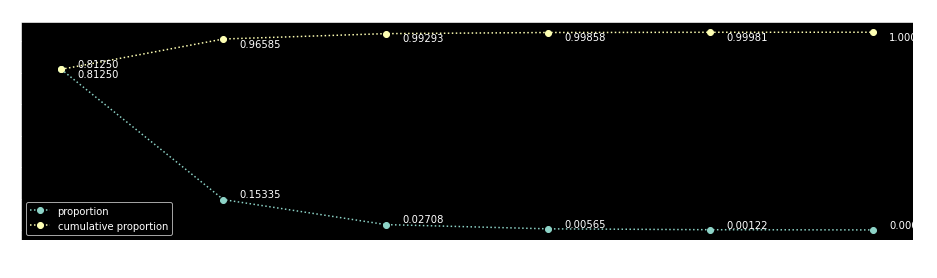

In [92]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False)
tdm = vec.fit_transform(text_vector)
display(tdm)
print('Sparsity                                    : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1]) * 100))
print('Max count of a hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document       : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document      : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document           : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                  :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence             :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, int(tdm.max()) + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

The maximum frequency of any hashed 1-gram token in a single observation is also 6 so the 8-bits unsigned integer `uint8` (0 to 255) also could be enough to store counts of any ngram range as long as there are sufficient `n_features`.

## Tokenizing hashed n-gram ranges

Iterating over `n_features` from the default $2^{20}$ to the maximum $2^{30}$ ([Murmurhash3 32-bit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)) and n-gram range from 1 to 3 in order to understand hashing collisions and memory usage.

In [93]:
# tracemalloc.start()
# tracemalloc.reset_peak()
# msg = 'features:2^{}={} ngram:{},{} cols:{} maxtf:{:.0f} maxtfall:{:.0f} hashcount:{} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
# for i in range(1, 31): # from 2^1 to 2^30 (Mumuhash3 32-bit)
#     for ngram_range in [(1,x) for x in range(1, 4)]:
#         t=time()
#         vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False,
#                                 ngram_range=ngram_range, n_features=2**i, dtype='uint8')
#         tdm = vec.fit_transform(text_vector)
#         t=time()-t
#         current, peak = tracemalloc.get_traced_memory()
#         tracemalloc.reset_peak()
#         _, hash_counts = np.unique(tdm.data, return_counts=True)
#         tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#         print(msg.format(i, 2**i, ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(), tdm.sum(axis=0).max(),
#                          len(hash_counts),
#                          tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100,
#                          size(tdm_nbytes), size(current), size(peak), t))
#         #print(list(hash_counts/hash_counts.sum()),'\n')
# tracemalloc.stop()

**Saved results:**  
```
Last executed at 2022-07-23 02:48:24 in 30m 40.91s
features:2^1=2 ngram:1,1 cols:2 maxtf:36 maxtfall:4187508 hashcount:35 nnz:794417 sparse:0.77% size:5.3 MiB cur:5.3 MiB peak:13.3 MiB 9s
features:2^1=2 ngram:1,2 cols:2 maxtf:58 maxtfall:7827178 hashcount:58 nnz:796765 sparse:0.47% size:5.3 MiB cur:5.3 MiB peak:29.3 MiB 21s
features:2^1=2 ngram:1,3 cols:2 maxtf:87 maxtfall:11209240 hashcount:85 nnz:796765 sparse:0.47% size:5.3 MiB cur:5.3 MiB peak:53.3 MiB 30s
features:2^2=4 ngram:1,1 cols:4 maxtf:26 maxtfall:2453094 hashcount:26 nnz:1549832 sparse:3.20% size:8.9 MiB cur:8.9 MiB peak:53.3 MiB 10s
features:2^2=4 ngram:1,2 cols:4 maxtf:35 maxtfall:4190569 hashcount:35 nnz:1587887 sparse:0.83% size:9.1 MiB cur:9.1 MiB peak:53.3 MiB 21s
features:2^2=4 ngram:1,3 cols:4 maxtf:54 maxtfall:5784679 hashcount:54 nnz:1592212 sparse:0.56% size:9.1 MiB cur:9.1 MiB peak:57.1 MiB 30s
features:2^3=8 ngram:1,1 cols:8 maxtf:18 maxtfall:1325263 hashcount:17 nnz:2702208 sparse:15.61% size:14.4 MiB cur:14.4 MiB peak:57.1 MiB 10s
features:2^3=8 ngram:1,2 cols:8 maxtf:24 maxtfall:2217285 hashcount:24 nnz:3096045 sparse:3.32% size:16.3 MiB cur:16.3 MiB peak:57.1 MiB 21s
features:2^3=8 ngram:1,3 cols:8 maxtf:33 maxtfall:3018322 hashcount:33 nnz:3154089 sparse:1.50% size:16.6 MiB cur:16.6 MiB peak:64.9 MiB 30s
features:2^4=16 ngram:1,1 cols:16 maxtf:15 maxtfall:1034314 hashcount:14 nnz:3921702 sparse:38.77% size:20.2 MiB cur:5.3 MiB peak:64.9 MiB 10s
features:2^4=16 ngram:1,2 cols:16 maxtf:19 maxtfall:1496823 hashcount:19 nnz:5335050 sparse:16.70% size:27.0 MiB cur:27.0 MiB peak:64.9 MiB 21s
features:2^4=16 ngram:1,3 cols:16 maxtf:23 maxtfall:1890535 hashcount:23 nnz:5829836 sparse:8.97% size:29.3 MiB cur:29.3 MiB peak:88.3 MiB 30s
features:2^5=32 ngram:1,1 cols:32 maxtf:11 maxtfall:633333 hashcount:11 nnz:5022569 sparse:60.79% size:25.5 MiB cur:9.5 MiB peak:88.3 MiB 10s
features:2^5=32 ngram:1,2 cols:32 maxtf:14 maxtfall:858706 hashcount:14 nnz:7929966 sparse:38.09% size:39.3 MiB cur:9.1 MiB peak:88.3 MiB 21s
features:2^5=32 ngram:1,3 cols:32 maxtf:17 maxtfall:1113927 hashcount:17 nnz:9553383 sparse:25.42% size:47.1 MiB cur:47.1 MiB peak:88.3 MiB 30s
features:2^6=64 ngram:1,1 cols:64 maxtf:8 maxtfall:418134 hashcount:8 nnz:5619666 sparse:78.06% size:28.3 MiB cur:9.5 MiB peak:123.0 MiB 10s
features:2^6=64 ngram:1,2 cols:64 maxtf:12 maxtfall:502469 hashcount:12 nnz:10123894 sparse:60.48% size:49.8 MiB cur:17.5 MiB peak:123.0 MiB 21s
features:2^6=64 ngram:1,3 cols:64 maxtf:13 maxtfall:641202 hashcount:13 nnz:13405271 sparse:47.67% size:65.4 MiB cur:14.3 MiB peak:123.0 MiB 30s
features:2^7=128 ngram:1,1 cols:128 maxtf:8 maxtfall:358296 hashcount:8 nnz:5955794 sparse:88.38% size:29.9 MiB cur:9.5 MiB peak:123.0 MiB 10s
features:2^7=128 ngram:1,2 cols:128 maxtf:11 maxtfall:406431 hashcount:11 nnz:11450345 sparse:77.65% size:56.1 MiB cur:17.5 MiB peak:123.0 MiB 21s
features:2^7=128 ngram:1,3 cols:128 maxtf:11 maxtfall:533865 hashcount:11 nnz:16092500 sparse:68.59% size:78.3 MiB cur:16.9 MiB peak:123.0 MiB 30s
features:2^8=256 ngram:1,1 cols:256 maxtf:7 maxtfall:352774 hashcount:7 nnz:6142401 sparse:94.01% size:30.8 MiB cur:9.5 MiB peak:142.7 MiB 10s
features:2^8=256 ngram:1,2 cols:256 maxtf:10 maxtfall:358975 hashcount:10 nnz:12368980 sparse:87.93% size:60.5 MiB cur:17.5 MiB peak:142.7 MiB 21s
features:2^8=256 ngram:1,3 cols:256 maxtf:10 maxtfall:450143 hashcount:10 nnz:17932462 sparse:82.50% size:87.0 MiB cur:33.5 MiB peak:142.7 MiB 30s
features:2^9=512 ngram:1,1 cols:512 maxtf:6 maxtfall:339288 hashcount:6 nnz:6222740 sparse:96.96% size:31.2 MiB cur:9.5 MiB peak:173.4 MiB 10s
features:2^9=512 ngram:1,2 cols:512 maxtf:9 maxtfall:342549 hashcount:9 nnz:12712194 sparse:93.80% size:62.1 MiB cur:17.5 MiB peak:173.4 MiB 21s
features:2^9=512 ngram:1,3 cols:512 maxtf:9 maxtfall:350521 hashcount:9 nnz:18849729 sparse:90.80% size:91.4 MiB cur:33.5 MiB peak:173.4 MiB 30s
features:2^10=1024 ngram:1,1 cols:1024 maxtf:6 maxtfall:331003 hashcount:6 nnz:6248202 sparse:98.48% size:31.3 MiB cur:9.5 MiB peak:180.4 MiB 10s
features:2^10=1024 ngram:1,2 cols:1024 maxtf:8 maxtfall:332813 hashcount:8 nnz:12931733 sparse:96.85% size:63.2 MiB cur:17.5 MiB peak:180.4 MiB 21s
features:2^10=1024 ngram:1,3 cols:1024 maxtf:8 maxtfall:336036 hashcount:8 nnz:19316187 sparse:95.29% size:93.6 MiB cur:33.5 MiB peak:180.4 MiB 30s
features:2^11=2048 ngram:1,1 cols:2048 maxtf:6 maxtfall:331001 hashcount:6 nnz:6275510 sparse:99.23% size:31.5 MiB cur:9.5 MiB peak:184.0 MiB 10s
features:2^11=2048 ngram:1,2 cols:2048 maxtf:8 maxtfall:331441 hashcount:8 nnz:13040209 sparse:98.41% size:63.7 MiB cur:17.5 MiB peak:184.0 MiB 21s
features:2^11=2048 ngram:1,3 cols:2048 maxtf:8 maxtfall:332508 hashcount:8 nnz:19629629 sparse:97.61% size:95.1 MiB cur:33.5 MiB peak:184.0 MiB 30s
features:2^12=4096 ngram:1,1 cols:4096 maxtf:6 maxtfall:331001 hashcount:6 nnz:6285658 sparse:99.62% size:31.5 MiB cur:9.5 MiB peak:186.4 MiB 10s
features:2^12=4096 ngram:1,2 cols:4096 maxtf:6 maxtfall:331102 hashcount:6 nnz:13127198 sparse:99.20% size:64.1 MiB cur:17.5 MiB peak:186.4 MiB 21s
features:2^12=4096 ngram:1,3 cols:4096 maxtf:6 maxtfall:331628 hashcount:6 nnz:19788689 sparse:98.79% size:95.9 MiB cur:33.5 MiB peak:186.4 MiB 30s
features:2^13=8192 ngram:1,1 cols:8192 maxtf:6 maxtfall:331001 hashcount:6 nnz:6287429 sparse:99.81% size:31.5 MiB cur:9.5 MiB peak:187.6 MiB 10s
features:2^13=8192 ngram:1,2 cols:8192 maxtf:6 maxtfall:331025 hashcount:6 nnz:13154435 sparse:99.60% size:64.3 MiB cur:17.5 MiB peak:187.6 MiB 21s
features:2^13=8192 ngram:1,3 cols:8192 maxtf:6 maxtfall:331294 hashcount:6 nnz:19845205 sparse:99.39% size:96.2 MiB cur:33.5 MiB peak:187.6 MiB 30s
features:2^14=16384 ngram:1,1 cols:16384 maxtf:6 maxtfall:331001 hashcount:6 nnz:6288381 sparse:99.90% size:31.5 MiB cur:9.5 MiB peak:188.1 MiB 10s
features:2^14=16384 ngram:1,2 cols:16384 maxtf:6 maxtfall:331019 hashcount:6 nnz:13160199 sparse:99.80% size:64.3 MiB cur:17.5 MiB peak:188.1 MiB 21s
features:2^14=16384 ngram:1,3 cols:16384 maxtf:6 maxtfall:331022 hashcount:6 nnz:19872390 sparse:99.70% size:96.3 MiB cur:33.5 MiB peak:188.1 MiB 30s
features:2^15=32768 ngram:1,1 cols:32768 maxtf:6 maxtfall:331001 hashcount:6 nnz:6288404 sparse:99.95% size:31.5 MiB cur:9.5 MiB peak:188.3 MiB 10s
features:2^15=32768 ngram:1,2 cols:32768 maxtf:6 maxtfall:331019 hashcount:6 nnz:13163068 sparse:99.90% size:64.3 MiB cur:17.5 MiB peak:188.3 MiB 21s
features:2^15=32768 ngram:1,3 cols:32768 maxtf:6 maxtfall:331019 hashcount:6 nnz:19878845 sparse:99.85% size:96.3 MiB cur:33.5 MiB peak:188.3 MiB 30s
features:2^16=65536 ngram:1,1 cols:65536 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290648 sparse:99.98% size:31.5 MiB cur:9.5 MiB peak:188.5 MiB 10s
features:2^16=65536 ngram:1,2 cols:65536 maxtf:6 maxtfall:331019 hashcount:6 nnz:13166487 sparse:99.95% size:64.3 MiB cur:17.5 MiB peak:188.5 MiB 21s
features:2^16=65536 ngram:1,3 cols:65536 maxtf:6 maxtfall:331019 hashcount:6 nnz:19885933 sparse:99.92% size:96.4 MiB cur:33.5 MiB peak:188.5 MiB 30s
features:2^17=131072 ngram:1,1 cols:131072 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290665 sparse:99.99% size:31.5 MiB cur:9.5 MiB peak:188.8 MiB 10s
features:2^17=131072 ngram:1,2 cols:131072 maxtf:6 maxtfall:331019 hashcount:6 nnz:13166891 sparse:99.97% size:64.3 MiB cur:17.5 MiB peak:188.8 MiB 21s
features:2^17=131072 ngram:1,3 cols:131072 maxtf:6 maxtfall:331019 hashcount:6 nnz:19886655 sparse:99.96% size:96.4 MiB cur:33.5 MiB peak:188.8 MiB 30s
features:2^18=262144 ngram:1,1 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290666 sparse:99.99% size:31.5 MiB cur:9.5 MiB peak:189.3 MiB 10s
features:2^18=262144 ngram:1,2 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:13166930 sparse:99.99% size:64.3 MiB cur:17.5 MiB peak:189.3 MiB 21s
features:2^18=262144 ngram:1,3 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:19887537 sparse:99.98% size:96.4 MiB cur:33.5 MiB peak:189.3 MiB 30s
features:2^19=524288 ngram:1,1 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290671 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:190.3 MiB 10s
features:2^19=524288 ngram:1,2 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167710 sparse:99.99% size:64.3 MiB cur:17.5 MiB peak:190.3 MiB 21s
features:2^19=524288 ngram:1,3 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888512 sparse:99.99% size:96.4 MiB cur:33.5 MiB peak:190.3 MiB 30s
features:2^20=1048576 ngram:1,1 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:192.3 MiB 10s
features:2^20=1048576 ngram:1,2 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167719 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:192.3 MiB 21s
features:2^20=1048576 ngram:1,3 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888542 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:192.3 MiB 30s
features:2^21=2097152 ngram:1,1 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:196.3 MiB 10s
features:2^21=2097152 ngram:1,2 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167721 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:196.3 MiB 21s
features:2^21=2097152 ngram:1,3 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888922 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:196.3 MiB 30s
features:2^22=4194304 ngram:1,1 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:204.3 MiB 10s
features:2^22=4194304 ngram:1,2 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:204.3 MiB 21s
features:2^22=4194304 ngram:1,3 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888965 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:204.3 MiB 30s
features:2^23=8388608 ngram:1,1 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:220.3 MiB 10s
features:2^23=8388608 ngram:1,2 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:220.3 MiB 21s
features:2^23=8388608 ngram:1,3 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888965 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:220.3 MiB 30s
features:2^24=16777216 ngram:1,1 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:252.3 MiB 10s
features:2^24=16777216 ngram:1,2 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:265.5 MiB 21s
features:2^24=16777216 ngram:1,3 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:273.5 MiB 30s
features:2^25=33554432 ngram:1,1 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:316.3 MiB 10s
features:2^25=33554432 ngram:1,2 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:521.5 MiB 21s
features:2^25=33554432 ngram:1,3 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:529.5 MiB 30s
features:2^26=67108864 ngram:1,1 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:545.5 MiB 10s
features:2^26=67108864 ngram:1,2 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:1.0 GiB 21s
features:2^26=67108864 ngram:1,3 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:1.0 GiB 30s
features:2^27=134217728 ngram:1,1 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:1.0 GiB 10s
features:2^27=134217728 ngram:1,2 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:2.0 GiB 21s
features:2^27=134217728 ngram:1,3 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:2.0 GiB 30s
features:2^28=268435456 ngram:1,1 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:2.0 GiB 10s
features:2^28=268435456 ngram:1,2 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:4.0 GiB 21s
features:2^28=268435456 ngram:1,3 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:4.0 GiB 30s
features:2^29=536870912 ngram:1,1 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:4.0 GiB 10s
features:2^29=536870912 ngram:1,2 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:8.0 GiB 21s
features:2^29=536870912 ngram:1,3 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:8.0 GiB 30s
features:2^30=1073741824 ngram:1,1 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:8.0 GiB 10s
features:2^30=1073741824 ngram:1,2 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:16.0 GiB 21s
features:2^30=1073741824 ngram:1,3 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888976 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:16.0 GiB 30s
```

As stated in [HashVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html):
> there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).

The previous experiment shows that:
* For any n-gram from 1 to 3, the max feature count in any cell as well as the hash count stabilizes from `n_features=2**12` on: `6`
* For any n-gram from 1 to 3, the max feature count in a column stabilizes from `n_features=2**18` on: `331001`.  If considering only `1-gram`, it stablizes from `2**11` on.
* The max hash value of 6 allows to downcast the hash `dtype` from the default `float64` to `uint8` (0 to 255).
* __The number of non-zero elements (NNZ) for ngram (1,1) is the same of `CountVectorizer` for `n_features=2**20`.__
* __The number of non-zero elements (NNZ) for ngram (1,2) is the same of `CountVectorizer` for `n_features=2**22`.__
* __The number of non-zero elements (NNZ) for ngram (1,3) is the same of `CountVectorizer` for `n_features=2**30`. However `2**24` achieve a stable nnz very close to `2**30`__

__In order to preserve the same number of non-zero elements as the  1-gram's `CountVectorizer`, a final hashing could be the default `HashingVectorizer`(`n_features=2**20`). 

Initially, the `dtype` paremeter would be `'uint8'` to reduce the memory usage, however as `PolynomialFeatures` outputs float64 if input is not float32, the best possible downcasting is to set `HashingVectorizer(dtype='float32')`__

In [94]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, n_features=2**20, dtype='float32')
tdm = vec.fit_transform(text_vector)
display(tdm)
print('Sparsity                                            : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max count of a unigram hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x1048576 sparse matrix of type '<class 'numpy.float32'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparsity                                            : 0.9999850122482198
Max count of a unigram hashed token in a document   : 6.0
Max count of a unigram hashed token in all documents: 331001.0
Max unique hashed tokens per document               : 49.0
Mean unique hashed tokens per document              : 19.3
Median unique tokens per document                   : 18.0
Sparse matrix memory usage                          : 49.5 MiB
Dense matrix memory equivalence                     : 1.5 TiB


## Dimension reduction

In [95]:
from sklearn.feature_selection import chi2, SelectKBest

`chi2(X, y)`: Compute chi-squared stats between each non-negative feature and class.

As `chi2()` converts X to float64 for better performance unless the input is float32, from now on aimed dtype will change from uint8 to float32

In [96]:
tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, n_features=2**20, dtype='float32').fit_transform(text_vector)
tdm = SelectKBest(chi2, k='all').fit_transform(tdm, dummy_labels)
display(tdm)
print('Sparse matrix memory usage                          :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x1048576 sparse matrix of type '<class 'numpy.float32'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparse matrix memory usage                          : 49.5 MiB
Dense matrix memory equivalence                     : 1.5 TiB


The next simulation takes a `text_vector` extracted from the whole dataset and performs `HashingVectorizer` and `SelectKBest` under different parameters to understand resulting nnz and memory usage behavior under the limits of the current system: 64GB.

In [99]:
k_space = np.array([3800,   # 2^20 features and ngram [1,1]
                    32100,  # 2^20 features and ngram [1,2]
                    87500]) # 2^20 features and ngram [1,3]
k_space

array([ 3800, 32100, 87500])

TODO: generate k_spaces for each feature and ngram ranges

features:2^20=1,048,576 ngram:1,1 nnz:6,290,672

features:2^22=4,194,304 ngram:1,2 nnz:13,167,763

features:2^24=16,777,216 ngram:1,3 nnz:19,888,966 (closest to 19,888,976 limited by RAM)

In [100]:
tracemalloc.start()
tracemalloc.reset_peak()
threshold = psutil.virtual_memory().available
print('Available virtual memory: ', size(threshold))
msg = '2^{} ngram:{},{} cols:{} maxtf:{} hashcnt:{} nnz:{} sparse:{:.4f}% size:{} k:{} maxtf:{} hashcnt:{} nnz:{} sparse:{:.4f}% size:{} cur:{} peak:{} {:.0f}s'
for i in np.arange(20, 21):
    for ngram_range in [(1,1), (1,2), (1,3)]:
        vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, ngram_range=ngram_range, n_features=2**i, dtype='float32')
        tdm = vec.fit_transform(text_vector)
        _, hash_counts = np.unique(tdm.data, return_counts=True)
        tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
        for k in k_space:
            if k > 2**i: # avoid selecting more k features than in n_features
                continue
            t=time()
            red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
            t=time()-t
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.reset_peak()
            red_nbytes = (red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)
            _, hash_counts2 = np.unique(red.data, return_counts=True)
            print(msg.format(i, ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(), len(hash_counts), tdm.nnz,
                             (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes), k, red.max(),
                             len(hash_counts2), red.nnz, (1 - red.nnz / (red.shape[0] * red.shape[1])) * 100,
                             size(red_nbytes), size(current), size(peak), t))
            if peak >= threshold:
                print('Threshold reached:', size(threshold))
                break
        else:
            continue  # only executed if the inner loop did NOT break
        break  # only executed if the inner loop DID break
    else:
        continue  # likewise
    break  # likewise
tracemalloc.stop()

**Saved results:**
```
Last executed at 2022-07-25 17:03:37 in 2m 11.12s

Available virtual memory:  57.9 GiB
2^20 ngram:1,1 cols:1048576 maxtf:6 hashcnt:6 nnz:6290672 sparse:100.00% size:31.5 MiB k:3800 maxtf:6 hashcnt:6 nnz:6290672 sparse:99.59% size:31.5 MiB cur:41.1 MiB peak:1.8 GiB 7s
2^20 ngram:1,1 cols:1048576 maxtf:6 hashcnt:6 nnz:6290672 sparse:100.00% size:31.5 MiB k:32100 maxtf:6 hashcnt:6 nnz:6290672 sparse:99.95% size:31.5 MiB cur:41.1 MiB peak:1.8 GiB 7s
2^20 ngram:1,1 cols:1048576 maxtf:6 hashcnt:6 nnz:6290672 sparse:100.00% size:31.5 MiB k:87500 maxtf:6 hashcnt:6 nnz:6290672 sparse:99.98% size:31.5 MiB cur:41.1 MiB peak:1.8 GiB 7s
2^20 ngram:1,2 cols:1048576 maxtf:6 hashcnt:6 nnz:13167719 sparse:100.00% size:64.3 MiB k:3800 maxtf:6 hashcnt:6 nnz:12178055 sparse:99.20% size:59.6 MiB cur:77.2 MiB peak:1.9 GiB 8s
2^20 ngram:1,2 cols:1048576 maxtf:6 hashcnt:6 nnz:13167719 sparse:100.00% size:64.3 MiB k:32100 maxtf:6 hashcnt:6 nnz:13167719 sparse:99.90% size:64.3 MiB cur:81.9 MiB peak:1.9 GiB 8s
2^20 ngram:1,2 cols:1048576 maxtf:6 hashcnt:6 nnz:13167719 sparse:100.00% size:64.3 MiB k:87500 maxtf:6 hashcnt:6 nnz:13167719 sparse:99.96% size:64.3 MiB cur:81.9 MiB peak:1.9 GiB 8s
2^20 ngram:1,3 cols:1048576 maxtf:6 hashcnt:6 nnz:19888542 sparse:100.00% size:96.4 MiB k:3800 maxtf:6 hashcnt:6 nnz:15868872 sparse:98.96% size:77.2 MiB cur:110.8 MiB peak:2.0 GiB 8s
2^20 ngram:1,3 cols:1048576 maxtf:6 hashcnt:6 nnz:19888542 sparse:100.00% size:96.4 MiB k:32100 maxtf:6 hashcnt:6 nnz:19566848 sparse:99.85% size:94.8 MiB cur:128.4 MiB peak:2.0 GiB 8s
2^20 ngram:1,3 cols:1048576 maxtf:6 hashcnt:6 nnz:19888542 sparse:100.00% size:96.4 MiB k:87500 maxtf:6 hashcnt:6 nnz:19888542 sparse:99.94% size:96.4 MiB cur:129.9 MiB peak:2.0 GiB 8s

``` 

Results show `n_features` is the cause of high memory usage, therefore, `n_features` must not be greater than $2^{24}$.

**Final proposal**

In [101]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, n_features=2**20, dtype='float32')
tdm = vec.fit_transform(text_vector)
t=time()
red = SelectKBest(chi2, k=3800).fit_transform(tdm, dummy_labels)
print('SelectKBest elapsed time:',time()-t)
display(red)
print('Sparsity                                            : {:.3f}%'.format((1 - red.nnz / (red.shape[0]*red.shape[1])) * 100))
print('Max count of a unigram hashed token in a document   : {}'.format(red.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(red.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(red.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(red.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(red.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(red.shape[0]*red.shape[1]*tdm.dtype.itemsize))

SelectKBest elapsed time: 7.51665997505188


<400277x3800 sparse matrix of type '<class 'numpy.uint8'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparsity                                            : 99.586%
Max count of a unigram hashed token in a document   : 6
Max count of a unigram hashed token in all documents: 331001
Max unique hashed tokens per document               : 49
Mean unique hashed tokens per document              : 19.3
Median unique tokens per document                   : 18.0
Sparse matrix memory usage                          : 31.5 MiB
Dense matrix memory equivalence                     : 1.4 GiB


**Cross-validation and multiprocessing considerations:**

Considering these results and as intended to perform a multi-processed k-fold cross-validation over the complete pipeline, the number of processors times the memory `n_features` must be tunned to fit within the 58GiB or less, otherwise it would be necessary to tune `n_features` and `k`.

Althought `k` hasn't very affected memory usage in the current step (`SelectKBest`) it surely will in the step (`PolynomialFeatures`).

## Feature union

In [102]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
get_numeric_data = FunctionTransformer(get_normalized_total, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total'})
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': NUMERIC_FEATURES + LABELS})
union = FeatureUnion([
    ('numeric_features', Pipeline([
        ('numeric_selector', get_numeric_data),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)) # TODO: really impute 0 to promote sparsity?
    ])),
    ('text_features', Pipeline([
        ('text_selector', get_text_data),
        ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, dtype='float32')),
        ('reduction', SelectKBest(chi2))
    ]))
])

In [103]:
# tracemalloc.start()
# threshold = psutil.virtual_memory().available
# msg = '2^{}={} ngram:{},{} k:{} cols:{} hashcount:{} maxtf:{:.0f} maxtfall:{:.0f} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
# for i in np.arange(20,21):
#     for ngram_range in [(1,1), (1,2), (1,3)]:
#         for k in k_space:
#             if k > 2**i:  # avoid selecting more k features than in n_features
#                 continue
#             union.set_params(text_features__vectorizer__ngram_range = ngram_range,
#                              text_features__vectorizer__n_features = 2**i,
#                              text_features__reduction__k = k)
#             t=time()
#             tdm = union.fit_transform(df[FEATURES], dummy_labels)
#             t=time()-t
#             current, peak = tracemalloc.get_traced_memory()
#             #tracemalloc.reset_peak()
#             _, hash_counts = np.unique(tdm.data, return_counts=True)
#             tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#             print(msg.format(i, 2**i, ngram_range[0], ngram_range[1], k,  tdm.shape[1],
#                              len(hash_counts), tdm.max(), tdm.sum(axis=0).max(), tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes),
#                              size(current), size(peak), t))
#             if peak >= threshold:
#                 print('Reached threshold:', size(threshold))
#                 break
#         else:
#             continue  # only executed if the inner loop did NOT break
#         break  # only executed if the inner loop DID break
#     else:
#         continue  # likewise
#     break  # likewise
# tracemalloc.stop()

**Saved results:**  
```
Last executed at 2022-07-25 17:15:59 in 6m 57.69s

2^20=1048576 ngram:1,1 k:3800 cols:3805 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:7059842 sparse:99.54% size:55.4 MiB cur:71.5 MiB peak:1.8 GiB 31s
2^20=1048576 ngram:1,1 k:32100 cols:32105 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:7059842 sparse:99.95% size:55.4 MiB cur:74.9 MiB peak:1.9 GiB 30s
2^20=1048576 ngram:1,1 k:87500 cols:87505 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:7059842 sparse:99.98% size:55.4 MiB cur:74.9 MiB peak:1.9 GiB 31s
2^20=1048576 ngram:1,2 k:3800 cols:3805 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:12947225 sparse:99.15% size:100.3 MiB cur:119.8 MiB peak:2.0 GiB 47s
2^20=1048576 ngram:1,2 k:32100 cols:32105 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:13936889 sparse:99.89% size:107.9 MiB cur:127.4 MiB peak:2.0 GiB 47s
2^20=1048576 ngram:1,2 k:87500 cols:87505 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:13936889 sparse:99.96% size:107.9 MiB cur:127.4 MiB peak:2.0 GiB 47s
2^20=1048576 ngram:1,3 k:3800 cols:3805 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:16638042 sparse:98.91% size:128.5 MiB cur:148.0 MiB peak:2.1 GiB 60s
2^20=1048576 ngram:1,3 k:32100 cols:32105 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:20336018 sparse:99.84% size:156.7 MiB cur:176.2 MiB peak:2.1 GiB 60s
2^20=1048576 ngram:1,3 k:87500 cols:87505 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:20657712 sparse:99.94% size:159.1 MiB cur:178.6 MiB peak:2.2 GiB 61s
```

`FeatureUnion` haven't increased memory usage significantly more than the previous step `SelectKBest`.

`n_features=2**20` is still the goal and `k` must be assessed in the step `PolynomialFeatures`.

## Adding interaction terms

In [104]:
from sklearn.preprocessing import PolynomialFeatures

* Interaction terms are statistical tools that lets your model express what happens if two features appear together in the same row.
* `degree` tells what polynomial degree of interactions to compute.
* Pipelines with interaction terms take a while to train because the number of features in the output array scales polynomially in the number of features of the input array, and exponentially in the degree. High degrees can cause overfitting.

Trying different number of features: $\beta_1x_1 + \beta_2x_2 + \beta_3(x_1x_2)$

When `interaction_only = True` only interaction features are produced: features that are products of at most degree distinct input features (so not x[1] ** 2, x[0] * x[2] ** 3, etc.):

$$interactions = \frac{features \times (features + 1)}{2}$$

### Dense interactions

In [157]:
dense_matrix = np.array([[0,0],[0,1],[1,0],[1,1]], dtype='float32')
print(f'{dense_matrix.shape[0]}x{dense_matrix.shape[1]} matrix:\n', dense_array)
interacted_matrix = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(dense_matrix).astype('float32')
print(f'{interacted_matrix.shape[0]}x{interacted_matrix.shape[1]} interactions:\n', interacted_matrix)

4x2 matrix:
 [[0 0]
 [0 1]
 [1 0]
 [1 1]]
4x3 interactions:
 [[0 0 0]
 [0 1 0]
 [1 0 0]
 [1 1 1]]


### Sparse interactions

In [158]:
from scipy.sparse import csr_matrix
sparse_matrix=csr_matrix(dense_matrix)
print(repr(sparse_matrix))
print(sparse_matrix)

<4x2 sparse matrix of type '<class 'numpy.uint8'>'
	with 4 stored elements in Compressed Sparse Row format>
  (1, 1)	1
  (2, 0)	1
  (3, 0)	1
  (3, 1)	1


In [161]:
interactor = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interactor.fit(sparse_matrix)
interacted_sparse_matrix = interactor.transform(sparse_matrix)
print('Feature names:', interactor.get_feature_names_out())
print(repr(interacted_sparse_matrix))
print(interacted_sparse_matrix)

Feature names: ['x0' 'x1' 'x0 x1']
<4x3 sparse matrix of type '<class 'numpy.uint8'>'
	with 5 stored elements in Compressed Sparse Row format>
  (1, 1)	1
  (2, 0)	1
  (3, 0)	1
  (3, 1)	1
  (3, 2)	1


Estimating interactions on a feature space:

In [107]:
['{} features result {:.0f} interactions'.format(x, x*(x+1)/2) for x in k_space]

['3800 features result 7221900 interactions',
 '32100 features result 515221050 interactions',
 '87500 features result 3828168750 interactions']

Plotting interactions as a function of the number of features.  The red lines show the maximum of number of features whose interactions are smaller than the dataset observations, by the formula:

$$max\ features =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

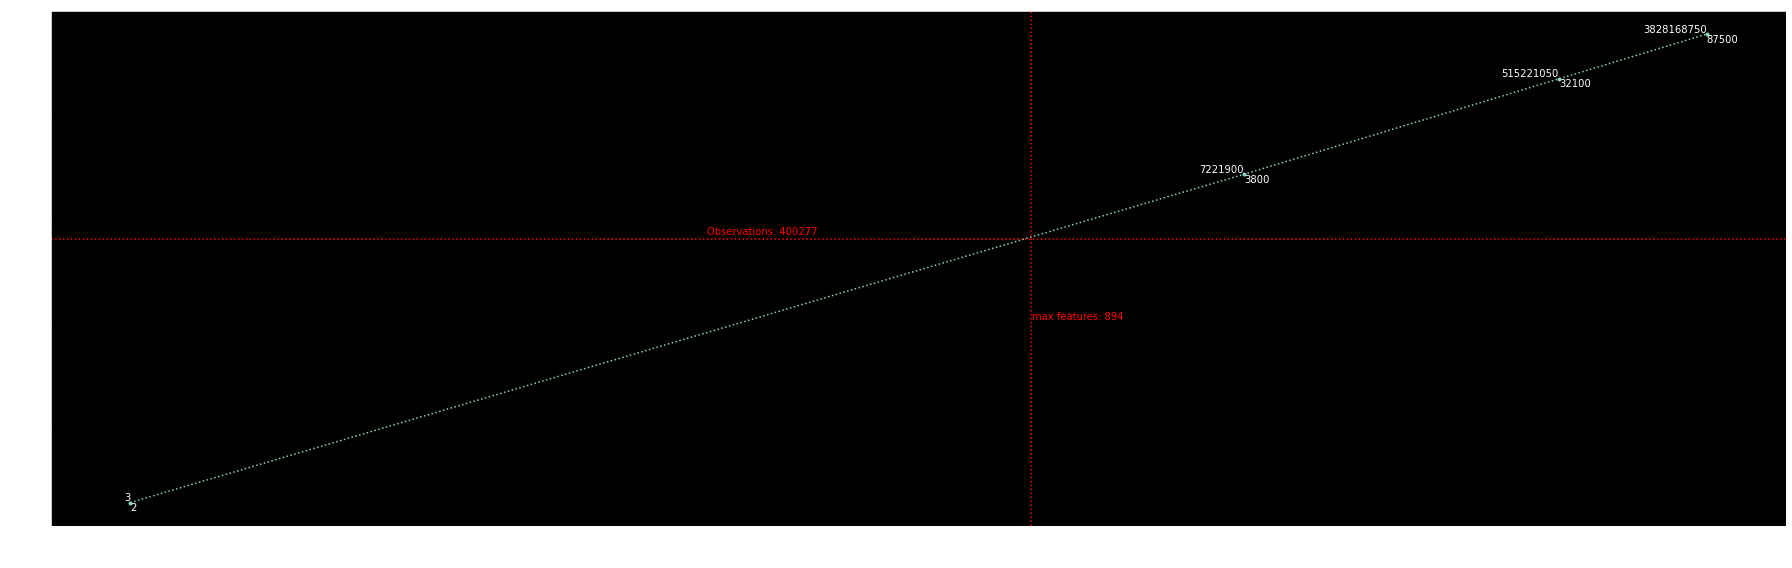

In [108]:
#feature_space = np.logspace(np.log10(2), np.log10(3800), 11)
feature_space = np.array([2, 3800, 32100, 87500])
interactions = (feature_space * (feature_space + 1) / 2).astype('int64')
max_features = int((np.sqrt(8 * df.shape[0] + 1) - 1) / 2)

plt.figure(figsize=(25,8))
plt.loglog(feature_space, interactions, marker='.', linestyle='dotted')
plt.axhline(df.shape[0] , linestyle='dotted', color='red')
plt.text(x=100, y=df.shape[0]*1.1, s='Observations: {}'.format(df.shape[0]), verticalalignment='bottom', color='red')

plt.axvline(max_features , linestyle='dotted', color='red')
plt.text(x=max_features*1.01, y=10**4, s='max features: {}'.format(max_features), verticalalignment='bottom', color='red')
for i,j in zip(feature_space, interactions):
    plt.text(i,j,j, horizontalalignment='right', verticalalignment='bottom')
    plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')
plt.xlabel('feature space')
plt.ylabel('interactions')
plt.tight_layout()
plt.show()

## Interacting different hashed n-grams from all text features

The next simulation takes all numeric and text features from the whole dataset and performs `HashingVectorizer`, `SelectKBest` and `PolynomialFeatures` under different parameters to understand memory limitations.  

For each `ngram_range` a specific parameter space is assigned.  Each space is a log space starting from $2^{2.5}$ to the limit of the `CountVectorizer` resulting features for a given `ngram_range`

In [109]:
# tracemalloc.start()
# threshold = psutil.virtual_memory().available
# print('Threshold/Free mem.: ', size(threshold))
# msg = '2^{}={} ngram:{},{} k:{} union:{} nnz:{} sparse:{:.4f}% size:{} peak:{} {:.0f}s iact:{} nnz:{} sparse:{:.4f}% size:{} peak:{} {:.0f}s'

# for i in np.arange(20, 21):
#     for ngram_range in [(1,1), (1,2), (1,3)]:
#         # for k in logspaces[ngram_range[1]-1]:
#         for k in [k_space[ngram_range[1]-1]]:
#             if k > 2**i:
#                 continue
#             union.set_params(text_features__vectorizer__n_features = 2**i,
#                              text_features__vectorizer__ngram_range = ngram_range,
#                              text_features__reduction__k = k)
#             t1=time()
#             un = union.fit_transform(df[FEATURES], dummy_labels)
#             t1=time()-t1
#             current, un_peak = tracemalloc.get_traced_memory()
#             un_nbytes = (un.data.nbytes + un.indptr.nbytes + un.indices.nbytes)

#             t2=time()
#             iact = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(un)
#             t2=time()-t2
#             current, peak = tracemalloc.get_traced_memory()
#             # tracemalloc.reset_peak()
#             current, iact_peak = tracemalloc.get_traced_memory()

#             iact_nbytes = (iact.data.nbytes + iact.indptr.nbytes + iact.indices.nbytes)

#             print(msg.format(i, 2**i, ngram_range[0], ngram_range[1],
#                              k, un.shape[1], un.nnz, (1 - un.nnz / (un.shape[0] * un.shape[1])) * 100,
#                              size(un_nbytes), size(un_peak), t1,
#                              iact.shape[1], iact.nnz, (1-iact.nnz/(iact.shape[0] * iact.shape[1])) * 100,
#                              size(iact_nbytes), size(iact_peak), t2))
#             if iact_peak >= threshold:
#                 print('\tReached threshold: {}'.format(size(threshold)))
#                 break
#         else:
#             continue  # only executed if the inner loop did NOT break
#         break  # only executed if the inner loop DID break
#     else:
#         continue  # likewise
#     break  # likewise
# tracemalloc.stop()

**Saved results:**
```
Last executed at 2022-07-25 19:34:49 in 2m 26.06s

Threshold/Free mem.:  58.7 GiB
2^20=1048576 ngram:1,1 k:3800 union:3805 nnz:7059842 sparse:99.5365% size:55.4 MiB peak:1.8 GiB 30s iact:7240915 nnz:72479455 sparse:99.9975% size:554.5 MiB peak:1.8 GiB 0s
2^20=1048576 ngram:1,2 k:32100 union:32105 nnz:13936889 sparse:99.8915% size:107.9 MiB peak:2.5 GiB 47s iact:515381565 nnz:280886208 sparse:99.9999% size:2.1 GiB peak:6.8 GiB 2s
2^20=1048576 ngram:1,3 k:87500 union:87505 nnz:20657712 sparse:99.9410% size:159.1 MiB peak:6.8 GiB 60s iact:3828606265 nnz:619522148 sparse:100.0000% size:6.9 GiB peak:22.8 GiB 6s
```

## Feature scaling

[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), also known as data normalization, is a method used to normalize the range of independent variables or features of data.

See [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

One can use different **scalers, transformers, and normalizers** to bring the data within a pre-defined range.

Scalers are **linear transformers** (more precisely [affine transformers](https://en.wikipedia.org/wiki/Affine_transformation)) and differ from each other in the way to estimate the parameters used to shift and scale **each feature**:
* `StandardScaler` - standardizes features by removing the mean and scaling to unit variance
* `MinMaxScaler` - transforms features by scaling each feature to a given range, default (0, 1)
* `MaxAbsScaler` - scales each feature by its maximum absolute value to a range (-1, 1)
* `RobustScaler` - scales features using statistics that are robust to outliers

Transformers provides non-linear transformations:
* `QuantileTransformer` - transforms features using quantiles information, where distances between marginal outliers and inliers are shrunk.
* `PowerTransformer` - applies a power transform featurewise to make data more Gaussian-like, where data is mapped to a normal distribution to stabilize variance and minimize skewness.

Unlike the previous transformations, normalization refers to a **per sample** transformation instead of a **per feature** transformation:
* `Normalizer` - normalizes samples individually to unit norm
> Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community.

Initial considerations:
* `StandardScaler`, `MinMaxScaler` are very sensitive to the presence of outliers.
* `MinMaxScaler` doesn´t support sparse input
* On positive only data, `MaxAbsScaler` behaves similarly to MinMaxScaler, suffering from the presence of large outliers.
* The centering and scaling statistics of the `RobustScaler` are based on percentiles and not influenced by a few number of very large marginal outliers. The resulting range of the transformed feature values is larger than for the previous scalers and are approximately similar.
* `PowerTransformer(method='Yeo-Johnson')` can be applied to both negative and positive data. Requires dense input.
* `PowerTransformer(method='Box-Cox')` can only be applied to strictly positive data. Requires dense input.
* `QuantileTransformer(output_distribution='gaussian')`: Note that this non-parametetric transformer introduces saturation artifacts for outliers.
* `QuantileTransformer(output_distribution='uniform')` as `RobustScaler`, are robust to outliers but they will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

Final considerations:

For this problem, we need to scale a sparse matrix without destroying any sparsity, i.e., non-stored zero values should continue being like that.  The scalers/settings supporting that are:
* `StandardScaler(with_mean=False)`
* `MaxAbsScaler`
* `RobustScaler(with_centering=False)`
* `Normalizer(norm='l2')`
* `Normalizer(norm='l1')`

From these, the only scaler not sensible to outliers is the `RobustScaler`

In [110]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, Normalizer

In [111]:
tracemalloc.start()
scalers = [("StandardScaler(with_mean=False)       ", StandardScaler(with_mean=False)), # because True doesn't work with sparse matrix
           ("MaxAbsScaler()                        ", MaxAbsScaler()),
           ("Normalizer(norm='l2')                 ", Normalizer(norm='l2')),
           ("Normalizer(norm='l1')                 ", Normalizer(norm='l1')),
           #('RobustScaler(with_centering=False)', RobustScaler(with_centering=False)) # takes much too long
          ]
union.set_params(text_features__reduction__k = 3800)
print('Threshold/Free mem.: ', size(psutil.virtual_memory().available))

t=time()
tdm = union.fit_transform(df[FEATURES], dummy_labels)
print('Union elapsed: {:.0f}s'.format(time()-t))
current, peak = tracemalloc.get_traced_memory()
print('Memory peak after union:', size(peak))

t=time()
tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(tdm)
print('Interaction elapsed: {:.0f}s'.format(time()-t))
current, peak = tracemalloc.get_traced_memory()
sparsity = (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100
tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)

display(tdm)

msg = 'nnz: {} sparsity: {:.4f}% min: {} max: {} nbytes: {} peak: {} time: {:.0f}s'
print(msg.format(tdm.nnz, sparsity, tdm.min(), tdm.max(), size(tdm_nbytes), size(peak), t))

Threshold/Free mem.:  58.0 GiB
Union elapsed: 30s
Memory peak after union: 1.8 GiB
Interaction elapsed: 0s


<400277x7240915 sparse matrix of type '<class 'numpy.float32'>'
	with 72479455 stored elements in Compressed Sparse Row format>

nnz: 72479455 sparsity: 99.9975% min: -262398912.0 max: 259400000.0 nbytes: 554.5 MiB peak: 1.8 GiB time: 1658878116s


**Saved results:**
```
Last executed at 2022-07-25 22:07:37 in 30.90s

Threshold/Free mem.:  58.1 GiB
Union elapsed: 30s
Memory peak after union: 1.8 GiB
Interaction elapsed: 0s

<400277x7240915 sparse matrix of type '<class 'numpy.float32'>'
	with 72479455 stored elements in Compressed Sparse Row format>

nnz: 72479455 sparsity: 99.9975% min: -262398912.0 max: 259400000.0 nbytes: 554.5 MiB peak: 1.8 GiB time: 1658797657s
```

In [112]:
for name, scaler in scalers:
    t=time()
    tdm2 = scaler.fit_transform(tdm, dummy_labels)
    t=time()-t
    current, peak = tracemalloc.get_traced_memory()
    msg = 'min: {:>20} max: {:>20} peak_wset: {} time: {:.0f}s'
    print(name, msg.format(tdm2.min(), tdm2.max(), size(peak), t))

StandardScaler(with_mean=False)        min:     -632.67529296875 max:      632.67529296875 peak_wset: 2.4 GiB time: 1s
MaxAbsScaler()                         min:                 -1.0 max:                  1.0 peak_wset: 2.7 GiB time: 2s
Normalizer(norm='l2')                  min:  -0.8111070990562439 max:   0.9954653382301331 peak_wset: 2.7 GiB time: 0s
Normalizer(norm='l1')                  min: -0.27777546644210815 max:   0.8239297270774841 peak_wset: 2.7 GiB time: 0s


**Saved results:**  
```
Last executed at 2022-07-25 22:07:41 in 3.65s

StandardScaler(with_mean=False)        min:     -632.67529296875 max:      632.67529296875 peak_wset: 2.4 GiB time: 1s
MaxAbsScaler()                         min:                 -1.0 max:                  1.0 peak_wset: 2.7 GiB time: 2s
Normalizer(norm='l2')                  min:  -0.8111070990562439 max:   0.9954653382301331 peak_wset: 2.7 GiB time: 0s
Normalizer(norm='l1')                  min: -0.27777546644210815 max:   0.8239297270774841 peak_wset: 2.7 GiB time: 0s
```

## Pipeline: Logistic Regression

In [113]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, PolynomialFeatures
from preprocessing.combine_text_columns import combine_text_columns
from sklearn.metrics import classification_report
from metrics.log_loss import multi_multi_log_loss
from metrics.log_loss import log_loss_report_part, log_loss_report
from dummies import get_dummies_indices
from model_selection.multilabel import multilabel_train_test_split, multilabel_sample_dataframe
from preprocessing.get_normalized_total import get_normalized_total
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': NUMERIC_FEATURES + LABELS})
get_numeric_data = FunctionTransformer(get_normalized_total, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total'})
pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', Pipeline([
            ('numeric_selector', get_numeric_data),
            ('imputer', SimpleImputer(strategy='constant', fill_value=0))
        ], verbose=True)),
        ('text_features' , Pipeline([
            ('text_selector', get_text_data),
            ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, dtype='float32')),
            ('reducer', SelectKBest(chi2))
        ], verbose=True))
    ], #n_jobs=None
    )),
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', MaxAbsScaler()),
    ('classifier', OneVsRestClassifier(LogisticRegression()))
], verbose=True)

### 0.008 train

In [114]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.01, min_count=7, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'),
                                size=0.2, min_count=1, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

Training: 3202, testing: 800


In [115]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = 1000)
pl.set_params(classifier__n_jobs = 16)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
modelname = '0.008-k1000-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Loading cache 0.008-k1000-logistic-regression-C1 ... done: 0.0 minutes


**Saved results**
```
Last executed at 2022-07-26 17:10:48 in 1m 43.98s

Fitting started on 2022-07-26T17:09
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.6s
[Pipeline] ............. (step 1 of 4) Processing union, total=   5.8s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.6min
Done: 1.7 minutes
Saving cache 0.008-k1000-logistic-regression-C1 ... Done: 0.0 minutes
Memory current 421.8 MiB peak 1.6 GiB
```

In [116]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-07-26T20:28
Training accuracy         : 0.9647
Training log loss         : 0.0484
Training log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.044343      0.014781
Sharing                 5  0.051419      0.010284
Operating_Status        3  0.023073      0.007691
Use                     8  0.058321      0.007290
Student_Type            9  0.048825      0.005425
Pre_K                   3  0.016130      0.005377
Object_Type            11  0.045628      0.004148
Function               37  0.091576      0.002475
Position_Type          25  0.055966      0.002239

Training log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                               2763   
Pre_K__NO_LABEL                                                   2419   
Reporting__School                                                 1975   
Sharing__School Reported                                          1960   
Student_Type__Unspecified                                         1769   
Use__Instruction                                                  1539   
Position_Type__NO_LABEL                                            795   
Reporting__Non-School                                              788   
Student_Type__NO_LABEL                                             781   
Position_Type__Teacher                                             755   
Object_Type__Base Salary/Compensation                              741   
Object_Type__Benefits                                              706   
Pre_K__Non PreK                                                    672   
Use__NO_LABEL                                                      637   
Function__Teacher Compensation                                     628   
Object_Type__NO_LABEL                                              535   
Object_Type__Other Compensation/Stipend                            510   
Position_Type__Substitute                                          476   
Sharing__NO_LABEL                                                  466   
Function__Substitute Compensation                                  463   
Function__NO_LABEL                                                 461   
Reporting__NO_LABEL                                                439   
Sharing__Shared Services                                           400   
Use__O&M                                                           374   
Operating_Status__Non-Operating                                    370   
Student_Type__Special Education                                    334   
Position_Type__Other                                               306   
Object_Type__Supplies/Materials                                    255   
Use__Pupil Services & Enrichment                                   215   
Sharing__School on Central Budgets                                 214   
Use__ISPD                                                          208   
Object_Type__Substitute Compensation                               207   
Position_Type__TA                                                  180   
Position_Type__Non-Position                                        173   
Sharing__Leadership & Management                                   162   
Function__Professional Development                                 155   
Function__Aides Compensation                                       154   
Function__Instructional Materials & Supplies                       148   
Student_Type__Poverty                                              146   
Function__Facilities & Maintenance                                 146   
Use__Leadership                                                    142   
Function__Student Transportation                                   128   
Pre_K__PreK                                                        111   
Function__School Administration                                    110   
Function__Food Services                                            104   
Function__Enrichment                                                85   
Function__Extended Time & Tutoring                                  80   
Use__Business Services                                              76   
Position_Type__Custodian                                            71   
Operating_Status__Operating, Not PreK-12                            69   
Position_Type__Sec/Clerk/Other Admin                                67   
Function__Physical Health & Services                                67   
Object_Type__Contracted Services                                    66   
Student_Type__ELL                                              

Training classification Report:


precision  \
Function__Other Compensation                                1.000000   
Operating_Status__Operating, Not PreK-12                    1.000000   
Position_Type__Physical Therapist                           1.000000   
Function__School Supervision                                0.954545   
Student_Type__Alternative                                   1.000000   
Position_Type__Nurse                                        1.000000   
Position_Type__Occupational Therapist                       1.000000   
Function__Extended Time & Tutoring                          0.986486   
Function__Untracked Budget Set-Aside                        1.000000   
Use__Untracked Budget Set-Aside                             1.000000   
Function__Library & Media                                   0.953488   
Student_Type__ELL                                           1.000000   
Object_Type__Substitute Compensation                        1.000000   
Function__Special Population Program Management & Support   0.953488   
Position_Type__Social Worker                                1.000000   
Function__Enrichment                                        0.976190   
Function__Career & Academic Counseling                      1.000000   
Function__Instructional Materials & Supplies                0.960526   
Function__Utilities                                         1.000000   
Object_Type__Other Non-Compensation                         0.966667   
Function__Food Services                                     0.971429   
Object_Type__Supplies/Materials                             0.972763   
Position_Type__Principal                                    1.000000   
Function__NO_LABEL                                          0.993304   
Reporting__NO_LABEL                                         0.992974   
Position_Type__Librarian                                    1.000000   
Function__Data Processing & Information Services            1.000000   
Sharing__NO_LABEL                                           0.991228   
Function__Curriculum Development                            1.000000   
Use__Pupil Services & Enrichment                            0.990521   
Pre_K__PreK                                                 0.990826   
Student_Type__Special Education                             0.990854   
Position_Type__Non-Position                                 1.000000   
Function__Substitute Compensation                           1.000000   
Object_Type__NO_LABEL                                       0.994264   
Position_Type__Guidance Counselor                           1.000000   
Object_Type__Rent/Utilities                                 1.000000   
Function__Physical Health & Services                        1.000000   
Function__School Administration                             0.990826   
Position_Type__Club Advisor/Coach                           0.973684   
Use__NO_LABEL                                               0.995215   
Function__Teacher Compensation                              0.985759   
Function__Facilities & Maintenance                          0.993103   
Sharing__Shared Services                                    0.992462   
Function__Professional Development                          1.000000   
Sharing__Leadership & Management                            1.000000   
Position_Type__Other                                        0.996700   
Use__O&M                                                    0.991979   
Object_Type__Contracted Services                            0.985075   
Position_Type__Sec/Clerk/Other Admin                        1.000000   
Use__ISPD                                                   1.000000   
Position_Type__Custodian                                    0.986111   
Student_Type__Poverty                                       0.993151   
Operating_Status__Non-Operating                             0.991914   
Function__Aides Compensation                                1.000000   
Student_Type__Unspecified  

precision    recall  f1-score  support
micro avg      0.993939  0.990180  0.992056  28818.0
macro avg      0.994565  0.974286  0.983749  28818.0
weighted avg   0.993966  0.990180  0.991976  28818.0
samples avg    0.993816  0.990180  0.991717  28818.0

Training report finished on 2022-07-26T20:28, elapsed 0.0 minutes

Testing report started on 2022-07-26T20:28
Testing accuracy         : 0.6388
Testing log loss         : 0.3132
Testing log loss by label:


classes  log_loss  avg_log_loss
Sharing                 5  0.367796      0.073559
Reporting               3  0.209586      0.069862
Use                     8  0.443696      0.055462
Pre_K                   3  0.115394      0.038465
Operating_Status        3  0.102196      0.034065
Student_Type            9  0.265563      0.029507
Object_Type            11  0.238822      0.021711
Function               37  0.704858      0.019050
Position_Type          25  0.371047      0.014842

Testing log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                                704   
Pre_K__NO_LABEL                                                    592   
Reporting__School                                                  477   
Student_Type__Unspecified                                          474   
Sharing__School Reported                                           469   
Use__Instruction                                                   380   
Reporting__Non-School                                              227   
Object_Type__Base Salary/Compensation                              205   
Pre_K__Non PreK                                                    186   
Position_Type__Teacher                                             183   
Position_Type__NO_LABEL                                            175   
Student_Type__NO_LABEL                                             170   
Object_Type__Benefits                                              159   
Function__Teacher Compensation                                     148   
Object_Type__Other Compensation/Stipend                            140   
Use__NO_LABEL                                                      134   
Position_Type__Substitute                                          115   
Function__Substitute Compensation                                  115   
Object_Type__NO_LABEL                                              113   
Sharing__NO_LABEL                                                  101   
Function__NO_LABEL                                                  98   
Reporting__NO_LABEL                                                 96   
Use__O&M                                                            89   
Sharing__Shared Services                                            89   
Student_Type__Special Education                                     81   
Position_Type__Other                                                80   
Sharing__School on Central Budgets                                  79   
Operating_Status__Non-Operating                                     76   
Object_Type__Supplies/Materials                                     68   
Use__Pupil Services & Enrichment                                    67   
Sharing__Leadership & Management                                    62   
Use__ISPD                                                           61   
Position_Type__Non-Position                                         59   
Object_Type__Substitute Compensation                                52   
Position_Type__TA                                                   49   
Function__Aides Compensation                                        41   
Function__Professional Development                                  38   
Use__Leadership                                                     37   
Function__Instructional Materials & Supplies                        37   
Student_Type__Poverty                                               33   
Function__Food Services                                             33   
Function__Facilities & Maintenance                                  26   
Use__Business Services                                              26   
Position_Type__Coordinator/Manager                                  25   
Function__Student Transportation                                    24   
Function__Physical Health & Services                                23   
Function__School Administration                                     22   
Pre_K__PreK                                                         22   
Function__Enrichment                                                22   
Function__Curriculum Development                                    20   
Operating_Status__Operating, Not PreK-12                            20   
Function__Extended Time & Tutoring                                  20   
Position_Type__Instructional Coach                                  16   
Student_Type__ELL                                              

Testing classification Report:


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  \
Function__Legal                                             0.000000   
Function__Parent & Community Relations                      0.000000   
Position_Type__Physical Therapist                           0.000000   
Student_Type__Alternative                                   0.000000   
Function__Development & Fundraising                         0.000000   
Function__Other Non-Compensation                            0.500000   
Use__Untracked Budget Set-Aside                             0.500000   
Function__Untracked Budget Set-Aside                        0.500000   
Function__Other Compensation                                1.000000   
Function__Curriculum Development                            0.571429   
Function__Student Assignment                                1.000000   
Function__Human Resources                                   1.000000   
Position_Type__Librarian                                    1.000000   
Position_Type__School Monitor/Security                      1.000000   
Function__Finance, Budget, Purchasing & Distribution        1.000000   
Object_Type__Contracted Services                            0.800000   
Position_Type__Instructional Coach                          1.000000   
Position_Type__Occupational Therapist                       1.000000   
Position_Type__Social Worker                                1.000000   
Function__Data Processing & Information Services            0.714286   
Function__Professional Development                          0.888889   
Function__Utilities                                         1.000000   
Function__School Supervision                                1.000000   
Student_Type__ELL                                           0.875000   
Object_Type__Rent/Utilities                                 0.666667   
Function__Library & Media                                   0.666667   
Use__ISPD                                                   0.909091   
Sharing__Leadership & Management                            0.864865   
Function__Enrichment                                        0.857143   
Operating_Status__Operating, Not PreK-12                    1.000000   
Object_Type__Travel & Conferences                           1.000000   
Object_Type__Other Non-Compensation                         0.800000   
Object_Type__Equipment & Equipment Lease                    1.000000   
Position_Type__Vice Principal                               1.000000   
Position_Type__(Exec) Director                              1.000000   
Function__Research & Accountability                         1.000000   
Function__Governance                                        1.000000   
Function__Communications                                    1.000000   
Function__Special Population Program Management & Support   1.000000   
Use__Business Services                                      0.888889   
Student_Type__PreK                                          0.875000   
Use__Pupil Services & Enrichment                            0.975610   
Pre_K__PreK                                                 1.000000   
Position_Type__Coordinator/Manager                          0.888889   
Function__Social & Emotional                                1.000000   
Position_Type__Speech Therapist                             1.000000   
Sharing__Shared Services                                    0.835616   
Function__School Administration                             0.739130   
Position_Type__Non-Position                                 0.928571   
Function__Extended Time & Tutoring                          0.739130   
Function__Security & Safety                                 1.000000   
Sharing__School on Central Budgets                          0.920635   
Function__Facilities & Maintenance                          0.840000   
Student_Type__Special Education                             0.937500   
Position_Type__Other                                        0.910448   
Student_Type__Gifted       

precision    recall  f1-score  support
micro avg      0.937620  0.878889  0.907305   7200.0
macro avg      0.876359  0.650659  0.721803   7200.0
weighted avg   0.934038  0.878889  0.899106   7200.0
samples avg    0.933904  0.878889  0.899606   7200.0

Testing report finished on 2022-07-26T20:28, elapsed 0.0 minutes



In [117]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


### 0.08 train

In [118]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.1, min_count=2, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'),
                                size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

Training: 32022, testing: 8005


In [119]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = 1000)
pl.set_params(classifier__n_jobs = 16)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
modelname = '0.08-k1000-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Loading cache 0.08-k1000-logistic-regression-C1 ... done: 0.0 minutes


**Saved results**
```
Last executed at 2022-07-26 17:16:34 in 1m 49.01s

Fitting started on 2022-07-26T17:14
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.3s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.8s
[Pipeline] ............. (step 1 of 4) Processing union, total=   7.8s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.7min
Done: 1.8 minutes
Saving cache 0.08-k1000-logistic-regression-C1 ... Done: 0.0 minutes
Memory current 422.5 MiB peak 1.7 GiB
```

In [120]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-07-26T20:29
Training accuracy         : 0.9557
Training log loss         : 0.0441
Training log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.042134      0.014045
Sharing                 5  0.050829      0.010166
Operating_Status        3  0.027144      0.009048
Use                     8  0.054785      0.006848
Pre_K                   3  0.016000      0.005333
Student_Type            9  0.043980      0.004887
Object_Type            11  0.035518      0.003229
Function               37  0.086477      0.002337
Position_Type          25  0.039839      0.001594

Training log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                              27416   
Pre_K__NO_LABEL                                                  24513   
Reporting__School                                                20532   
Sharing__School Reported                                         20298   
Student_Type__Unspecified                                        17821   
Use__Instruction                                                 16268   
Position_Type__Teacher                                            8197   
Student_Type__NO_LABEL                                            8059   
Position_Type__NO_LABEL                                           7802   
Object_Type__Base Salary/Compensation                             7771   
Function__Teacher Compensation                                    6915   
Reporting__Non-School                                             6884   
Object_Type__Benefits                                             6845   
Pre_K__Non PreK                                                   6488   
Use__NO_LABEL                                                     6410   
Object_Type__NO_LABEL                                             5680   
Position_Type__Substitute                                         5137   
Function__Substitute Compensation                                 5008   
Object_Type__Other Compensation/Stipend                           4864   
Function__NO_LABEL                                                4842   
Sharing__NO_LABEL                                                 4834   
Reporting__NO_LABEL                                               4606   
Operating_Status__Non-Operating                                   3940   
Use__O&M                                                          3652   
Sharing__Shared Services                                          3372   
Student_Type__Special Education                                   3316   
Position_Type__Other                                              2949   
Object_Type__Supplies/Materials                                   2548   
Object_Type__Substitute Compensation                              2203   
Sharing__School on Central Budgets                                2182   
Use__ISPD                                                         2052   
Use__Pupil Services & Enrichment                                  1902   
Position_Type__TA                                                 1798   
Position_Type__Non-Position                                       1757   
Function__Facilities & Maintenance                                1578   
Function__Aides Compensation                                      1573   
Function__Instructional Materials & Supplies                      1534   
Function__Professional Development                                1485   
Student_Type__Poverty                                             1427   
Sharing__Leadership & Management                                  1336   
Use__Leadership                                                   1231   
Function__Food Services                                           1171   
Function__Student Transportation                                  1115   
Pre_K__PreK                                                       1021   
Function__School Administration                                   1020   
Function__Enrichment                                               833   
Position_Type__Custodian                                           785   
Position_Type__Sec/Clerk/Other Admin                               715   
Function__Extended Time & Tutoring                                 672   
Operating_Status__Operating, Not PreK-12                           666   
Function__Curriculum Development                                   627   
Object_Type__Contracted Services                                   595   
Position_Type__Coordinator/Manager                                 557   
Object_Type__Other Non-Compensation                            

Training classification Report:


precision  \
Use__Untracked Budget Set-Aside                             0.888889   
Function__Untracked Budget Set-Aside                        0.888889   
Operating_Status__Operating, Not PreK-12                    0.986867   
Position_Type__Area Officers                                0.888889   
Function__Extended Time & Tutoring                          0.880640   
Student_Type__Alternative                                   1.000000   
Function__Other Compensation                                1.000000   
Function__School Supervision                                0.994413   
Function__Enrichment                                        0.977333   
Function__Human Resources                                   0.990196   
Function__Utilities                                         0.963504   
Student_Type__ELL                                           0.985263   
Function__Finance, Budget, Purchasing & Distribution        0.957831   
Function__Special Population Program Management & Support   0.953623   
Function__Curriculum Development                            0.976231   
Use__Pupil Services & Enrichment                            0.986096   
Object_Type__Rent/Utilities                                 0.968872   
Function__Career & Academic Counseling                      0.991266   
Function__Data Processing & Information Services            0.995726   
Function__Other Non-Compensation                            0.985294   
Position_Type__Non-Position                                 0.980600   
Function__Professional Development                          0.981302   
Function__Security & Safety                                 0.985981   
Sharing__NO_LABEL                                           0.985662   
Function__Social & Emotional                                0.987562   
Use__ISPD                                                   0.989356   
Student_Type__Special Education                             0.969296   
Function__Library & Media                                   0.959893   
Pre_K__PreK                                                 0.995881   
Function__School Administration                             0.980060   
Function__Instructional Materials & Supplies                0.954717   
Object_Type__Other Non-Compensation                         0.984991   
Object_Type__Contracted Services                            0.974705   
Function__NO_LABEL                                          0.988913   
Reporting__NO_LABEL                                         0.989238   
Object_Type__Equipment & Equipment Lease                    0.963303   
Position_Type__Club Advisor/Coach                           0.958065   
Function__Governance                                        1.000000   
Sharing__Leadership & Management                            0.986963   
Object_Type__NO_LABEL                                       0.991679   
Use__Leadership                                             0.991681   
Object_Type__Supplies/Materials                             0.967125   
Position_Type__Instructional Coach                          0.997481   
Function__Research & Accountability                         1.000000   
Position_Type__Librarian                                    1.000000   
Sharing__Shared Services                                    0.988017   
Use__NO_LABEL                                               0.991745   
Student_Type__Gifted                                        0.991870   
Function__Parent & Community Relations                      0.994624   
Operating_Status__Non-Operating                             0.987736   
Function__Facilities & Maintenance                          0.981120   
Function__Recruitment                                       1.000000   
Function__Physical Health & Services                        0.989083   
Position_Type__Coordinator/Manager                          0.992727   
Position_Type__Guidance Counselor                           0.990431   
Use__Business Services     

precision    recall  f1-score   support
micro avg      0.990244  0.987880  0.989060  288198.0
macro avg      0.985561  0.965694  0.975078  288198.0
weighted avg   0.990258  0.987880  0.988972  288198.0
samples avg    0.989993  0.987880  0.988763  288198.0

Training report finished on 2022-07-26T20:29, elapsed 0.2 minutes

Testing report started on 2022-07-26T20:29
Testing accuracy         : 0.8753
Testing log loss         : 0.1071
Testing log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.087953      0.029318
Sharing                 5  0.130741      0.026148
Operating_Status        3  0.059238      0.019746
Use                     8  0.150815      0.018852
Pre_K                   3  0.042813      0.014271
Student_Type            9  0.100000      0.011111
Object_Type            11  0.075120      0.006829
Function               37  0.216132      0.005841
Position_Type          25  0.100898      0.004036

Testing log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                               6921   
Pre_K__NO_LABEL                                                   6112   
Reporting__School                                                 5239   
Sharing__School Reported                                          5188   
Student_Type__Unspecified                                         4502   
Use__Instruction                                                  4081   
Position_Type__Teacher                                            2068   
Object_Type__Base Salary/Compensation                             1944   
Student_Type__NO_LABEL                                            1925   
Position_Type__NO_LABEL                                           1890   
Object_Type__Benefits                                             1771   
Function__Teacher Compensation                                    1713   
Reporting__Non-School                                             1682   
Pre_K__Non PreK                                                   1655   
Use__NO_LABEL                                                     1510   
Object_Type__NO_LABEL                                             1339   
Position_Type__Substitute                                         1317   
Function__Substitute Compensation                                 1288   
Object_Type__Other Compensation/Stipend                           1256   
Sharing__NO_LABEL                                                 1138   
Function__NO_LABEL                                                1133   
Reporting__NO_LABEL                                               1084   
Operating_Status__Non-Operating                                    926   
Use__O&M                                                           890   
Student_Type__Special Education                                    862   
Sharing__Shared Services                                           789   
Position_Type__Other                                               743   
Object_Type__Supplies/Materials                                    625   
Object_Type__Substitute Compensation                               568   
Use__ISPD                                                          555   
Sharing__School on Central Budgets                                 532   
Position_Type__TA                                                  482   
Use__Pupil Services & Enrichment                                   477   
Function__Aides Compensation                                       414   
Function__Professional Development                                 410   
Function__Facilities & Maintenance                                 387   
Student_Type__Poverty                                              387   
Position_Type__Non-Position                                        382   
Function__Instructional Materials & Supplies                       365   
Sharing__Leadership & Management                                   358   
Use__Leadership                                                    346   
Function__School Administration                                    290   
Function__Food Services                                            277   
Function__Student Transportation                                   260   
Pre_K__PreK                                                        238   
Function__Enrichment                                               213   
Position_Type__Sec/Clerk/Other Admin                               196   
Position_Type__Custodian                                           196   
Function__Extended Time & Tutoring                                 172   
Operating_Status__Operating, Not PreK-12                           158   
Function__Curriculum Development                                   156   
Object_Type__Contracted Services                                   145   
Position_Type__Coordinator/Manager                                 141   
Use__Business Services                                         

Testing classification Report:


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  \
Function__Development & Fundraising                         0.000000   
Use__Untracked Budget Set-Aside                             0.250000   
Function__Untracked Budget Set-Aside                        0.250000   
Function__Communications                                    1.000000   
Function__Governance                                        0.800000   
Function__Other Non-Compensation                            0.857143   
Function__Finance, Budget, Purchasing & Distribution        0.888889   
Function__Special Population Program Management & Support   0.859375   
Function__Student Assignment                                1.000000   
Function__School Supervision                                0.944444   
Function__Parent & Community Relations                      0.833333   
Function__Human Resources                                   1.000000   
Student_Type__Alternative                                   1.000000   
Function__Other Compensation                                1.000000   
Position_Type__Nurse Aide                                   1.000000   
Function__Extended Time & Tutoring                          0.828571   
Sharing__Leadership & Management                            0.914754   
Use__Business Services                                      0.955357   
Function__Data Processing & Information Services            0.961538   
Function__Curriculum Development                            0.945736   
Position_Type__Area Officers                                1.000000   
Operating_Status__Operating, Not PreK-12                    0.968254   
Function__Social & Emotional                                0.962025   
Function__Enrichment                                        0.934783   
Object_Type__Other Non-Compensation                         0.912621   
Position_Type__Non-Position                                 0.932353   
Student_Type__ELL                                           0.955357   
Use__ISPD                                                   0.948454   
Function__Career & Academic Counseling                      0.887097   
Object_Type__Equipment & Equipment Lease                    0.887500   
Object_Type__Contracted Services                            0.931818   
Use__Leadership                                             0.953642   
Use__Pupil Services & Enrichment                            0.937500   
Function__Utilities                                         0.953488   
Position_Type__Instructional Coach                          0.940476   
Function__Professional Development                          0.946237   
Function__Research & Accountability                         0.923077   
Function__Physical Health & Services                        0.983193   
Function__Security & Safety                                 0.956522   
Position_Type__Coordinator/Manager                          0.933333   
Object_Type__Rent/Utilities                                 0.981481   
Function__School Administration                             0.948148   
Function__Library & Media                                   0.949367   
Position_Type__Occupational Therapist                       1.000000   
Position_Type__(Exec) Director                              1.000000   
Sharing__Shared Services                                    0.951743   
Pre_K__PreK                                                 0.967890   
Object_Type__Travel & Conferences                           0.958763   
Position_Type__Librarian                                    1.000000   
Function__Instructional Materials & Supplies                0.924731   
Sharing__School on Central Budgets                          0.953033   
Sharing__NO_LABEL                                           0.953467   
Function__NO_LABEL                                          0.960222   
Student_Type__Special Education                             0.955475   
Reporting__NO_LABEL                                         0.960463   
Position_Type__Sec/Clerk/Ot

precision    recall  f1-score  support
micro avg      0.975526  0.963773  0.969614  72045.0
macro avg      0.939497  0.852668  0.887259  72045.0
weighted avg   0.975044  0.963773  0.968880  72045.0
samples avg    0.974427  0.963773  0.968111  72045.0

Testing report finished on 2022-07-26T20:29, elapsed 0.1 minutes



In [121]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


### 0.16 train

In [122]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.2, min_count=2, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'),
                                size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

Training: 64044, testing: 16011


In [123]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = 1000)
pl.set_params(classifier__n_jobs = 16)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
modelname = '0.16-k1000-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Loading cache 0.16-k1000-logistic-regression-C1 ... done: 0.0 minutes


**Saved results**
```
Last executed at 2022-07-26 17:30:43 in 3m 37.50s

Fitting started on 2022-07-26T17:27
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   1.4s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.6s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   6.0s
[Pipeline] ............. (step 1 of 4) Processing union, total=  10.1s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.2s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 3.5min
Done: 3.6 minutes
Saving cache 0.16-k1000-logistic-regression-C1 ... Done: 0.0 minutes
Memory current 423.6 MiB peak 1.7 GiB
```

In [124]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-07-26T20:29
Training accuracy         : 0.9535
Training log loss         : 0.0449
Training log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.044264      0.014755
Sharing                 5  0.052412      0.010482
Operating_Status        3  0.029562      0.009854
Use                     8  0.057137      0.007142
Pre_K                   3  0.017662      0.005887
Student_Type            9  0.044919      0.004991
Object_Type            11  0.034715      0.003156
Function               37  0.086564      0.002340
Position_Type          25  0.036800      0.001472

Training log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                              54939   
Pre_K__NO_LABEL                                                  48972   
Reporting__School                                                41195   
Sharing__School Reported                                         40748   
Student_Type__Unspecified                                        35697   
Use__Instruction                                                 32610   
Position_Type__Teacher                                           16372   
Student_Type__NO_LABEL                                           15943   
Position_Type__NO_LABEL                                          15658   
Object_Type__Base Salary/Compensation                            15490   
Function__Teacher Compensation                                   13767   
Reporting__Non-School                                            13744   
Object_Type__Benefits                                            13699   
Pre_K__Non PreK                                                  13022   
Use__NO_LABEL                                                    12560   
Object_Type__NO_LABEL                                            11141   
Position_Type__Substitute                                        10227   
Function__Substitute Compensation                                10006   
Object_Type__Other Compensation/Stipend                           9891   
Function__NO_LABEL                                                9561   
Sharing__NO_LABEL                                                 9553   
Reporting__NO_LABEL                                               9105   
Operating_Status__Non-Operating                                   7701   
Use__O&M                                                          7337   
Student_Type__Special Education                                   6684   
Sharing__Shared Services                                          6667   
Position_Type__Other                                              5934   
Object_Type__Supplies/Materials                                   5143   
Object_Type__Substitute Compensation                              4408   
Sharing__School on Central Budgets                                4381   
Use__ISPD                                                         4217   
Use__Pupil Services & Enrichment                                  3731   
Position_Type__TA                                                 3701   
Position_Type__Non-Position                                       3383   
Function__Aides Compensation                                      3232   
Function__Facilities & Maintenance                                3152   
Function__Instructional Materials & Supplies                      3115   
Function__Professional Development                                3080   
Student_Type__Poverty                                             2928   
Sharing__Leadership & Management                                  2695   
Use__Leadership                                                   2545   
Function__Food Services                                           2275   
Function__Student Transportation                                  2236   
Function__School Administration                                   2099   
Pre_K__PreK                                                       2050   
Function__Enrichment                                              1646   
Position_Type__Custodian                                          1544   
Position_Type__Sec/Clerk/Other Admin                              1486   
Operating_Status__Operating, Not PreK-12                          1404   
Function__Extended Time & Tutoring                                1336   
Function__Curriculum Development                                  1216   
Object_Type__Contracted Services                                  1168   
Position_Type__Coordinator/Manager                                1122   
Object_Type__Other Non-Compensation                            

Training classification Report:


precision  \
Use__Untracked Budget Set-Aside                             1.000000   
Function__Untracked Budget Set-Aside                        1.000000   
Student_Type__Alternative                                   0.984127   
Operating_Status__Operating, Not PreK-12                    0.987421   
Function__Extended Time & Tutoring                          0.908367   
Function__School Supervision                                0.970270   
Function__Other Compensation                                0.990654   
Function__Enrichment                                        0.946203   
Function__Governance                                        0.989899   
Student_Type__ELL                                           0.979210   
Function__Human Resources                                   0.980676   
Function__Special Population Program Management & Support   0.942090   
Function__Curriculum Development                            0.990983   
Function__Finance, Budget, Purchasing & Distribution        0.987988   
Function__Data Processing & Information Services            0.975510   
Use__Pupil Services & Enrichment                            0.968459   
Function__Career & Academic Counseling                      0.979821   
Function__Utilities                                         0.972136   
Position_Type__Non-Position                                 0.974305   
Function__Other Non-Compensation                            0.982517   
Function__Library & Media                                   0.953333   
Sharing__NO_LABEL                                           0.985172   
Pre_K__PreK                                                 0.993289   
Function__Professional Development                          0.971391   
Position_Type__Area Officers                                0.933333   
Use__ISPD                                                   0.981169   
Student_Type__Special Education                             0.966836   
Function__Instructional Materials & Supplies                0.942770   
Function__Security & Safety                                 0.974943   
Function__NO_LABEL                                          0.987294   
Object_Type__Contracted Services                            0.968403   
Reporting__NO_LABEL                                         0.987823   
Function__Social & Emotional                                0.981982   
Function__Development & Fundraising                         1.000000   
Sharing__Leadership & Management                            0.992656   
Function__School Administration                             0.977885   
Object_Type__Equipment & Equipment Lease                    0.965909   
Object_Type__NO_LABEL                                       0.990114   
Object_Type__Supplies/Materials                             0.961908   
Use__Leadership                                             0.987164   
Position_Type__Librarian                                    0.997006   
Function__Communications                                    1.000000   
Use__NO_LABEL                                               0.990722   
Position_Type__Instructional Coach                          0.992629   
Function__Facilities & Maintenance                          0.983099   
Sharing__Shared Services                                    0.982839   
Object_Type__Rent/Utilities                                 0.974170   
Operating_Status__Non-Operating                             0.983316   
Function__Physical Health & Services                        0.989224   
Function__Research & Accountability                         0.990991   
Object_Type__Other Non-Compensation                         0.981273   
Function__Parent & Community Relations                      0.994100   
Position_Type__Club Advisor/Coach                           1.000000   
Position_Type__Coordinator/Manager                          0.990991   
Position_Type__Speech Therapist                             0.996835   
Function__Recruitment      

precision    recall  f1-score   support
micro avg      0.988939  0.986853  0.987895  576396.0
macro avg      0.986283  0.962652  0.973283  576396.0
weighted avg   0.988943  0.986853  0.987794  576396.0
samples avg    0.988732  0.986853  0.987637  576396.0

Training report finished on 2022-07-26T20:30, elapsed 0.4 minutes

Testing report started on 2022-07-26T20:30
Testing accuracy         : 0.8929
Testing log loss         : 0.0881
Testing log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.074409      0.024803
Sharing                 5  0.103607      0.020721
Operating_Status        3  0.054234      0.018078
Use                     8  0.118892      0.014862
Pre_K                   3  0.037118      0.012373
Student_Type            9  0.085547      0.009505
Object_Type            11  0.062468      0.005679
Function               37  0.174707      0.004722
Position_Type          25  0.081770      0.003271

Testing log loss by class:


occurrences  \
Student_Type__Unspecified                                         8951   
Operating_Status__PreK-12 Operating                              13756   
Pre_K__NO_LABEL                                                  12196   
Reporting__School                                                10301   
Sharing__School Reported                                         10182   
Use__Instruction                                                  8048   
Position_Type__Teacher                                            4138   
Student_Type__NO_LABEL                                            3964   
Object_Type__Base Salary/Compensation                             3944   
Position_Type__NO_LABEL                                           3844   
Function__Teacher Compensation                                    3464   
Reporting__Non-School                                             3455   
Object_Type__Benefits                                             3425   
Pre_K__Non PreK                                                   3316   
Use__NO_LABEL                                                     3167   
Object_Type__NO_LABEL                                             2772   
Position_Type__Substitute                                         2547   
Object_Type__Other Compensation/Stipend                           2487   
Function__Substitute Compensation                                 2471   
Function__NO_LABEL                                                2364   
Sharing__NO_LABEL                                                 2364   
Reporting__NO_LABEL                                               2255   
Operating_Status__Non-Operating                                   1921   
Use__O&M                                                          1902   
Sharing__Shared Services                                          1735   
Student_Type__Special Education                                   1708   
Position_Type__Other                                              1489   
Object_Type__Supplies/Materials                                   1247   
Object_Type__Substitute Compensation                              1086   
Use__ISPD                                                         1040   
Sharing__School on Central Budgets                                1031   
Use__Pupil Services & Enrichment                                   955   
Position_Type__TA                                                  897   
Position_Type__Non-Position                                        849   
Function__Facilities & Maintenance                                 805   
Function__Aides Compensation                                       770   
Function__Professional Development                                 758   
Function__Instructional Materials & Supplies                       728   
Sharing__Leadership & Management                                   699   
Student_Type__Poverty                                              679   
Use__Leadership                                                    645   
Function__Food Services                                            586   
Function__Student Transportation                                   577   
Function__School Administration                                    552   
Pre_K__PreK                                                        499   
Function__Enrichment                                               445   
Position_Type__Custodian                                           402   
Position_Type__Sec/Clerk/Other Admin                               363   
Function__Extended Time & Tutoring                                 357   
Operating_Status__Operating, Not PreK-12                           334   
Function__Curriculum Development                                   321   
Position_Type__Coordinator/Manager                                 303   
Object_Type__Contracted Services                                   288   
Object_Type__Other Non-Compensation                            

Testing classification Report:


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  \
Function__Development & Fundraising                         0.000000   
Function__Insurance                                         0.000000   
Function__Facilities Planning                               0.000000   
Use__Untracked Budget Set-Aside                             1.000000   
Function__Untracked Budget Set-Aside                        1.000000   
Function__Student Assignment                                1.000000   
Function__Governance                                        0.923077   
Function__Legal                                             1.000000   
Function__Communications                                    1.000000   
Position_Type__(Exec) Director                              1.000000   
Function__Human Resources                                   0.829787   
Function__Other Non-Compensation                            0.857143   
Position_Type__Area Officers                                1.000000   
Operating_Status__Operating, Not PreK-12                    0.959350   
Function__Research & Accountability                         0.977778   
Function__School Supervision                                0.986486   
Function__Special Population Program Management & Support   0.878788   
Function__Finance, Budget, Purchasing & Distribution        0.900000   
Student_Type__Alternative                                   1.000000   
Function__Other Compensation                                1.000000   
Function__Extended Time & Tutoring                          0.896341   
Function__Parent & Community Relations                      0.950000   
Function__Curriculum Development                            0.969112   
Function__Career & Academic Counseling                      0.948980   
Function__Data Processing & Information Services            0.946429   
Function__Social & Emotional                                0.930108   
Sharing__Leadership & Management                            0.958678   
Student_Type__ELL                                           0.956710   
Use__Leadership                                             0.953528   
Use__Business Services                                      0.945455   
Object_Type__Contracted Services                            0.937500   
Position_Type__Non-Position                                 0.929268   
Use__ISPD                                                   0.944729   
Function__Enrichment                                        0.934579   
Function__Utilities                                         0.948052   
Use__Pupil Services & Enrichment                            0.948775   
Student_Type__Gifted                                        0.955882   
Function__Library & Media                                   0.927711   
Position_Type__Coordinator/Manager                          0.960714   
Function__School Administration                             0.948473   
Function__Professional Development                          0.935570   
Object_Type__Rent/Utilities                                 0.953846   
Position_Type__Instructional Coach                          0.974747   
Object_Type__Equipment & Equipment Lease                    0.940120   
Sharing__NO_LABEL                                           0.962797   
Function__Instructional Materials & Supplies                0.917431   
Reporting__NO_LABEL                                         0.964486   
Function__NO_LABEL                                          0.964429   
Pre_K__PreK                                                 0.976344   
Sharing__Shared Services                                    0.956651   
Object_Type__Other Non-Compensation                         0.944238   
Student_Type__Special Education                             0.952014   
Function__Security & Safety                                 0.963636   
Position_Type__Physical Therapist                           1.000000   
Operating_Status__Non-Operating                             0.958068   
Object_Type__NO_LABEL      

precision    recall  f1-score   support
micro avg      0.977610  0.969910  0.973744  144099.0
macro avg      0.939597  0.856586  0.889233  144099.0
weighted avg   0.977368  0.969910  0.973284  144099.0
samples avg    0.976813  0.969910  0.972672  144099.0

Testing report finished on 2022-07-26T20:30, elapsed 0.1 minutes



In [125]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


### 0.8 train **(waiting 80% learning curve)**

In [126]:
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

Training: 320222, testing: 80055


In [127]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = 1000)
pl.set_params(classifier__n_jobs = 16)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
modelname = '0.8-k1000-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Loading cache 0.8-k1000-logistic-regression-C1 ... done: 0.0 minutes


**Saved results**
```
Last executed at 2022-07-26 18:12:20 in 23m 33.30s

Fitting started on 2022-07-26T17:48
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   1.3s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.0s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.1s
[Pipeline] ............. (step 1 of 4) Processing union, total=  10.4s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.4s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=23.4min
Done: 23.6 minutes
Saving cache 0.8-k1000-logistic-regression-C1 ... Done: 0.0 minutes
```

In [128]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-07-26T20:30
Training accuracy         : 0.9486
Training log loss         : 0.0448
Training log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.044823      0.014941
Operating_Status        3  0.031802      0.010601
Sharing                 5  0.052884      0.010577
Use                     8  0.055587      0.006948
Pre_K                   3  0.019936      0.006645
Student_Type            9  0.046100      0.005122
Object_Type            11  0.033429      0.003039
Function               37  0.084181      0.002275
Position_Type          25  0.034326      0.001373

Training log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                             274947   
Pre_K__NO_LABEL                                                 245124   
Reporting__School                                               205985   
Sharing__School Reported                                        203733   
Student_Type__Unspecified                                       178282   
Use__Instruction                                                163156   
Position_Type__Teacher                                           82171   
Student_Type__NO_LABEL                                           79846   
Object_Type__Base Salary/Compensation                            78075   
Position_Type__NO_LABEL                                          78024   
Function__Teacher Compensation                                   69059   
Reporting__Non-School                                            68962   
Object_Type__Benefits                                            68397   
Pre_K__Non PreK                                                  64880   
Use__NO_LABEL                                                    62882   
Object_Type__NO_LABEL                                            55612   
Position_Type__Substitute                                        50947   
Function__Substitute Compensation                                49853   
Object_Type__Other Compensation/Stipend                          49284   
Function__NO_LABEL                                               47565   
Sharing__NO_LABEL                                                47440   
Reporting__NO_LABEL                                              45275   
Operating_Status__Non-Operating                                  38372   
Use__O&M                                                         36682   
Sharing__Shared Services                                         34111   
Student_Type__Special Education                                  33684   
Position_Type__Other                                             30031   
Object_Type__Supplies/Materials                                  25649   
Object_Type__Substitute Compensation                             21990   
Sharing__School on Central Budgets                               21425   
Use__ISPD                                                        20833   
Use__Pupil Services & Enrichment                                 18979   
Position_Type__TA                                                18339   
Position_Type__Non-Position                                      16874   
Function__Aides Compensation                                     15966   
Function__Instructional Materials & Supplies                     15866   
Function__Facilities & Maintenance                               15648   
Function__Professional Development                               15171   
Student_Type__Poverty                                            14287   
Sharing__Leadership & Management                                 13513   
Use__Leadership                                                  12511   
Function__Student Transportation                                 11518   
Function__Food Services                                          11372   
Function__School Administration                                  10378   
Pre_K__PreK                                                      10218   
Function__Enrichment                                              8534   
Position_Type__Custodian                                          7735   
Position_Type__Sec/Clerk/Other Admin                              7029   
Operating_Status__Operating, Not PreK-12                          6903   
Function__Extended Time & Tutoring                                6723   
Function__Curriculum Development                                  6131   
Object_Type__Contracted Services                                  6022   
Position_Type__Coordinator/Manager                                5973   
Student_Type__ELL                                              

Training classification Report:


precision  \
Use__Untracked Budget Set-Aside                             0.953368   
Function__Untracked Budget Set-Aside                        0.953368   
Student_Type__Alternative                                   0.953177   
Function__Extended Time & Tutoring                          0.903571   
Operating_Status__Operating, Not PreK-12                    0.984412   
Function__School Supervision                                0.937627   
Function__Governance                                        0.955556   
Function__Enrichment                                        0.935438   
Function__Finance, Budget, Purchasing & Distribution        0.964565   
Function__Special Population Program Management & Support   0.958383   
Function__Human Resources                                   0.991649   
Function__Other Compensation                                0.966783   
Student_Type__ELL                                           0.973596   
Function__Curriculum Development                            0.967230   
Function__Data Processing & Information Services            0.984726   
Function__Other Non-Compensation                            0.946429   
Function__Career & Academic Counseling                      0.962054   
Position_Type__Non-Position                                 0.964959   
Use__Pupil Services & Enrichment                            0.961322   
Function__Utilities                                         0.972014   
Sharing__NO_LABEL                                           0.980127   
Use__ISPD                                                   0.976089   
Function__Professional Development                          0.970375   
Sharing__Leadership & Management                            0.972512   
Object_Type__Contracted Services                            0.956693   
Pre_K__PreK                                                 0.993954   
Function__Facilities Planning                               0.962963   
Function__Security & Safety                                 0.983908   
Function__NO_LABEL                                          0.983524   
Reporting__NO_LABEL                                         0.983998   
Function__Social & Emotional                                0.978227   
Function__Instructional Materials & Supplies                0.946857   
Function__Legal                                             0.978022   
Function__Development & Fundraising                         1.000000   
Student_Type__Special Education                             0.971110   
Object_Type__Equipment & Equipment Lease                    0.962057   
Function__School Administration                             0.974655   
Function__Recruitment                                       0.995134   
Object_Type__NO_LABEL                                       0.986814   
Function__Library & Media                                   0.963646   
Function__Parent & Community Relations                      0.982861   
Function__Communications                                    0.975806   
Use__Leadership                                             0.981961   
Operating_Status__Non-Operating                             0.979741   
Object_Type__Other Non-Compensation                         0.964174   
Object_Type__Supplies/Materials                             0.961467   
Sharing__Shared Services                                    0.978135   
Function__Facilities & Maintenance                          0.972305   
Position_Type__Instructional Coach                          0.986530   
Use__NO_LABEL                                               0.988329   
Object_Type__Rent/Utilities                                 0.968989   
Function__Insurance                                         1.000000   
Use__Business Services                                      0.985507   
Position_Type__Area Officers                                0.967742   
Position_Type__Librarian                                    0.997379   
Function__Physical Health &

precision    recall  f1-score    support
micro avg      0.987172  0.985035  0.986103  2881998.0
macro avg      0.980709  0.958102  0.968452  2881998.0
weighted avg   0.987142  0.985035  0.985991  2881998.0
samples avg    0.986935  0.985035  0.985831  2881998.0

Training report finished on 2022-07-26T20:32, elapsed 2.4 minutes

Testing report started on 2022-07-26T20:32
Testing accuracy         : 0.9261
Testing log loss         : 0.0627
Testing log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.058508      0.019503
Sharing                 5  0.075448      0.015090
Operating_Status        3  0.041774      0.013925
Pre_K                   3  0.031098      0.010366
Use                     8  0.080929      0.010116
Student_Type            9  0.060270      0.006697
Object_Type            11  0.045482      0.004135
Function               37  0.120227      0.003249
Position_Type          25  0.050711      0.002028

Testing log loss by class:


occurrences  \
Student_Type__Special Education                                   8340   
Operating_Status__PreK-12 Operating                              68631   
Pre_K__NO_LABEL                                                  61301   
Reporting__School                                                51273   
Sharing__School Reported                                         50700   
Student_Type__Unspecified                                        44744   
Use__Instruction                                                 40452   
Position_Type__Teacher                                           20617   
Student_Type__NO_LABEL                                           20025   
Object_Type__Base Salary/Compensation                            19595   
Position_Type__NO_LABEL                                          19583   
Reporting__Non-School                                            17358   
Function__Teacher Compensation                                   17295   
Object_Type__Benefits                                            17070   
Pre_K__Non PreK                                                  16189   
Use__NO_LABEL                                                    15830   
Object_Type__NO_LABEL                                            14032   
Position_Type__Substitute                                        12568   
Object_Type__Other Compensation/Stipend                          12401   
Function__Substitute Compensation                                12362   
Function__NO_LABEL                                               12014   
Sharing__NO_LABEL                                                11936   
Reporting__NO_LABEL                                              11424   
Operating_Status__Non-Operating                                   9662   
Use__O&M                                                          9186   
Sharing__Shared Services                                          8530   
Position_Type__Other                                              7583   
Object_Type__Supplies/Materials                                   6286   
Sharing__School on Central Budgets                                5424   
Object_Type__Substitute Compensation                              5367   
Use__ISPD                                                         5285   
Use__Pupil Services & Enrichment                                  4800   
Position_Type__TA                                                 4460   
Position_Type__Non-Position                                       4122   
Function__Facilities & Maintenance                                3969   
Function__Professional Development                                3931   
Function__Aides Compensation                                      3892   
Function__Instructional Materials & Supplies                      3845   
Student_Type__Poverty                                             3558   
Sharing__Leadership & Management                                  3465   
Use__Leadership                                                   3204   
Function__Student Transportation                                  2853   
Function__Food Services                                           2831   
Function__School Administration                                   2677   
Pre_K__PreK                                                       2565   
Function__Enrichment                                              2152   
Position_Type__Custodian                                          1978   
Position_Type__Sec/Clerk/Other Admin                              1785   
Operating_Status__Operating, Not PreK-12                          1762   
Function__Extended Time & Tutoring                                1652   
Object_Type__Contracted Services                                  1490   
Function__Curriculum Development                                  1472   
Position_Type__Coordinator/Manager                                1434   
Object_Type__Other Non-Compensation                            

Testing classification Report:


precision  \
Function__Facilities Planning                               0.333333   
Function__Untracked Budget Set-Aside                        0.848485   
Use__Untracked Budget Set-Aside                             0.848485   
Function__Development & Fundraising                         0.545455   
Function__Governance                                        0.861386   
Function__Legal                                             0.850000   
Student_Type__Alternative                                   0.928571   
Function__Extended Time & Tutoring                          0.872932   
Function__Communications                                    0.925000   
Function__School Supervision                                0.900192   
Operating_Status__Operating, Not PreK-12                    0.972496   
Function__Insurance                                         0.909091   
Function__Finance, Budget, Purchasing & Distribution        0.937046   
Function__Special Population Program Management & Support   0.926396   
Function__Human Resources                                   0.956311   
Position_Type__Nurse Aide                                   0.923077   
Function__Other Non-Compensation                            0.910448   
Function__Other Compensation                                0.956204   
Function__Curriculum Development                            0.941997   
Position_Type__(Exec) Director                              0.980769   
Function__Student Assignment                                0.969697   
Function__Enrichment                                        0.919355   
Function__Data Processing & Information Services            0.956452   
Function__Parent & Community Relations                      0.950249   
Sharing__Leadership & Management                            0.937556   
Student_Type__ELL                                           0.954778   
Position_Type__Non-Position                                 0.942178   
Position_Type__Area Officers                                0.931034   
Function__Utilities                                         0.951220   
Function__Career & Academic Counseling                      0.950086   
Object_Type__Contracted Services                            0.932306   
Use__Business Services                                      0.955441   
Use__ISPD                                                   0.952652   
Function__Research & Accountability                         0.953782   
Use__Pupil Services & Enrichment                            0.948008   
Function__Professional Development                          0.952643   
Function__Social & Emotional                                0.964583   
Function__Security & Safety                                 0.967495   
Sharing__NO_LABEL                                           0.967843   
Pre_K__PreK                                                 0.987738   
Use__Leadership                                             0.964710   
Function__Recruitment                                       0.930233   
Function__NO_LABEL                                          0.971614   
Position_Type__Instructional Coach                          0.964217   
Object_Type__Equipment & Equipment Lease                    0.945373   
Reporting__NO_LABEL                                         0.972073   
Object_Type__Rent/Utilities                                 0.951442   
Object_Type__Other Non-Compensation                         0.957581   
Function__Library & Media                                   0.948913   
Sharing__Shared Services                                    0.964977   
Function__Instructional Materials & Supplies                0.940135   
Function__School Administration                             0.965296   
Operating_Status__Non-Operating                             0.966827   
Object_Type__NO_LABEL                                       0.976837   
Student_Type__Special Education                             0.962314   
Position_Type__Coordinator/

precision    recall  f1-score   support
micro avg      0.981893  0.978448  0.980168  720495.0
macro avg      0.952851  0.915293  0.930927  720495.0
weighted avg   0.981749  0.978448  0.979962  720495.0
samples avg    0.981583  0.978448  0.979726  720495.0

Testing report finished on 2022-07-26T20:33, elapsed 0.6 minutes



In [129]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


### 1.0 train **(waiting regularization validation curve)**

In [130]:
print('Training: {}'. format(df.shape[0]))

Training: 400277


In [131]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = 1000)
pl.set_params(classifier__n_jobs = 16)
pl.set_params(classifier__estimator__n_jobs = None)
pl.set_params(classifier__estimator__solver = "liblinear")
modelname = '1.0-k1000-logistic-regression-C1'
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)

Loading cache 1.0-k1000-logistic-regression-C1 ... done: 0.0 minutes


**Saved results**
```
Fitting started on 2022-07-26T18:33
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   1.6s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.3s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.4s
[Pipeline] ............. (step 1 of 4) Processing union, total=  11.5s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.3s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=31.2min
Done: 31.4 minutes
Saving cache 1.0-k1000-logistic-regression-C1 ... Done: 0.0 minutes
```

In [132]:
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-07-26T20:33
Training accuracy         : 0.9487
Training log loss         : 0.0449
Training log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.045004      0.015001
Operating_Status        3  0.031963      0.010654
Sharing                 5  0.053059      0.010612
Use                     8  0.055483      0.006935
Pre_K                   3  0.020474      0.006825
Student_Type            9  0.046104      0.005123
Object_Type            11  0.033293      0.003027
Function               37  0.084154      0.002274
Position_Type          25  0.034131      0.001365

Training log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                             343578   
Pre_K__NO_LABEL                                                 306425   
Reporting__School                                               257258   
Sharing__School Reported                                        254433   
Student_Type__Unspecified                                       223026   
Use__Instruction                                                203608   
Position_Type__Teacher                                          102788   
Student_Type__NO_LABEL                                           99871   
Object_Type__Base Salary/Compensation                            97670   
Position_Type__NO_LABEL                                          97607   
Function__Teacher Compensation                                   86354   
Reporting__Non-School                                            86320   
Object_Type__Benefits                                            85467   
Pre_K__Non PreK                                                  81069   
Use__NO_LABEL                                                    78712   
Object_Type__NO_LABEL                                            69644   
Position_Type__Substitute                                        63515   
Function__Substitute Compensation                                62215   
Object_Type__Other Compensation/Stipend                          61685   
Function__NO_LABEL                                               59579   
Sharing__NO_LABEL                                                59376   
Reporting__NO_LABEL                                              56699   
Operating_Status__Non-Operating                                  48034   
Use__O&M                                                         45868   
Sharing__Shared Services                                         42641   
Student_Type__Special Education                                  42024   
Position_Type__Other                                             37614   
Object_Type__Supplies/Materials                                  31935   
Object_Type__Substitute Compensation                             27357   
Sharing__School on Central Budgets                               26849   
Use__ISPD                                                        26118   
Use__Pupil Services & Enrichment                                 23779   
Position_Type__TA                                                22799   
Position_Type__Non-Position                                      20996   
Function__Aides Compensation                                     19858   
Function__Instructional Materials & Supplies                     19711   
Function__Facilities & Maintenance                               19617   
Function__Professional Development                               19102   
Student_Type__Poverty                                            17845   
Sharing__Leadership & Management                                 16978   
Use__Leadership                                                  15715   
Function__Student Transportation                                 14371   
Function__Food Services                                          14203   
Function__School Administration                                  13055   
Pre_K__PreK                                                      12783   
Function__Enrichment                                             10686   
Position_Type__Custodian                                          9713   
Position_Type__Sec/Clerk/Other Admin                              8814   
Operating_Status__Operating, Not PreK-12                          8665   
Function__Extended Time & Tutoring                                8375   
Function__Curriculum Development                                  7603   
Object_Type__Contracted Services                                  7512   
Position_Type__Coordinator/Manager                                7407   
Student_Type__ELL                                              

Training classification Report:


precision  \
Use__Untracked Budget Set-Aside                             0.958678   
Function__Untracked Budget Set-Aside                        0.958678   
Student_Type__Alternative                                   0.957447   
Function__Extended Time & Tutoring                          0.858010   
Operating_Status__Operating, Not PreK-12                    0.989500   
Function__School Supervision                                0.973582   
Function__Governance                                        0.943686   
Function__Enrichment                                        0.977101   
Function__Human Resources                                   0.992248   
Function__Finance, Budget, Purchasing & Distribution        0.929956   
Function__Special Population Program Management & Support   0.961603   
Student_Type__ELL                                           0.972891   
Function__Other Compensation                                0.969402   
Function__Curriculum Development                            0.981311   
Function__Data Processing & Information Services            0.981970   
Function__Other Non-Compensation                            0.945556   
Function__Career & Academic Counseling                      0.959550   
Use__Pupil Services & Enrichment                            0.979364   
Position_Type__Non-Position                                 0.961793   
Function__Utilities                                         0.973684   
Function__Development & Fundraising                         0.988506   
Function__Legal                                             0.965217   
Sharing__NO_LABEL                                           0.979811   
Sharing__Leadership & Management                            0.969480   
Function__Professional Development                          0.967583   
Use__ISPD                                                   0.975946   
Object_Type__Contracted Services                            0.957169   
Pre_K__PreK                                                 0.994738   
Function__Insurance                                         1.000000   
Function__NO_LABEL                                          0.982762   
Function__Security & Safety                                 0.984792   
Reporting__NO_LABEL                                         0.983410   
Function__Facilities Planning                               0.965517   
Function__Social & Emotional                                0.979483   
Function__Instructional Materials & Supplies                0.947430   
Function__Communications                                    0.975945   
Student_Type__Special Education                             0.971863   
Function__Parent & Community Relations                      0.980095   
Object_Type__Equipment & Equipment Lease                    0.961242   
Object_Type__NO_LABEL                                       0.986666   
Function__School Administration                             0.974051   
Function__Library & Media                                   0.962129   
Operating_Status__Non-Operating                             0.977752   
Object_Type__Other Non-Compensation                         0.963769   
Use__Leadership                                             0.981966   
Object_Type__Supplies/Materials                             0.961055   
Function__Recruitment                                       0.997959   
Sharing__Shared Services                                    0.978458   
Object_Type__Rent/Utilities                                 0.969056   
Function__Facilities & Maintenance                          0.974165   
Use__NO_LABEL                                               0.987905   
Position_Type__Instructional Coach                          0.985757   
Use__Business Services                                      0.984422   
Position_Type__(Exec) Director                              0.996460   
Position_Type__Nurse Aide                                   0.959596   
Position_Type__Area Officer

precision    recall  f1-score    support
micro avg      0.986889  0.984936  0.985911  3602493.0
macro avg      0.980540  0.957040  0.967696  3602493.0
weighted avg   0.986890  0.984936  0.985795  3602493.0
samples avg    0.986661  0.984936  0.985653  3602493.0

Training report finished on 2022-07-26T20:36, elapsed 2.9 minutes



In [133]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


## Pipeline: Random Forest 

In [134]:
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl.steps[3] = ('classifier',
               OneVsRestClassifier(RandomForestClassifier(n_estimators=10,  # default 100
                                                          n_jobs=None,  # default None (1)
                                                          max_depth=10,  # default None (leaves are pure or < min_samples_split)
                                                          min_samples_split=2,  # default 2
                                                          min_samples_leaf=1,  # default 1
                                                          max_features='sqrt',  # default 'auto' (sqrt(n_features))
                                                          verbose=0)))  # default 0

# n_estimators=1, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 197s
# n_estimators=1, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 215s
# n_estimators=1, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 201s
# n_estimators=10, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 274s
# n_estimators=1, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 455s
# * n_estimators=10, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 1720s
# n_estimators=10, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 289s
# n_estimators=10, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 300s
# n_estimators=10, n_jobs=-1, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 362s
# n_estimators=10, n_jobs=-1, max_depth=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 22m
# n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): ~4h

### 0.8 train

In [135]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

Training: 320222, testing: 80055


In [136]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = 1000)
pl.set_params(classifier__n_jobs = 16)
pl.set_params(classifier__estimator__n_jobs = None)
modelname = '0.8-k1000-random-forest-estimators10-depth10'
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)

Fitting started on 2022-07-26T20:36
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   7.0s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  12.4s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.1s
[Pipeline] ............. (step 1 of 4) Processing union, total=  26.9s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.4s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.0min
Done: 1.5 minutes
Saving cache 0.8-k1000-random-forest-estimators10-depth10 ... Done: 0.0 minutes


**Saved results**
```
Fitting started on 2022-07-26T20:36
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   7.0s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  12.4s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.1s
[Pipeline] ............. (step 1 of 4) Processing union, total=  26.9s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.4s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.0min
Done: 1.5 minutes
Saving cache 0.8-k1000-random-forest-estimators10-depth10 ... Done: 0.0 minutes
```

In [138]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-07-26T20:38
Training accuracy         : 0.1704
Training log loss         : 0.7117
Training log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.600262      0.200087
Sharing                 5  0.730510      0.146102
Use                     8  0.844608      0.105576
Pre_K                   3  0.280020      0.093340
Object_Type            11  0.912517      0.082956
Operating_Status        3  0.240888      0.080296
Student_Type            9  0.667261      0.074140
Position_Type          25  0.992018      0.039681
Function               37  1.137127      0.030733

Training log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                             274947   
Pre_K__NO_LABEL                                                 245124   
Reporting__School                                               205985   
Sharing__School Reported                                        203733   
Student_Type__Unspecified                                       178282   
Use__Instruction                                                163156   
Position_Type__Teacher                                           82171   
Student_Type__NO_LABEL                                           79846   
Object_Type__Base Salary/Compensation                            78075   
Position_Type__NO_LABEL                                          78024   
Function__Teacher Compensation                                   69059   
Reporting__Non-School                                            68962   
Object_Type__Benefits                                            68397   
Pre_K__Non PreK                                                  64880   
Use__NO_LABEL                                                    62882   
Object_Type__NO_LABEL                                            55612   
Position_Type__Substitute                                        50947   
Function__Substitute Compensation                                49853   
Object_Type__Other Compensation/Stipend                          49284   
Function__NO_LABEL                                               47565   
Sharing__NO_LABEL                                                47440   
Reporting__NO_LABEL                                              45275   
Operating_Status__Non-Operating                                  38372   
Use__O&M                                                         36682   
Sharing__Shared Services                                         34111   
Student_Type__Special Education                                  33684   
Position_Type__Other                                             30031   
Object_Type__Supplies/Materials                                  25649   
Object_Type__Substitute Compensation                             21990   
Sharing__School on Central Budgets                               21425   
Use__ISPD                                                        20833   
Use__Pupil Services & Enrichment                                 18979   
Position_Type__TA                                                18339   
Position_Type__Non-Position                                      16874   
Function__Aides Compensation                                     15966   
Function__Instructional Materials & Supplies                     15866   
Function__Facilities & Maintenance                               15648   
Function__Professional Development                               15171   
Student_Type__Poverty                                            14287   
Sharing__Leadership & Management                                 13513   
Use__Leadership                                                  12511   
Function__Student Transportation                                 11518   
Function__Food Services                                          11372   
Function__School Administration                                  10378   
Pre_K__PreK                                                      10218   
Function__Enrichment                                              8534   
Position_Type__Custodian                                          7735   
Position_Type__Sec/Clerk/Other Admin                              7029   
Operating_Status__Operating, Not PreK-12                          6903   
Function__Extended Time & Tutoring                                6723   
Function__Curriculum Development                                  6131   
Object_Type__Contracted Services                                  6022   
Position_Type__Coordinator/Manager                                5973   
Student_Type__ELL                                              

Training classification Report:


precision  \
Function__Insurance                                         1.000000   
Student_Type__Alternative                                   1.000000   
Use__Untracked Budget Set-Aside                             1.000000   
Position_Type__(Exec) Director                              1.000000   
Function__Governance                                        1.000000   
Function__Instructional Materials & Supplies                0.980598   
Object_Type__Travel & Conferences                           1.000000   
Position_Type__Non-Position                                 0.999234   
Function__Untracked Budget Set-Aside                        1.000000   
Function__School Supervision                                1.000000   
Sharing__Leadership & Management                            0.995134   
Position_Type__Nurse Aide                                   1.000000   
Object_Type__Other Non-Compensation                         1.000000   
Function__Parent & Community Relations                      1.000000   
Position_Type__Nurse                                        1.000000   
Function__Facilities Planning                               1.000000   
Function__Other Non-Compensation                            0.987879   
Position_Type__Coordinator/Manager                          0.997106   
Position_Type__Librarian                                    1.000000   
Function__Development & Fundraising                         1.000000   
Function__Physical Health & Services                        1.000000   
Function__Student Assignment                                1.000000   
Position_Type__Area Officers                                1.000000   
Use__Pupil Services & Enrichment                            0.999653   
Position_Type__Principal                                    1.000000   
Function__Curriculum Development                            0.990030   
Object_Type__Supplies/Materials                             0.984978   
Position_Type__Instructional Coach                          0.998597   
Position_Type__Club Advisor/Coach                           1.000000   
Object_Type__Contracted Services                            0.979761   
Function__Special Population Program Management & Support   1.000000   
Function__Human Resources                                   1.000000   
Use__Business Services                                      0.982665   
Position_Type__Vice Principal                               1.000000   
Function__Professional Development                          0.990918   
Function__Finance, Budget, Purchasing & Distribution        0.997143   
Object_Type__Rent/Utilities                                 0.998058   
Use__Leadership                                             0.991781   
Function__Data Processing & Information Services            1.000000   
Use__ISPD                                                   0.986396   
Function__Career & Academic Counseling                      1.000000   
Sharing__School on Central Budgets                          0.993127   
Reporting__Non-School                                       0.997441   
Sharing__Shared Services                                    0.996342   
Operating_Status__Operating, Not PreK-12                    0.999451   
Sharing__NO_LABEL                                           0.964533   
Student_Type__Gifted                                        1.000000   
Function__School Administration                             0.995924   
Position_Type__Sec/Clerk/Other Admin                        0.997992   
Position_Type__TA                                           0.999809   
Function__Library & Media                                   0.972973   
Student_Type__ELL                                           0.998126   
Object_Type__Substitute Compensation                        0.998595   
Object_Type__NO_LABEL                                       0.992868   
Position_Type__Speech Therapist                             1.000000   
Reporting__NO_LABEL        

precision    recall  f1-score    support
micro avg      0.869587  0.643894  0.739912  2881998.0
macro avg      0.983853  0.338556  0.459220  2881998.0
weighted avg   0.918101  0.643894  0.693276  2881998.0
samples avg    0.843341  0.643894  0.719357  2881998.0

Training report finished on 2022-07-26T20:49, elapsed 11.6 minutes

Testing report started on 2022-07-26T20:49
Testing accuracy         : 0.1719
Testing log loss         : 0.7149
Testing log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.602465      0.200822
Sharing                 5  0.735081      0.147016
Use                     8  0.852527      0.106566
Pre_K                   3  0.282029      0.094010
Object_Type            11  0.913241      0.083022
Operating_Status        3  0.242046      0.080682
Student_Type            9  0.663544      0.073727
Position_Type          25  0.994753      0.039790
Function               37  1.148817      0.031049

Testing log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                              68631   
Pre_K__NO_LABEL                                                  61301   
Reporting__School                                                51273   
Sharing__School Reported                                         50700   
Student_Type__Unspecified                                        44744   
Use__Instruction                                                 40452   
Position_Type__Teacher                                           20617   
Student_Type__NO_LABEL                                           20025   
Object_Type__Base Salary/Compensation                            19595   
Position_Type__NO_LABEL                                          19583   
Reporting__Non-School                                            17358   
Function__Teacher Compensation                                   17295   
Object_Type__Benefits                                            17070   
Pre_K__Non PreK                                                  16189   
Use__NO_LABEL                                                    15830   
Object_Type__NO_LABEL                                            14032   
Position_Type__Substitute                                        12568   
Object_Type__Other Compensation/Stipend                          12401   
Function__Substitute Compensation                                12362   
Function__NO_LABEL                                               12014   
Sharing__NO_LABEL                                                11936   
Reporting__NO_LABEL                                              11424   
Operating_Status__Non-Operating                                   9662   
Use__O&M                                                          9186   
Sharing__Shared Services                                          8530   
Student_Type__Special Education                                   8340   
Position_Type__Other                                              7583   
Object_Type__Supplies/Materials                                   6286   
Sharing__School on Central Budgets                                5424   
Object_Type__Substitute Compensation                              5367   
Use__ISPD                                                         5285   
Use__Pupil Services & Enrichment                                  4800   
Position_Type__TA                                                 4460   
Position_Type__Non-Position                                       4122   
Function__Facilities & Maintenance                                3969   
Function__Professional Development                                3931   
Function__Aides Compensation                                      3892   
Function__Instructional Materials & Supplies                      3845   
Student_Type__Poverty                                             3558   
Sharing__Leadership & Management                                  3465   
Use__Leadership                                                   3204   
Function__Student Transportation                                  2853   
Function__Food Services                                           2831   
Function__School Administration                                   2677   
Pre_K__PreK                                                       2565   
Function__Enrichment                                              2152   
Position_Type__Custodian                                          1978   
Position_Type__Sec/Clerk/Other Admin                              1785   
Operating_Status__Operating, Not PreK-12                          1762   
Function__Extended Time & Tutoring                                1652   
Object_Type__Contracted Services                                  1490   
Function__Curriculum Development                                  1472   
Position_Type__Coordinator/Manager                                1434   
Object_Type__Other Non-Compensation                            

Testing classification Report:


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  \
Position_Type__Nurse Aide                                   0.000000   
Function__Insurance                                         0.000000   
Function__Facilities Planning                               0.000000   
Function__Development & Fundraising                         0.000000   
Function__Governance                                        1.000000   
Use__Untracked Budget Set-Aside                             0.750000   
Position_Type__(Exec) Director                              0.833333   
Student_Type__Alternative                                   1.000000   
Function__Untracked Budget Set-Aside                        1.000000   
Position_Type__Non-Position                                 1.000000   
Function__Instructional Materials & Supplies                0.968153   
Object_Type__Travel & Conferences                           1.000000   
Function__School Supervision                                1.000000   
Sharing__Leadership & Management                            0.996721   
Position_Type__Nurse                                        1.000000   
Function__Parent & Community Relations                      1.000000   
Function__Student Assignment                                1.000000   
Object_Type__Other Non-Compensation                         1.000000   
Function__Other Non-Compensation                            1.000000   
Position_Type__Coordinator/Manager                          0.988024   
Position_Type__Librarian                                    1.000000   
Position_Type__Principal                                    1.000000   
Function__Physical Health & Services                        1.000000   
Use__Business Services                                      0.989071   
Function__Curriculum Development                            0.973799   
Use__Pupil Services & Enrichment                            0.998660   
Object_Type__Supplies/Materials                             0.980788   
Function__Special Population Program Management & Support   1.000000   
Object_Type__Contracted Services                            0.962406   
Position_Type__Instructional Coach                          0.989474   
Function__Finance, Budget, Purchasing & Distribution        0.977528   
Object_Type__Rent/Utilities                                 0.983871   
Position_Type__Vice Principal                               1.000000   
Position_Type__Club Advisor/Coach                           1.000000   
Function__Professional Development                          0.993523   
Function__Human Resources                                   0.979167   
Use__Leadership                                             0.985871   
Function__Data Processing & Information Services            1.000000   
Position_Type__Area Officers                                1.000000   
Use__ISPD                                                   0.978224   
Function__Career & Academic Counseling                      1.000000   
Sharing__School on Central Budgets                          0.993171   
Reporting__Non-School                                       0.998152   
Function__Legal                                             1.000000   
Sharing__Shared Services                                    0.996383   
Operating_Status__Operating, Not PreK-12                    1.000000   
Function__Library & Media                                   0.952000   
Position_Type__Sec/Clerk/Other Admin                        0.991718   
Function__School Administration                             0.995913   
Position_Type__Speech Therapist                             1.000000   
Student_Type__Gifted                                        1.000000   
Position_Type__TA                                           1.000000   
Sharing__NO_LABEL                                           0.968097   
Object_Type__NO_LABEL                                       0.993851   
Student_Type__ELL                                           1.000000   
Function__Communications   

precision    recall  f1-score   support
micro avg      0.869062  0.643763  0.739636  720495.0
macro avg      0.938967  0.331204  0.446320  720495.0
weighted avg   0.917241  0.643763  0.692643  720495.0
samples avg    0.842594  0.643763  0.719003  720495.0

Testing report finished on 2022-07-26T20:52, elapsed 2.9 minutes



In [139]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.0 minutes


### 1.0 train

In [140]:
pl.set_params(union__n_jobs = None)
pl.set_params(union__text_features__reducer__k = 1000)
pl.set_params(classifier__n_jobs = 16)
pl.set_params(classifier__estimator__n_jobs = None)
modelname = '1.0-k1000-random-forest-estimators10-depth10'
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)

Fitting started on 2022-07-26T20:53
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.4s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=  10.9s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  17.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.5s
[Pipeline] ............. (step 1 of 4) Processing union, total=  35.9s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.3s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.4min
Done: 2.0 minutes
Saving cache 1.0-k1000-random-forest-estimators10-depth10 ... Done: 0.0 minutes


**Saved results**
```
Fitting started on 2022-07-26T20:53
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.4s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=  10.9s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  17.1s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.5s
[Pipeline] ............. (step 1 of 4) Processing union, total=  35.9s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.3s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.4min
Done: 2.0 minutes
Saving cache 1.0-k1000-random-forest-estimators10-depth10 ... Done: 0.0 minutes
```

In [142]:
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]))

Training report started on 2022-07-26T20:55
Training accuracy         : 0.1706
Training log loss         : 0.7026
Training log loss by label:


classes  log_loss  avg_log_loss
Reporting               3  0.592011      0.197337
Sharing                 5  0.704705      0.140941
Use                     8  0.836897      0.104612
Pre_K                   3  0.281105      0.093702
Operating_Status        3  0.266478      0.088826
Object_Type            11  0.869981      0.079089
Student_Type            9  0.659973      0.073330
Position_Type          25  0.979341      0.039174
Function               37  1.132908      0.030619

Training log loss by class:


occurrences  \
Operating_Status__PreK-12 Operating                             343578   
Pre_K__NO_LABEL                                                 306425   
Reporting__School                                               257258   
Sharing__School Reported                                        254433   
Student_Type__Unspecified                                       223026   
Use__Instruction                                                203608   
Position_Type__Teacher                                          102788   
Student_Type__NO_LABEL                                           99871   
Object_Type__Base Salary/Compensation                            97670   
Position_Type__NO_LABEL                                          97607   
Function__Teacher Compensation                                   86354   
Reporting__Non-School                                            86320   
Object_Type__Benefits                                            85467   
Pre_K__Non PreK                                                  81069   
Use__NO_LABEL                                                    78712   
Object_Type__NO_LABEL                                            69644   
Position_Type__Substitute                                        63515   
Function__Substitute Compensation                                62215   
Object_Type__Other Compensation/Stipend                          61685   
Function__NO_LABEL                                               59579   
Sharing__NO_LABEL                                                59376   
Reporting__NO_LABEL                                              56699   
Operating_Status__Non-Operating                                  48034   
Use__O&M                                                         45868   
Sharing__Shared Services                                         42641   
Student_Type__Special Education                                  42024   
Position_Type__Other                                             37614   
Object_Type__Supplies/Materials                                  31935   
Object_Type__Substitute Compensation                             27357   
Sharing__School on Central Budgets                               26849   
Use__ISPD                                                        26118   
Use__Pupil Services & Enrichment                                 23779   
Position_Type__TA                                                22799   
Position_Type__Non-Position                                      20996   
Function__Aides Compensation                                     19858   
Function__Instructional Materials & Supplies                     19711   
Function__Facilities & Maintenance                               19617   
Function__Professional Development                               19102   
Student_Type__Poverty                                            17845   
Sharing__Leadership & Management                                 16978   
Use__Leadership                                                  15715   
Function__Student Transportation                                 14371   
Function__Food Services                                          14203   
Function__School Administration                                  13055   
Pre_K__PreK                                                      12783   
Function__Enrichment                                             10686   
Position_Type__Custodian                                          9713   
Position_Type__Sec/Clerk/Other Admin                              8814   
Operating_Status__Operating, Not PreK-12                          8665   
Function__Extended Time & Tutoring                                8375   
Function__Curriculum Development                                  7603   
Object_Type__Contracted Services                                  7512   
Position_Type__Coordinator/Manager                                7407   
Student_Type__ELL                                              

Training classification Report:


/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  \
Function__Facilities Planning                               0.000000   
Function__Student Assignment                                1.000000   
Function__Other Non-Compensation                            1.000000   
Function__Governance                                        1.000000   
Use__Untracked Budget Set-Aside                             1.000000   
Student_Type__Alternative                                   1.000000   
Position_Type__Non-Position                                 1.000000   
Function__Instructional Materials & Supplies                0.979420   
Position_Type__Psychologist                                 1.000000   
Object_Type__Supplies/Materials                             0.921220   
Function__Untracked Budget Set-Aside                        1.000000   
Function__Development & Fundraising                         1.000000   
Student_Type__Gifted                                        1.000000   
Position_Type__Nurse Aide                                   1.000000   
Position_Type__Nurse                                        1.000000   
Function__Parent & Community Relations                      1.000000   
Function__Human Resources                                   1.000000   
Object_Type__Other Non-Compensation                         0.989045   
Object_Type__Contracted Services                            0.986181   
Function__Insurance                                         1.000000   
Sharing__Leadership & Management                            0.995028   
Function__Curriculum Development                            0.986070   
Position_Type__Coordinator/Manager                          0.996939   
Object_Type__Travel & Conferences                           0.997118   
Use__Business Services                                      0.998830   
Position_Type__Physical Therapist                           1.000000   
Use__Pupil Services & Enrichment                            0.995275   
Function__School Supervision                                1.000000   
Function__Physical Health & Services                        0.998909   
Position_Type__Club Advisor/Coach                           1.000000   
Function__Professional Development                          0.986462   
Sharing__School on Central Budgets                          0.980849   
Position_Type__(Exec) Director                              1.000000   
Position_Type__Social Worker                                1.000000   
Function__Finance, Budget, Purchasing & Distribution        1.000000   
Position_Type__Area Officers                                1.000000   
Function__Special Population Program Management & Support   1.000000   
Position_Type__Principal                                    1.000000   
Use__ISPD                                                   0.985745   
Function__Utilities                                         0.997312   
Function__Career & Academic Counseling                      0.998273   
Function__Data Processing & Information Services            0.998516   
Position_Type__Vice Principal                               1.000000   
Position_Type__Librarian                                    1.000000   
Position_Type__TA                                           0.999627   
Reporting__Non-School                                       0.976182   
Use__Leadership                                             0.992895   
Position_Type__Instructional Coach                          0.995374   
Function__Aides Compensation                                0.998473   
Student_Type__ELL                                           0.996152   
Function__School Administration                             0.994491   
Operating_Status__Operating, Not PreK-12                    1.000000   
Object_Type__Rent/Utilities                                 0.996859   
Function__Enrichment                                        0.997907   
Position_Type__Teacher                                      0.985725   
Function__Communications   

precision    recall  f1-score    support
micro avg      0.873092  0.647279  0.743416  3602493.0
macro avg      0.973833  0.327873  0.443125  3602493.0
weighted avg   0.918982  0.647279  0.695242  3602493.0
samples avg    0.845558  0.647279  0.721571  3602493.0

Training report finished on 2022-07-26T21:08, elapsed 13.6 minutes



In [143]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.0 minutes


# Learning from the Experts

* NLP tricks: Range of n-grams, punctuation tokenization (regular expression)
* Stats trick: Interaction terms
* Computation trick: Hashing vectorizer
* What class of model to use?
    * Deep Convolutional Neural Network?
    * Extreme Gradient Boosted Trees
    * An ensemble of local-expert elasticnet regressions?
* **No, the winning model was the Logistic Regression and not a cutting edge algorithm**
    * Carefully create features
    * Easily implemented tricks

> Rather than reaching advanced alghoritms hard to interpret and expensive to train it's always worth it to see how far you can get with simpler methods.

# Can you do better?

Ways to improve:

* NLP: Stemming, stop-word removal
* Model: RandomForest, k-NN, Naïve Bayes
* Numeric preprocessing: Imputation strategies
* Optimization: Grid search over pipeline objects
* Experiment new scikit-learn tech docs